In [ ]:
!pip install datasets
!pip install transformers
!pip install bitsandbytes
!pip install rouge_score
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from datasets import load_dataset
import pandas as pd
import json
import os
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
!pip install together
from together import Together
# os.environ["TOGETHER_API_KEY"] = "65abe69039d40b30b01f8c4fbcd0c48be19434e153bd14929f98332fdf8b855c"
os.environ["TOGETHER_API_KEY"] = "43db26fd2d288ee094966557dd2f2c2621cd3b4956c72a382b9ff36c25808531"
client = Together(api_key=os.environ.get("TOGETHER_API_KEY"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
from datasets import load_dataset

# Load the test dataset
test_file = load_dataset('csv', data_files='/content/drive/MyDrive/BTP/BTP_LLM-20241106T104614Z-001/BTP_LLM/test_data.csv')['train']

# Shuffle the test dataset
test_dataset = test_file.shuffle(seed=42)

# Define non-vegetarian ingredients to filter out
non_veg_ingredients = {"beef", "pork", "bacon", "shrimp", "lamb", "Chuckwagon Ground Beef"}

def preprocess_recipe(sample):
    ingredients = json.loads(sample["ingredients"])

    # Filter out non-vegetarian recipes
    if any(ing.lower() in non_veg_ingredients for ing in ingredients):
        return None  # Skip non-veg recipes

    return {
        "recipe_name": sample["recipe_name"],
        "ingredients": ingredients,
        "instructions": json.loads(sample["instructions"])
    }

# Get vegetarian test samples (limit to 20)
veg_test_samples = [preprocess_recipe(sample) for sample in test_dataset if preprocess_recipe(sample)][:20]

# Print selected vegetarian test samples
print("Testing Samples:", veg_test_samples if veg_test_samples else "No vegetarian recipe found.")


Testing Samples: [{'recipe_name': 'Mozzarella Chicken(Over Sauce)  ', 'ingredients': ['2 1/2 to 3 lb. chicken', '2 eggs, beaten', '1/2 c. dry bread crumbs', '1/4 c. butter', '1 (8 oz.) can tomato sauce', '1/2 tsp. dried basil', 'cooked egg noodles', 'Mozzarella Sauce', '1/2 c. shredded cheese (Mozzarella)', '1/4 tsp. paprika'], 'instructions': ['Cut chicken into serving size pieces.', 'Dip into eggs; coat with crumbs.', 'Heat butter in skillet.', 'Cook chicken over medium heat until brown.', 'Stir in tomato sauce and basil.', 'Reduce heat; cover and cook over low heat for about 30 minutes, turning chicken every 10 minutes.', 'Prepare sauce.', 'Put noodles in a 9 x 13-inch pan.', 'Arrange chicken on top.', 'Spoon sauce over chicken.', 'Sprinkle cheese and paprika.', 'Broil 6 to 7 inches from broiler until cheese is melted and bubbly.']}, {'recipe_name': 'Moussaka', 'ingredients': ['2 medium eggplants', 'vegetable oil', '1 lb. lean ground beef', '2 medium onions, peeled and chopped', '2 

In [ ]:
def run_inference_zero_shot(model, ingredients):
    prompt = f"Given the following ingredients, generate a detailed recipe.\n\nIngredients: {', '.join(ingredients)}\n\nRecipe:"
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "assistant", "content": "You are a professional chef who creates delicious and easy-to-follow recipes."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content.strip()

In [ ]:
def run_inference_few_shot(model, ingredients):
    prompt = ("Here are examples of recipes based on ingredients provided:\n\n"
              "Ingredients: 6 baking potatoes, 1 lb. of extra lean ground beef, 2/3 c. butter or margarine, 6 c. milk, 3/4 tsp. salt, 1/2 tsp. pepper, 1 1/2 c (6 oz.) shredded Cheddar cheese, divided, 12 sliced bacon, cooked, crumbled and divided, 4 green onion, chopped and divided, 1 (8 oz.) carton sour cream (optional)\n"
              "Wash potatoes; prick several times with a fork. Microwave them with a wet paper towel covering the potatoes on high for 6-8 minutes. The potatoes should be soft, ready to eat. Let them cool enough to handle. Cut in half lengthwise; scoop out pulp and reserve. Discard shells. Brown ground beef until done. Drain any grease from the meat. Set aside when done. Meat will be added later. Melt butter in a large kettle over low heat; add flour, stirring until smooth. Cook 1 minute, stirring constantly. Gradually add milk; cook over medium heat, stirring constantly, until thickened and bubbly. Stir in potato, ground beef, salt, pepper, 1 cup of cheese, 2 tablespoons of green onion and 1/2 cup of bacon. Cook until heated (do not boil). Stir in sour cream if desired; cook until heated (do not boil). Sprinkle with remaining cheese, bacon and green onions.\n\n"
              f"Ingredients: {', '.join(ingredients)}\n"
              "Recipe:")

    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "assistant", "content": "You are an expert recipe creator providing accurate recipes based on given ingredients."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content.strip()

In [ ]:
def run_inference_chain_of_thought(model, ingredients):
    prompt = ("Think step by step to create a delicious dish."
              f" Given the ingredients {', '.join(ingredients)}, first identify the main ingredient,"
              " then decide on complementary flavors, then determine the cooking method,"
              " and finally, describe the step-by-step preparation.\n\nRecipe:")

    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "assistant", "content": "You are a logical chef who carefully thinks through each step of recipe creation."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content.strip()

In [ ]:
def run_inference_tree_of_thought(model, ingredients):
    prompt = ("Think like a tree of decisions. Consider multiple approaches before choosing the best one.\n\n"
              f"Given the ingredients {', '.join(ingredients)}, consider different cuisines, cooking methods, and complementary flavors before selecting the best option.\n\nFinal Recipe:")

    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "assistant", "content": "You are a chef who carefully evaluates multiple options before finalizing the best recipe."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content.strip()


In [ ]:
def run_inference_react(model, ingredients):
    prompt = ("You will reason through each step before acting.\n\n"
              f"Given the ingredients {', '.join(ingredients)}, start by reasoning through potential recipes before generating the final output.\n\nFinal Recipe:")

    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "assistant", "content": "You are a chef who reasons carefully through each decision before generating a recipe."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content.strip()


In [ ]:
def run_inference_few_shot_cot(model, ingredients):
    prompt = ("Here are examples of recipes based on ingredients provided, thinking step by step:\n\n"
              "Ingredients: 6 baking potatoes, 1 lb. of extra lean ground beef, 2/3 c. butter or margarine, 6 c. milk, 3/4 tsp. salt, 1/2 tsp. pepper, 1 1/2 c (6 oz.) shredded Cheddar cheese, divided, 12 sliced bacon, cooked, crumbled and divided, 4 green onion, chopped and divided, 1 (8 oz.) carton sour cream (optional)\n"
              "Wash potatoes; prick several times with a fork. Microwave them with a wet paper towel covering the potatoes on high for 6-8 minutes. The potatoes should be soft, ready to eat. Let them cool enough to handle. Cut in half lengthwise; scoop out pulp and reserve. Discard shells. Brown ground beef until done. Drain any grease from the meat. Set aside when done. Meat will be added later. Melt butter in a large kettle over low heat; add flour, stirring until smooth. Cook 1 minute, stirring constantly. Gradually add milk; cook over medium heat, stirring constantly, until thickened and bubbly. Stir in potato, ground beef, salt, pepper, 1 cup of cheese, 2 tablespoons of green onion and 1/2 cup of bacon. Cook until heated (do not boil). Stir in sour cream if desired; cook until heated (do not boil). Sprinkle with remaining cheese, bacon and green onions.\n\n"
              f"Ingredients: {', '.join(ingredients)}\n"
              "Instructions: ")

    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "assistant", "content": "You are an expert chef who provides structured, step-by-step recipes."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content.strip()


In [ ]:
def evaluate_generated_recipe(reference_recipe, generated_recipe):
    if isinstance(reference_recipe, list):
        reference_recipe = " ".join(reference_recipe)  # Convert list to string
    if isinstance(generated_recipe, list):
        generated_recipe = " ".join(generated_recipe)  # Convert list to string

    reference_tokens = reference_recipe.split()
    generated_tokens = generated_recipe.split()

    bleu_score = sentence_bleu([reference_tokens], generated_tokens)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference_recipe, generated_recipe)

    return {
        "BLEU": bleu_score,
        "ROUGE-1": rouge_scores['rouge1'].fmeasure,
        "ROUGE-2": rouge_scores['rouge2'].fmeasure,
        "ROUGE-L": rouge_scores['rougeL'].fmeasure
    }


In [ ]:

def evaluate_responses(model_name, prompt_type, output_file):
    output_dir = '/content/drive/MyDrive/BTP/Prompt_tuning_results'

    data = veg_test_samples

    # if not os.path.exists(output_file):
    #     with open(output_file, 'w') as file:
    #         json.dump([], file)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    save_results = []

    for idx, item in enumerate(tqdm(data, desc=f"Evaluating {model_name} with {prompt_type}")):
        ingredients = item['ingredients']

        if prompt_type == "zero_shot":
            response = run_inference_zero_shot(model_name, ingredients)
        elif prompt_type == "few_shot":
            response = run_inference_few_shot(model_name, ingredients)
        elif prompt_type == "cot":
            response = run_inference_chain_of_thought(model_name, ingredients)
        elif prompt_type == "few_shot_cot":
            response = run_inference_few_shot_cot(model_name, ingredients)
        elif prompt_type == "tree_of_thought":
            response = run_inference_tree_of_thought(model_name, ingredients)
        elif prompt_type == "react":
            response = run_inference_react(model_name, ingredients)

        print(f"Model response: {response}")
        item['response'] = response
        item['evaluation'] = evaluate_generated_recipe(item['instructions'], response)
        save_results.append(item)

        if (idx + 1) % 10 == 0:
            existing_results = []
            if os.path.exists(output_file):
                with open(output_file, 'r') as file:
                    existing_results = json.load(file)
            existing_results.extend(save_results)
            with open(output_file, 'w') as file:
                json.dump(existing_results, file, indent=4)
            save_results = []

    if save_results:
        existing_results = []
        if os.path.exists(output_file):
            with open(output_file, 'r') as file:
                existing_results = json.load(file)
        existing_results.extend(save_results)
        with open(output_file, 'w') as file:
            json.dump(existing_results, file, indent=4)


In [ ]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print(f"Directory created or already exists at: {output_dir}")
import os



Directory created or already exists at: /content/drive/MyDrive/BTP/Prompt_tuning_results
/


In [ ]:
!pwd

/content


###Gemma

In [ ]:
# (Zero Shot)
evaluate_responses("google/gemma-2b-it", "zero_shot", "gemma_zero_shot.json")

# (Few Shot)
evaluate_responses("google/gemma-2b-it", "few_shot", "gemma_few_shot.json")

# (Chain of Thought - CoT)
evaluate_responses("google/gemma-2b-it", "cot", "gemma_cot.json")

# (Few Shot + Chain of Thought)
evaluate_responses("google/gemma-2b-it", "few_shot_cot", "gemma_few_shot_cot.json")

# (Tree of Thought)
evaluate_responses("google/gemma-2b-it", "tree_of_thought", "gemma_tree_of_thought.json")

# (ReAct - Reasoning & Action)
evaluate_responses("google/gemma-2b-it", "react", "gemma_react.json")


Evaluating google/gemma-2b-it with zero_shot:   5%|▌         | 1/20 [00:03<01:14,  3.94s/it]

Model response: **Chicken Parmesan with Tomato Basil Sauce**

**Ingredients:**

* 2 1/2 to 3 lb. chicken, cut into 1-inch pieces
* 2 eggs, beaten
* 1/2 c. dry bread crumbs
* 1/4 c. butter
* 1 (8 oz.) can tomato sauce
* 1/2 tsp. dried basil
* Cooked egg noodles
* Mozzarella Sauce
* 1/2 c. shredded cheese (Mozzarella)
* 1/4 tsp. paprika

**Instructions:**

1. Preheat oven to 375 degrees F (190 degrees C).
2. In a large bowl, combine the chicken, eggs, bread crumbs, and butter.
3. Season with salt and pepper to taste.
4. Spread the chicken mixture evenly on a baking sheet.
5. Bake for 20-25 minutes, or until the chicken is golden brown and cooked through.
6. While the chicken is cooking, cook the egg noodles according to the package instructions.
7. Serve the chicken over the cooked egg noodles, topped with mozzarella sauce and shredded cheese.
8. Drizzle with additional tomato sauce if desired.
9. Serve immediately.

**Tips:**

* For a richer dish, use a combination of different cuts of 

Evaluating google/gemma-2b-it with zero_shot:  10%|█         | 2/20 [00:08<01:22,  4.58s/it]

Model response: **Grilled Eggplant and Beef Skewers**

**Ingredients:**

* 2 medium eggplants, diced into 1/2-inch cubes
* 1 lb. lean ground beef
* 2 medium onions, diced into 1/2-inch cubes
* 2 cloves garlic, minced
* 1 (8 oz.) can tomato sauce
* 1 tsp. dried leaf oregano
* 1 tsp. salt
* 1/4 tsp. black pepper
* 2 Tbsp. butter or margarine
* 2 Tbsp. all-purpose flour
* 1 c. low-fat milk
* 1 egg
* 1/3 c. grated Parmesan cheese

**Instructions:**

1. Preheat a grill to medium-high heat.
2. In a large skillet over medium heat, cook the ground beef for 5-7 minutes per side, or until cooked through.
3. Remove the ground beef from the skillet and set aside.
4. Add the onion and garlic to the skillet and cook until softened, about 5 minutes.
5. Add the tomato sauce, oregano, salt, and pepper to the skillet and cook for 5 minutes, or until heated through.
6. Add the ground beef back to the skillet and cook until heated through.
7. Thread the eggplant cubes onto skewers, leaving about 2 inches 

Evaluating google/gemma-2b-it with zero_shot:  15%|█▌        | 3/20 [00:12<01:07,  3.99s/it]

Model response: **Blueberry Lemon Cake|</im_start>

**Ingredients:**

* 2 c. sifted flour
* 1/3 c. sugar
* 3 tsp. baking powder
* 1 tsp. salt
* 1 egg, beaten
* 1 c. milk
* 1/4 c. melted butter, cooled
* 1 c. fresh or thawed blueberries
* 1 Tbsp. sugar and grated lemon rind, mixed

**Instructions:**

1. Preheat oven to 375 degrees F (190 degrees C). Grease and flour two 9-inch round cake pans.


2. In a medium bowl, whisk together the flour, sugar, baking powder, and salt.


3. In a large bowl, whisk together the egg, milk, and melted butter. Add the dry ingredients to the wet ingredients in three additions, beginning and ending with the dry ingredients. Mix until just combined, do not overmix.


4. Fold in the blueberries and lemon rind. Divide the batter evenly between the prepared cake pans.


5. Bake for 30-35 minutes, or until a toothpick inserted into the center comes out clean.


6. Let cool in the pans for 10 minutes before turning out onto wire racks to cool completely.


7. Se

Evaluating google/gemma-2b-it with zero_shot:  20%|██        | 4/20 [00:15<00:59,  3.70s/it]

Model response: **Cabbage and Beef Stew**

**Ingredients:**

* 1 head cabbage, chopped
* 1 lb. ground beef
* 1/2 cup rice
* 1 small onion, chopped
* 2 eggs
* Salt and pepper to taste
* 1 large onion, sliced
* 2 (8 oz.) cans tomato sauce
* 2 (29 oz.) cans tomatoes, juice of 2 lemons
* 1/2 cup packed brown sugar

**Instructions:**

1. In a large pot or Dutch oven, brown the ground beef over medium heat. Season with salt and pepper to taste.
2. Add the chopped onion and cook until softened, about 5 minutes.
3. Add the rice and cook according to the package instructions.
4. Add the tomato sauce, tomatoes, and lemon juice to the pot. Bring to a boil, then reduce heat to low.
5. Add the browned ground beef, onion, and brown sugar to the pot. Simmer for 15 minutes, or until the rice is cooked and the vegetables are tender.
6. Serve hot with a side of crusty bread.

**Tips:**

* For a richer stew, use a combination of different types of tomatoes, such as diced tomatoes, crushed tomatoes, and w

Evaluating google/gemma-2b-it with zero_shot:  25%|██▌       | 5/20 [00:18<00:50,  3.33s/it]

Model response: **Creamy Spinach and Mushroom Risotto**

**Ingredients:**

* 1 tablespoon olive oil
* 1 onion, finely diced
* 3 cloves garlic, minced
* 1 (10-ounce) can diced tomatoes, undrained
* 1 (15-ounce) can heavy cream
* 1/2 cup grated Parmesan cheese
* 1/4 teaspoon salt
* 1/8 teaspoon black pepper

**Instructions:**

1. Heat the olive oil in a large pot or Dutch oven over medium heat.
2. Add the onion and cook until softened, about 5 minutes.
3. Add the garlic and cook for 1 minute more.
4. Add the tomatoes and cook until they have broken down and are slightly saucy, about 5 minutes.
5. Add the heavy cream, Parmesan cheese, salt, and pepper.
6. Bring to a simmer and cook for 15 minutes, or until the rice is cooked and the sauce is heated through.
7. Serve immediately.

**Tips:**

* For a richer dish, use high-quality ingredients, such as fresh herbs and vegetables.
* Serve with a side of crusty bread or a salad.
* Leftovers can be stored in the refrigerator for up to 3 days.

*

Evaluating google/gemma-2b-it with zero_shot:  30%|███       | 6/20 [00:21<00:47,  3.41s/it]

Model response: **Easy Pecan Bread**

**Ingredients:**

* 2 1/2 c. flour
* 1 c. (2 sticks) cold butter or margarine, cut into small pieces
* 1/2 c. sugar
* 1/2 tsp. salt
* 4 eggs
* 1 1/2 c. Karo light or dark corn syrup
* 1 1/2 c. sugar
* 3 Tbsp. butter or margarine, melted
* 1 1/2 tsp. vanilla
* 2 1/2 c. pecan halves or coarsely chopped pecans

**Instructions:**

1. Preheat oven to 375 degrees F (190 degrees C).
2. In a large bowl, whisk together the flour, salt, and eggs.
3. Add the cold butter or margarine to the flour mixture and work with your fingers or a pastry cutter until the mixture resembles coarse crumbs.
4. Add the sugar, corn syrup, and melted butter or margarine to the flour mixture and mix well.
5. Add the vanilla and pecans to the mixture and mix until combined.
6. Divide the dough into 8 equal pieces and shape each piece into a ball.
7. Place the balls on a greased baking sheet and bake for 20-25 minutes, or until golden brown and cooked through.
8. Serve warm with bu

Evaluating google/gemma-2b-it with zero_shot:  35%|███▌      | 7/20 [00:25<00:46,  3.59s/it]

Model response: **Coconut Cream Cake**

**Ingredients:**

* 2 cups of flour
* 2 teaspoons of baking soda
* 1/2 teaspoon of salt
* 2 cups of sugar
* 1 cup of flaked coconut
* 3/4 cup of buttermilk
* 3/4 cup of oil
* 3 large eggs
* 2 teaspoons of vanilla
* 1 (8-ounce) can of crushed pineapple, drained
* 1 cup of chopped nuts
* 1 cup of sugar
* 1/2 cup of butter, cubed
* 1/2 cup of buttermilk
* 3 tablespoons of light corn syrup
* 1/2 teaspoon of vanilla

**Instructions:**

1. Preheat oven to 350 degrees F (175 degrees C). Grease and flour two 9-inch round cake pans.


2. In a medium bowl, whisk together the flour, baking soda, and salt.


3. In a large bowl, combine the sugar, coconut, and buttermilk. Add the eggs and vanilla and whisk until combined. Add the dry ingredients to the wet ingredients in three additions, beginning and ending with the dry ingredients. Mix until just combined, do not overmix.


4. Divide the batter evenly between the prepared cake pans.


5. Bake for 30-35 minu

Evaluating google/gemma-2b-it with zero_shot:  40%|████      | 8/20 [00:28<00:41,  3.49s/it]

Model response: **Chocolate Cream Pie**

**Ingredients:**

* 1 stick (2 sticks for baking) unsalted butter, at room temperature
* 1 cup all-purpose flour
* 1/2 cup chopped nuts (such as almonds, walnuts, or pecans)
* 8 ounces (226 grams) heavy whipping cream
* 1 cup (2 sticks) unsalted butter, cubed
* 1 cup (2 sticks) chocolate instant pudding
* 3 cups (7.5L) milk

**Instructions:**

1. Preheat oven to 375 degrees F (190 degrees C).
2. In a large bowl, cream together the butter and 1 cup of the flour until light and fluffy. Add the nuts and continue to cream until evenly distributed.
3. Add the heavy cream and 1 cup of the milk and beat until smooth. Add the cream cheese and powdered sugar and beat until combined.
4. Add the dry ingredients to the wet ingredients in three additions, beginning and ending with the dry ingredients. Mix until just combined, do not overmix.
5. Fold in the chocolate instant pudding and milk until combined.
6. Pour the filling into a greased 9-inch pie plate.

Evaluating google/gemma-2b-it with zero_shot:  45%|████▌     | 9/20 [00:32<00:39,  3.61s/it]

Model response: **Beef Macaroni with Tomato Sauce**

**Ingredients:**

* 1 1/2 lb. ground beef
* 1 (7 oz.) pkg. elbow macaroni
* 2 Tbsp. butter or margarine
* 1/4 c. flour
* 3 c. milk
* 1 large onion, finely chopped
* 1 tsp. salt
* 1/4 tsp. pepper
* 1/2 tsp. cinnamon
* 1/8 tsp. oregano leaves
* 1 (10 3/4 oz.) can tomato puree
* 3 eggs
* 1/2 c. grated Parmesan cheese

**Instructions:**

1. Brown the ground beef in a large skillet over medium-high heat. Drain any excess fat.
2. Add the elbow macaroni to a large pot of salted water and cook according to the package instructions.
3. While the pasta is cooking, melt the butter or margarine in a large skillet over medium heat.
4. Add the flour and cook for 1 minute, or until golden brown.
5. Add the milk and bring to a simmer. Cook for 5 minutes, or until the sauce has thickened.
6. Add the onion, salt, pepper, cinnamon, and oregano leaves to the skillet. Cook for 5 minutes, or until the onion is soft and translucent.
7. Add the cooked pasta

Evaluating google/gemma-2b-it with zero_shot:  50%|█████     | 10/20 [00:36<00:35,  3.54s/it]

Model response: **Shrimp Pasta with Creamy Pesto**

**Ingredients:**

* 1 box twisted pasta (8 oz.)
* 2 to 3 tomatoes, chopped or salad tomatoes, halved
* 2 large cucumbers, sliced
* 1/2 yellow or red bell pepper, chopped
* 2 to 3 fresh green onions (optional)
* 1/2 bottle McCormick Salad Supreme seasoning
* 1 (8 oz.) bottle Italian dressing or make your own with canola oil and rice vinegar (excellent)
* 1 lb. shrimp, boiled and deveined (may cut in half, if preferred)
* 1/2 green bell pepper, cut in small strips
* 1 purple onion, cut in small strips

**Instructions:**

1. Cook the pasta according to the package instructions. Drain and let cool slightly.
2. In a large bowl, combine the chopped or salad tomatoes, cucumbers, bell pepper, and green onions (if using).
3. In a small bowl, whisk together the McCormick Salad Supreme seasoning and Italian dressing or make your own.
4. Add the shrimp, green bell pepper, and purple onion to the bowl of vegetables.
5. Pour the dressing or marinad

Evaluating google/gemma-2b-it with zero_shot:  55%|█████▌    | 11/20 [00:39<00:30,  3.33s/it]

Model response: **Apricot-Banana Jello**

**Ingredients:**

* 1 large box apricot or mixed fruit jello
* 2 c. boiling water
* 2 c. cold water
* 1 c. miniature marshmallows
* 1 can drained pineapple
* 2 large bananas
* 2 Tbsp. butter
* 2 Tbsp. flour
* 1 egg, well beaten
* 1/2 c. sugar
* 1/2 c. pineapple juice
* 8 oz. cream cheese
* 1 pkg. Dream Whip

**Instructions:**

1. In a large pot, combine the boiling water and the jello. Bring to a boil, stirring constantly.
2. Reduce heat to low and simmer for 10 minutes, or until the jello is set.
3. Remove from heat and let cool for 5 minutes before stirring in the cold water.
4. Stir in the miniature marshmallows and pineapple.
5. Let the jello cool completely, then refrigerate for at least 2 hours before serving.

**Tips:**

* For a richer jello, use all of the water in the pot.
* If you don't have Dream Whip, you can make your own by whipping together 1 cup of heavy cream and 1 tablespoon of powdered sugar until stiff peaks form.
* Serve wi

Evaluating google/gemma-2b-it with zero_shot:  60%|██████    | 12/20 [00:42<00:25,  3.21s/it]

Model response: **Chocolate Peanut Butter Brownie**

**Ingredients:**

* 1 (12 oz.) pkg. chocolate chips
* 1 (12 oz.) pkg. butterscotch chips
* 2 c. peanut butter
* 1 c. butter
* 1/2 c. evaporated milk
* 1/2 c. vanilla pudding mix
* 1 tsp. maple flavoring
* 2 lb. powdered sugar
* 1 lb. Spanish peanuts

**Instructions:**

1. Preheat oven to 375 degrees F (190 degrees C).
2. Line an 8x8-inch baking pan with parchment paper.
3. In a large bowl, combine the chocolate chips, butterscotch chips, peanut butter, butter, evaporated milk, vanilla pudding mix, and maple flavoring.
4. Spread the mixture evenly over the prepared baking pan.
5. Bake for 25-30 minutes, or until a toothpick inserted into the center comes out clean.
6. Let cool for 5 minutes before slicing and serving.

**Tips:**

* For a richer brownie, use high-quality chocolate chips.
* If you don't have parchment paper, you can grease and flour a 9x13-inch baking pan.
* Serve with a scoop of vanilla ice cream or whipped cream.

**E

Evaluating google/gemma-2b-it with zero_shot:  65%|██████▌   | 13/20 [00:45<00:22,  3.21s/it]

Model response: **Chocolate Mousse with Fresh Berries**

**Ingredients:**

* 3 slightly heaping Tbsp. cocoa
* 1 1/2 c. sugar
* Pinch of salt
* 3 Tbsp. cornstarch
* 3 eggs, separated
* 1/4 stick margarine
* 1 large can Pet or Carnation milk, regular milk
* 6 heaping tsp. sugar
* 1/4 tsp. cream of tartar
* 1 baked pie shell

**Instructions:**

1. Preheat oven to 375 degrees F (190 degrees C).
2. In a medium bowl, whisk together the cocoa, sugar, and salt.
3. In a large bowl, whisk together the eggs, cornstarch, and margarine.
4. Add the wet ingredients to the dry ingredients and whisk until just combined. Do not overmix.
5. Fold in the milk and regular milk until combined.
6. Pour the mixture into the prepared pie shell.
7. Bake for 30-35 minutes, or until a toothpick inserted into the center comes out clean.
8. Let cool for 10 minutes before serving.
9. Serve with fresh berries, such as strawberries, blueberries, or raspberries.

**Tips:**

* For a richer dessert, use high-quality cocoa

Evaluating google/gemma-2b-it with zero_shot:  70%|███████   | 14/20 [00:48<00:19,  3.19s/it]

Model response: **Pasta Primavera with Salmon and Mozzarella**

**Ingredients:**

* 1 medium onion, minced
* 1 clove garlic, minced
* 1/4 cup olive oil
* 2 (1 lb.) cans diced tomatoes
* 1 (6 oz.) can tomato paste
* 1 tsp salt
* 1/2 tsp pepper
* 1 tsp basil
* 1/2 tsp oregano
* 1/4 cup chopped parsley
* 1 lb. broad green noodles
* 8 oz. mozzarella, sliced
* 1 lb. ricotta or creamed cottage cheese
* 1 (1 lb.) can salmon, drained and flaked
* 1/2 cup grated Parmesan cheese

**Instructions:**

1. In a large skillet over medium heat, heat the olive oil. Add the onion and garlic and cook until softened, about 5 minutes.
2. Add the diced tomatoes, tomato paste, salt, and pepper and cook for 10 minutes, stirring occasionally.
3. Add the basil, oregano, and parsley and cook for 1 minute more.
4. Add the cooked noodles to the skillet and cook until al dente, about 10 minutes.
5. Top the noodles with the mozzarella, ricotta, and salmon.
6. Serve immediately.

**Tips:**

* For a richer dish, use a 

Evaluating google/gemma-2b-it with zero_shot:  75%|███████▌  | 15/20 [00:51<00:15,  3.19s/it]

Model response: **Creamy Mushroom Shepherd's Pie**

**Ingredients:**

* 2 lb. ground meat (such as ground beef, pork, or lamb)
* 2 onions, minced
* 3/4 c. milk
* 2 c. breadcrumbs
* 4 eggs
* 1/2 tsp. garlic powder
* 1 Tbsp. dill weed
* 2 Tbsp. dill weed
* 3 cans cream of mushroom soup

**Instructions:**

1. Preheat oven to 375 degrees F (190 degrees C).
2. Brown the ground meat in a large skillet over medium heat. Drain any excess fat.
3. Add the onions to the skillet and cook until softened, about 5 minutes.
4. Add the milk and bring to a simmer.
5. Add the breading to the skillet and cook until golden brown and crispy, about 5 minutes.
6. Add the eggs to the skillet and cook until sunny-side up.
7. Add the garlic powder, dill weed, and cream of mushroom soup to the skillet.
8. Pour the mixture into a baking dish.
9. Bake for 20-25 minutes, or until the filling is bubbly and the crust is golden brown.
10. Serve hot with a side of crusty bread.

**Tips:**

* For a richer dish, use a com

Evaluating google/gemma-2b-it with zero_shot:  80%|████████  | 16/20 [00:54<00:12,  3.06s/it]

Model response: **Sausage and Rice Casserole**

**Ingredients:**

* 1 lb. sausage, browned and drained
* 1 medium onion, chopped
* 1 medium green pepper, chopped
* 1/2 c. celery, chopped
* 1 (6 oz.) pkg. long grain and wild rice mix
* 1 can cream chicken soup
* 1 can cream mushroom soup
* 1 c. shredded Cheddar cheese
* 1 (4 oz.) can sliced mushrooms, drained

**Instructions:**

1. In a large skillet over medium heat, brown the sausage. Drain any excess fat.
2. Add the onion, green pepper, and celery to the skillet and cook until tender, about 5 minutes.
3. Add the rice mix, cream chicken soup, and cream mushroom soup to the skillet and cook until heated through, about 10 minutes.
4. Stir in the cheddar cheese and sliced mushrooms.
5. Season to taste with salt and pepper.
6. Serve immediately.

**Tips:**

* For a richer dish, use a higher-quality sausage.
* If you don't have cream of chicken or cream of mushroom soup, you can make your own by combining equal parts of heavy cream and mil

Evaluating google/gemma-2b-it with zero_shot:  85%|████████▌ | 17/20 [00:57<00:09,  3.08s/it]

Model response: **Apple Crisp**

**Ingredients:**

* 3 c. flour
* 4 tsp. baking powder
* 2 tsp. salt
* 3 Tbsp. sugar
* 1/2 c. shortening, cut into small pieces
* 2 eggs
* 1 1/4 c. milk
* 1 c. chopped apples
* 2 Tbsp. sugar, mixed with 1/4 tsp. cinnamon

**Instructions:**

1. Preheat oven to 375 degrees F (190 degrees C).
2. In a large bowl, whisk together the flour, baking powder, and salt.
3. In a separate bowl, cream together the shortening and eggs until light and fluffy. Add the eggs to the flour mixture and mix well.
4. Add the milk and chopped apples to the mixture and stir until combined.
5. Add the cinnamon to the mixture and stir to combine.
6. Pour the mixture into a greased 9x13-inch baking dish.
7. Bake for 30-35 minutes, or until a toothpick inserted into the center comes out clean.
8. Serve warm with a dollop of cream or ice cream.

**Tips:**

* For a more flavorful crisp, use a combination of different apples, such as apples, pears, and cranberries.
* If you don't have a

Evaluating google/gemma-2b-it with zero_shot:  90%|█████████ | 18/20 [01:00<00:05,  2.95s/it]

Model response: **Spicy Ground Beef and Cheese Quesadillas**

**Ingredients:**

* 1 lb. ground beef
* 1 large can refried beans, drained and rinsed
* 1 small can refried beans, drained and rinsed
* 8 oz. Mozzarella cheese, grated
* 8 oz. mild Cheddar cheese, grated
* 8 to 10 oz. picante sauce
* 1 large onion, chopped
* Sour cream

**Instructions:**

1. Heat a large skillet or griddle over medium heat.
2. Brown the ground beef, breaking it up with a spatula.
3. Add the refried beans, mozzarella cheese, and cheddar cheese to the skillet.
4. Cook for 5 minutes, or until the cheese is melted and bubbly.
5. Add the picante sauce and onion to the skillet.
6. Cook for 5 minutes, or until the sauce is heated through.
7. Serve immediately with sour cream.

**Tips:**

* For a more flavorful quesadilla, use a high-quality ground beef.
* If you don't have refried beans, you can make your own by combining equal parts of black beans, pinto beans, and kidney beans.
* Serve with a side of tortilla chi

Evaluating google/gemma-2b-it with zero_shot:  95%|█████████▌| 19/20 [01:03<00:02,  2.98s/it]

Model response: **Chocolate Walnut Cream Pie|</im_start>

**Ingredients:**

* 2 eggs
* 1/2 cup all-purpose flour
* 1/2 cup sugar
* 1/2 cup firmly packed brown sugar
* 1 cup (2 sticks) unsalted butter, melted and cooled to room temperature
* 1 cup (6 ounces) Nestle Toll House semi-sweet chocolate morsels
* 1 cup chopped walnuts
* 1 (9-inch) unbaked pie shell
* Whipped cream or ice cream (optional)

**Instructions:**

1. Preheat oven to 375 degrees F (190 degrees C).
2. In a medium bowl, whisk together the eggs, flour, sugar, and brown sugar.
3. In a large bowl, beat the butter until smooth and creamy. Add the eggs and flour mixture to the butter and beat until well combined.
4. Fold in the chocolate morsels, walnuts, and whipped cream (if using).
5. Pour the filling into the pie shell and bake for 30-35 minutes, or until set.
6. Let cool for 10 minutes before serving.

**Tips:**

* For a richer pie, use high-quality chocolate morsels.
* If you don't have a pie shell, you can use a bakin

Evaluating google/gemma-2b-it with zero_shot: 100%|██████████| 20/20 [01:06<00:00,  3.34s/it]


Model response: **Chicken and Potato Pot Pie**

**Ingredients:**

* 2 Tbsp. butter or margarine
* 2 Tbsp. flour
* 1 c. finely chopped onion (use processor)
* 1 large clove garlic or garlic powder
* 2 (14 1/2 oz.) cans (defatted) chicken broth
* 4 c. peeled and cubed potatoes
* 1/2 c. finely sliced green onion tops
* 1/8 tsp. salt
* 1/4 tsp. pepper
* 1 qt. milk (whole)

**Instructions:**

1. Preheat oven to 375 degrees F (190 degrees C).
2. In a large skillet over medium heat, melt the butter or margarine.
3. Add the flour and cook for 1 minute, or until golden brown.
4. Add the onion and cook until softened, about 5 minutes.
5. Add the garlic and cook for 1 minute more.
6. Add the chicken broth, potatoes, green onion tops, salt, and pepper.
7. Bring to a boil, then reduce heat to low.
8. Simmer for 20 minutes, or until the potatoes are tender and the sauce has thickened.
9. Stir in the milk and cook until the milk is heated through.
10. Serve hot with crusty bread.

**Tips:**

* For a 

Evaluating google/gemma-2b-it with few_shot:   5%|▌         | 1/20 [00:03<01:02,  3.31s/it]

Model response: **Chicken Parmesan with Tomato Sauce and Mozzarella**

**Ingredients:**

* 2 1/2 to 3 lb. chicken, cut into 1-inch pieces
* 2 eggs, beaten
* 1/2 c. dry bread crumbs
* 1/4 c. butter
* 1 (8 oz.) can tomato sauce
* 1/2 tsp. dried basil
* Cooked egg noodles
* Mozzarella sauce
* 1/2 c. shredded cheese (Mozzarella)
* 1/4 tsp. paprika

**Instructions:**

1. Preheat oven to 400 degrees F (200 degrees C).
2. In a large skillet over medium heat, cook the chicken for 5-7 minutes per side, or until cooked through.
3. Drain the chicken and set aside.
4. In a large bowl, whisk together the eggs, bread crumbs, and butter.
5. Add the chicken and egg mixture to the bowl and toss to coat.
6. Spread the chicken mixture evenly on a baking sheet lined with parchment paper.
7. Top with tomato sauce, basil, and mozzarella cheese.
8. Bake for 15-20 minutes, or until the cheese is melted and bubbly.
9. Serve with pasta noodles and additional mozzarella cheese.

**Tips:**

* For a richer dish, u

Evaluating google/gemma-2b-it with few_shot:  10%|█         | 2/20 [00:06<01:01,  3.43s/it]

Model response: **Grilled Eggplant and Beef Skewers**

Ingredients:

- 2 medium eggplants, sliced into 1/2-inch thick rounds
- 1 lb. lean ground beef, cooked and shredded
- 2 medium onions, diced
- 2 cloves garlic, minced
- 1 (8 oz.) can tomato sauce
- 1 tsp. dried leaf oregano
- 1 tsp. salt
- 1/4 tsp. black pepper
- 2 Tbsp. butter or margarine
- 2 Tbsp. all-purpose flour
- 1 c. low-fat milk
- 1 egg
- 1/3 c. grated Parmesan cheese

Instructions:

1. Preheat a grill to medium-high heat.
2. Brush the eggplants with olive oil and season with salt and pepper.
3. Thread the eggplants, beef, onions, and garlic onto skewers, alternating the ingredients.
4. Grill for 10-15 minutes, or until the eggplants are tender and the beef is cooked to medium-rare.
5. Serve immediately with your favorite dipping sauce.

**Tips:**

- For a smoky flavor, add a few wood chips to the grill.
- Serve with a side of grilled vegetables or a salad.
- Serve with a dipping sauce, such as pesto or balsamic vinaigrett

Evaluating google/gemma-2b-it with few_shot:  15%|█▌        | 3/20 [00:10<00:58,  3.41s/it]

Model response: **Baked Potatoes with Bacon and Green Onions**

Ingredients:
- 6 baking potatoes, washed and pierced with a fork
- 1 lb. of extra lean ground beef
- 2/3 c. butter or margarine
- 6 c. milk
- 3/4 tsp. salt
- 1/2 tsp. pepper
- 1 1/2 c (6 oz.) shredded Cheddar cheese
- 12 sliced bacon, cooked and crumbled
- 4 green onion, chopped and divided
- 1 (8 oz.) carton sour cream (optional)

Instructions:

1. Microwave potatoes with a wet paper towel covering them on high for 6-8 minutes.
2. Let potatoes cool enough to handle.
3. Brown ground beef until done. Drain any grease from the meat.
4. Add flour, salt, and pepper to a large kettle over low heat. Cook 1 minute, stirring constantly.
5. Gradually add milk; cook over medium heat, stirring constantly, until thickened and bubbly.
6. Stir in potato, ground beef, salt, pepper, 1 cup of cheese, 2 tablespoons of green onion and 1/2 cup of bacon.
7. Cook until heated (do not boil).
8. Stir in sour cream if desired; cook until heated (d

Evaluating google/gemma-2b-it with few_shot:  20%|██        | 4/20 [00:13<00:55,  3.48s/it]

Model response: **Cabbage and Beef Soup**

Ingredients:

* 1 head cabbage, chopped
* 1 lb. ground beef
* 1/2 c. rice
* 1 small onion, chopped
* 2 eggs
* Salt and pepper to taste
* 1 large onion, sliced
* 2 (8 oz.) cans tomato sauce
* 2 (29 oz.) cans tomatoes, juice of 2 lemons
* 1/2 c. packed brown sugar

Instructions:

1. In a large pot, brown the ground beef over medium heat. Drain any excess fat.
2. Add the onion and cook until softened, about 5 minutes.
3. Add the rice and cook according to the package instructions.
4. Add the cabbage, tomato sauce, tomatoes, and lemon juice to the pot.
5. Bring to a boil, then reduce heat to low.
6. Simmer for 15 minutes, or until the rice is cooked and the cabbage is tender.
7. Season with salt and pepper to taste.
8. Serve hot.

**Tips:**

* For a thicker soup, use less water when cooking the rice.
* You can also add other vegetables to the soup, such as carrots or celery.
* Serve with a side of crusty bread for dipping.

**Additional Notes:**



Evaluating google/gemma-2b-it with few_shot:  25%|██▌       | 5/20 [00:19<01:05,  4.37s/it]

Model response: **LeSueur Peas and White Corn**

Ingredients:
- 1 can LeSueur small peas
- 1 can Shoe Peg white corn

Instructions:
1. Rinse and cook the peas and corn according to the package instructions.
2. Drain and set aside.
3. In a large skillet over medium heat, melt 1 tablespoon of oil.
4. Add the peas and corn and cook until heated through.
5. Season with salt and pepper to taste.

**French-Cut Green Beans**

Ingredients:
- 1 can French-cut green beans

Instructions:
1. Rinse and cook the green beans according to the package instructions.
2. Drain and set aside.
3. In a large skillet over medium heat, melt 1 tablespoon of oil.
4. Add the green beans and cook until heated through.
5. Season with salt and pepper to taste.

**Bean Sprouts**

Ingredients:
- 1 can bean sprouts

Instructions:
1. Rinse and cook the bean sprouts according to the package instructions.
2. Drain and set aside.
3. In a large skillet over medium heat, melt 1 tablespoon of oil.
4. Add the bean sprouts and 

Evaluating google/gemma-2b-it with few_shot:  30%|███       | 6/20 [00:23<00:57,  4.10s/it]

Model response: **Baked Potatoes with Bacon and Green Onions**

Ingredients:
- 6 baking potatoes, washed and cut into 1/2-inch thick slices
- 1 lb. of extra lean ground beef, browned
- 2/3 c. butter or margarine
- 6 c. milk
- 3/4 tsp. salt
- 1/2 tsp. pepper
- 1 1/2 c (6 oz.) shredded Cheddar cheese
- 12 sliced bacon, cooked and crumbled
- 4 green onions, chopped
- 1 (8 oz.) carton sour cream (optional)

Instructions:

1. Preheat oven to 400 degrees F (200 degrees C).
2. In a large skillet over medium heat, melt the butter or margarine.
3. Add the flour and cook for 1 minute, stirring constantly.
4. Gradually add the milk, stirring constantly, until the mixture is thickened and bubbly.
5. Add the potatoes, ground beef, salt, pepper, cheese, bacon, and green onions to the skillet.
6. Cook until heated through.
7. Stir in the sour cream (if using) and serve immediately.

**Tips:**

- For a crispy crust, bake the potatoes in a baking dish lined with parchment paper.
- Serve with a side of 

Evaluating google/gemma-2b-it with few_shot:  35%|███▌      | 7/20 [00:27<00:51,  3.99s/it]

Model response: **Flour Batter for Cupcakes**

Ingredients:

* 2 cups of all-purpose flour
* 2 teaspoons of baking soda
* 1/2 teaspoon of salt
* 2 cups of sugar
* 1 cup of flaked coconut
* 3/4 cup of buttermilk
* 3/4 cup of oil
* 3 large eggs
* 2 teaspoons of vanilla extract
* 1 (8-ounce) can of crushed pineapple, drained

Instructions:

1. Preheat oven to 375 degrees F (190 degrees C).
2. In a large bowl, whisk together the flour, baking soda, and salt.
3. In a separate bowl, whisk together the sugar, coconut, and buttermilk.
4. Add the wet ingredients to the dry ingredients and whisk until just combined. Do not overmix.
5. Fold in the eggs and vanilla extract.
6. Divide the batter evenly among 12 cupcake liners.
7. Bake for 15-20 minutes, or until a toothpick inserted into the center comes out clean.
8. Let cool in the liners for 5 minutes before frosting and serving.

**Note:** For a richer cake, add 1/2 cup of cocoa powder to the batter.

**Additional Tips:**

* To make sure the cu

Evaluating google/gemma-2b-it with few_shot:  40%|████      | 8/20 [00:36<01:08,  5.68s/it]

Model response: **Chocolate Pudding**

Ingredients:

- 1 stick (8 tablespoons) unsalted butter, at room temperature
- 1 cup all-purpose flour
- 1/2 cup nuts (such as almonds or walnuts)
- 8 ounces heavy whipping cream
- 1 cup powdered sugar
- 2 (9-ounce) packages chocolate instant pudding

Instructions:

1. Preheat oven to 350 degrees F (175 degrees C).
2. In a medium bowl, whisk together the butter, flour, and nuts.
3. In a large bowl, beat the heavy cream until stiff peaks form.
4. Fold the whipped cream into the flour mixture until just combined. Do not overmix.
5. Fold in the chocolate pudding mix until combined.
6. Pour the pudding into a greased 9x13-inch baking dish.
7. Bake for 20-25 minutes, or until set.
8. Let cool for 5 minutes before serving.

**Additional Notes:**

- For a richer pudding, use high-quality chocolate instant pudding.
- If you don't have heavy whipping cream, you can make your own by whipping together 1 cup of heavy cream and 1 tablespoon of powdered sugar u

Evaluating google/gemma-2b-it with few_shot:  45%|████▌     | 9/20 [00:39<00:54,  4.94s/it]

Model response: **Beef and Macaroni Casserole**

**Ingredients:**

* 1 1/2 lb. ground beef
* 1 (7 oz.) pkg. elbow macaroni
* 2 Tbsp. butter or margarine
* 1/4 c. flour
* 3 c. milk
* 1 large onion, finely chopped
* 1 tsp. salt
* 1/4 tsp. pepper
* 1/2 tsp. cinnamon
* 1/8 tsp. oregano leaves
* 1 (10 3/4 oz.) can tomato puree
* 3 eggs
* 1/2 c. grated Parmesan cheese

**Instructions:**

1. Brown the ground beef in a large skillet over medium heat. Drain any excess grease.
2. Add the flour to the skillet and cook for 1 minute, stirring constantly.
3. Add the milk and cook over medium heat, stirring constantly, until thickened and bubbly.
4. Add the onion, salt, pepper, cinnamon, and oregano to the skillet. Cook for 5 minutes, stirring constantly.
5. Add the tomato puree, eggs, and Parmesan cheese to the skillet. Simmer for 10 minutes, or until the pasta is cooked through and the sauce is heated through.
6. Serve over a bed of cooked elbow macaroni.

**Tips:**

* For a richer casserole, use h

Evaluating google/gemma-2b-it with few_shot:  50%|█████     | 10/20 [00:42<00:43,  4.34s/it]

Model response: **Pasta Primavera**

Ingredients:
- 1 box twisted pasta (8 oz.)
- 2 to 3 tomatoes, chopped or salad tomatoes, halved
- 2 large cucumbers, sliced
- 1/2 yellow or red bell pepper, 2 to 3 fresh green onions (optional)
- 1/2 bottle McCormick Salad Supreme seasoning
- 1 (8 oz.) bottle Italian dressing or make your own with canola oil and rice vinegar (excellent)
- 1 lb. shrimp, boiled and deveined (may cut in half, if preferred)
- 1/2 green bell pepper, cut in small strips
- 1 purple onion, cut in small strips

Instructions:

1. Cook pasta according to package instructions.
2. While pasta is cooking, heat olive oil in a large skillet or Dutch oven over medium heat.
3. Add chopped tomatoes and cook until softened, about 5 minutes.
4. Add sliced cucumbers and green onions (if using) and cook until tender, about 5 minutes.
5. Add cooked pasta, McCormick Salad Supreme seasoning, and Italian dressing to the skillet.
6. Stir to combine.
7. Serve immediately.

**Tips:**

- For a ri

Evaluating google/gemma-2b-it with few_shot:  55%|█████▌    | 11/20 [00:44<00:33,  3.67s/it]

Model response: **Apricot Jello**

Ingredients:

- 1 large box apricot or mixed fruit jello
- 2 c. boiling water
- 2 c. cold water
- 1 c. miniature marshmallows
- 1 can drained pineapple
- 2 large bananas
- 2 Tbsp. butter
- 2 Tbsp. flour
- 1 egg
- 1/2 c. sugar
- 1/2 c. pineapple juice
- 8 oz. cream cheese

Instructions:

1. In a medium saucepan, combine the boiling water and the cold water.
2. Add the jello to the saucepan and stir until dissolved.
3. Remove from heat and let sit for 5 minutes.
4. Stir in the marshmallows, pineapple, bananas, and butter.
5. Let cool for 10 minutes before serving.

**Dream Whip**

Ingredients:

- 1 pkg. Dream Whip

Instructions:

1. Follow the instructions on the Dream Whip package.


Evaluating google/gemma-2b-it with few_shot:  60%|██████    | 12/20 [00:45<00:21,  2.68s/it]

Model response: I am unable to provide recipes based on the given ingredients, as I am unable to access external sources or generate recipes from text descriptions.


Evaluating google/gemma-2b-it with few_shot:  65%|██████▌   | 13/20 [00:48<00:19,  2.84s/it]

Model response: **Chocolate Mousse**

Ingredients:

- 3 slightly heaping Tbsp. cocoa
- 1 1/2 c. sugar
- Pinch of salt
- 3 Tbsp. cornstarch
- 3 eggs
- 1/4 stick margarine
- 1 large can Pet or Carnation milk, regular milk
- 6 heaping tsp. sugar
- 1/4 tsp. cream of tartar

Instructions:

1. In a medium bowl, whisk together the cocoa, sugar, and salt.
2. In a large bowl, whisk together the eggs, cornstarch, and margarine.
3. Add the wet ingredients to the dry ingredients and whisk until just combined. Do not overmix.
4. Fold in the milk and cream of tartar.
5. Divide the mousse evenly among 6 ramekins or individual molds.
6. Bake in a preheated oven at 350 degrees F (175 degrees C) for 10-12 minutes, or until set.
7. Let cool for 5 minutes before serving.

**Tips:**

- For a richer mousse, use high-quality cocoa powder.
- If you don't have ramekins, you can use individual molds or cups.
- Serve with a drizzle of chocolate sauce or whipped cream.

**Additional Notes:**

- The cooking time m

Evaluating google/gemma-2b-it with few_shot:  70%|███████   | 14/20 [00:53<00:21,  3.64s/it]

Model response: **Grilled Salmon with Lemon-Dill Sauce**

**Ingredients:**

* 1 lb. of salmon fillets, flaked
* 1 tbsp. olive oil
* 1 tbsp. lemon juice
* 1 tbsp. chopped fresh dill
* 1 tbsp. chopped fresh parsley

**Instructions:**

1. Preheat grill to medium-high heat.
2. Pat salmon dry and season with salt and pepper.
3. Brush salmon with olive oil and lemon juice.
4. Grill salmon for 10-12 minutes per side, or until cooked through.
5. Serve with lemon-dill sauce.

**Creamy Tomato Pasta**

**Ingredients:**

* 1 tbsp. olive oil
* 1 onion, diced
* 2 cloves garlic, minced
* 1 (15 oz.) can crushed tomatoes
* 1/2 tsp. dried oregano
* 1/4 tsp. dried basil
* 1/4 tsp. salt
* 1/4 tsp. black pepper
* 1/2 cup heavy cream
* 1/4 cup grated mozzarella cheese

**Instructions:**

1. Heat olive oil in a large pot or Dutch oven over medium heat.
2. Add onion and garlic and cook until softened, about 5 minutes.
3. Add crushed tomatoes, oregano, basil, salt, and pepper.
4. Bring to a boil, then reduce h

Evaluating google/gemma-2b-it with few_shot:  75%|███████▌  | 15/20 [00:57<00:17,  3.59s/it]

Model response: **Beef and Potato Hash**

Ingredients:

* 6 baking potatoes, washed and cut into 1/2-inch cubes
* 1 lb. of extra lean ground beef
* 2/3 c. butter or margarine
* 6 c. milk
* 3/4 tsp. salt
* 1/2 tsp. pepper
* 1 1/2 c (6 oz.) shredded Cheddar cheese
* 12 sliced bacon, cooked and crumbled
* 4 green onions, chopped and divided
* 1 (8 oz.) carton sour cream (optional)

Instructions:

1. Heat the butter or margarine in a large skillet or Dutch oven over medium heat.
2. Brown the ground beef until done. Drain any grease from the meat.
3. Add the potatoes to the skillet and cook until soft, about 6-8 minutes.
4. Add the milk and cook until thickened and bubbly.
5. Add the browned ground beef, salt, and pepper. Cook until heated through.
6. Stir in the cheese, bacon, and green onions.
7. Serve immediately with sour cream, if desired.

**Tips:**

* For a richer dish, use high-quality ground beef.
* Serve with a side of crusty bread or a salad.
* Leftovers can be stored in the refr

Evaluating google/gemma-2b-it with few_shot:  80%|████████  | 16/20 [01:00<00:13,  3.35s/it]

Model response: **Sausage and Rice Casserole**

**Ingredients:**

* 1 lb. sausage, browned
* 1 medium onion, chopped
* 1 medium green pepper, chopped
* 1/2 c. celery, chopped
* 1 (6 oz.) pkg. long grain and wild rice mix
* 1 can cream chicken soup
* 1 can cream mushroom soup
* 1 c. shredded Cheddar cheese
* 1 (4 oz.) can sliced mushrooms, drained

**Instructions:**

1. In a large skillet over medium heat, brown the sausage.
2. Add the onion, green pepper, and celery to the skillet and cook until tender.
3. Add the rice, cream chicken soup, and cream mushroom soup to the skillet and cook until heated through.
4. Stir in the cheese and mushrooms.
5. Serve immediately.

**Tips:**

* For a richer dish, use a higher-quality sausage.
* Serve with a side of green beans or a salad.

**Additional Notes:**

* You can adjust the amount of cheese and mushrooms to your liking.
* If you don't have cream chicken or mushroom soup, you can substitute with chicken or mushroom broth.
* Serve with a side 

Evaluating google/gemma-2b-it with few_shot:  85%|████████▌ | 17/20 [01:03<00:10,  3.36s/it]

Model response: **Baked Potatoes with Bacon and Green Onions**

Ingredients:
- 6 baking potatoes, washed and pierced with a fork
- 1 lb. of extra lean ground beef
- 2/3 c. butter or margarine
- 6 c. milk
- 3/4 tsp. salt
- 1/2 tsp. pepper
- 1 1/2 c (6 oz.) shredded Cheddar cheese
- 12 sliced bacon, cooked and crumbled
- 4 green onion, chopped and divided
- 1 (8 oz.) carton sour cream (optional)

Instructions:

1. Microwave potatoes with a wet paper towel covering them on high for 6-8 minutes.
2. Let potatoes cool slightly, then cut in half lengthwise and scoop out the pulp. Discard the shells.
3. Brown ground beef in a large skillet over low heat. Drain any grease from the meat.
4. Add flour, salt, and pepper to a large bowl. Add the browned ground beef, milk, and cheese to the bowl and stir to combine.
5. Add the potato, green onion, and bacon to the bowl and stir to combine.
6. Cook until heated through.
7. Stir in sour cream (if desired) and sprinkle with remaining cheese, bacon, and

Evaluating google/gemma-2b-it with few_shot:  90%|█████████ | 18/20 [01:05<00:06,  3.03s/it]

Model response: **Beef and Cheese Burritos**

Ingredients:

- 1 lb. ground beef
- 1 large can refried beans
- 1 small can refried beans
- 8 oz. Mozzarella cheese, grated
- 8 oz. mild Cheddar cheese, grated
- 8 to 10 oz. picante sauce
- 1 large onion, chopped
- Sour cream

Instructions:

1. Brown the ground beef in a large skillet over medium heat. Drain any excess grease.
2. Add the refried beans, mozzarella and cheddar cheese to the skillet and cook until heated through.
3. Add the onion and cook until softened.
4. Add the picante sauce and cook until heated through.
5. Serve in warm tortillas with sour cream.

**Tips:**

- For a more flavorful burrito, use a high-quality ground beef.
- If you don't have refried beans, you can make your own by combining equal parts of cooked and drained beans.
- Serve with a side of guacamole, salsa, or sour cream.

**Enjoy!**


Evaluating google/gemma-2b-it with few_shot:  95%|█████████▌| 19/20 [01:09<00:03,  3.11s/it]

Model response: **Eggs with Flour and Brown Sugar**

Ingredients:

* 2 eggs
* 1/2 cup of all-purpose flour
* 1/2 cup of sugar
* 1/2 cup of firmly packed brown sugar
* 1 cup of melted and cooled butter

Instructions:

1. Whisk together the eggs, flour, and brown sugar in a bowl.
2. Add the butter and whisk until smooth.
3. Pour the mixture into a greased baking dish.
4. Bake for 10-12 minutes, or until set.

**Chocolate Mousse**

Ingredients:

* 2 eggs
* 1/2 cup of all-purpose flour
* 1/2 cup of sugar
* 1/2 cup of firmly packed brown sugar
* 1 c. (6 oz.) Nestle Toll House semi-sweet chocolate morsels
* 1 c. chopped walnuts

Instructions:

1. Preheat oven to 375 degrees F (190 degrees C).
2. In a medium bowl, whisk together the eggs, flour, brown sugar, and chocolate morsels.
3. Pour the mixture into a greased 9-inch pie shell.
4. Bake for 10-12 minutes, or until set.
5. Serve with whipped cream or ice cream.

**Note:**

* For the chocolate mousse, you can substitute semisweet chocolate 

Evaluating google/gemma-2b-it with few_shot: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Model response: **Grilled Chicken with Roasted Vegetables**

**Ingredients:**

* 2 Tbsp. butter or margarine
* 2 Tbsp. flour
* 1 c. finely chopped onion (use processor)
* 1 large clove garlic or garlic powder
* 2 (14 1/2 oz.) cans (defatted) chicken broth
* 4 c. peeled and cubed potatoes
* 1/2 c. finely sliced green onion tops
* 1/8 tsp. salt
* 1/4 tsp. pepper
* 1 qt. milk (whole)

**Instructions:**

1. Preheat grill to medium-high heat.
2. In a large skillet over medium heat, melt butter or margarine.
3. Add flour and cook for 1 minute, stirring constantly.
4. Add onion and garlic and cook until softened, about 5 minutes.
5. Add chicken broth, potatoes, green onion tops, salt, and pepper.
6. Bring to a boil, then reduce heat to low.
7. Cover and simmer for 15 minutes, or until the potatoes are tender and the chicken is cooked through.
8. Serve over rice or noodles.

**Tips:**

* For a richer dish, use a higher-quality cut of chicken.
* Serve with a side of your favorite dipping sauce,

Evaluating google/gemma-2b-it with cot:   5%|▌         | 1/20 [00:02<00:40,  2.13s/it]

Model response: **Main Ingredient:** Chicken

**Complementary Flavors:**

* Tomato sauce
* Basil

**Cooking Method:**

* Pan-frying

**Step-by-Step Preparation:**

1. **Prepare the Chicken:** Cut the chicken into 4 equal pieces. Season with salt and pepper to taste. Heat a large skillet or Dutch oven over medium heat.


2. **Cook the Chicken:** Add the chicken to the skillet and cook for 10-15 minutes per side, or until cooked through. Remove from the skillet and set aside.


3. **Make the Tomato Sauce:** In a large skillet, heat the tomato sauce over medium heat. Add the basil and cook for 1 minute, or until fragrant. Add the cooked chicken back to the skillet and cook for 5 minutes, or until heated through.


4. **Assemble the Dish:** Divide the cooked noodles into 4 serving bowls. Top each serving with the chicken, tomato sauce, mozzarella cheese, and paprika.


5. **Serve:** Serve immediately with a side of crusty bread.


Evaluating google/gemma-2b-it with cot:  10%|█         | 2/20 [00:05<00:48,  2.70s/it]

Model response: **Main Ingredient:** Eggplant

**Complementary Flavors:** Tomato sauce, oregano, salt, pepper

**Cooking Method:** Saute

**Step 1: Prepare the Eggplant**
- Slice the eggplants into 1/2-inch thick rounds.
- Heat the vegetable oil in a large skillet or Dutch oven to 375°F (190°C).
- Season the eggplant slices with salt and pepper on both sides.
- Add the eggplant slices to the hot oil and cook for 5-7 minutes per side, or until tender and golden brown.

**Step 2: Sauté the Ground Beef**
- In a large skillet or Dutch oven, heat the butter or margarine over medium heat.
- Add the ground beef and cook until browned.
- Add the onion, garlic, and tomato sauce to the skillet and cook until the onion is softened and the garlic is fragrant.

**Step 3: Add the Eggplant and Cook**
- Add the eggplant slices to the skillet and cook until heated through.
- Add the oregano, salt, and pepper to the skillet and cook for 1 minute, or until fragrant.

**Step 4: Serve**
- Divide the cooked

Evaluating google/gemma-2b-it with cot:  15%|█▌        | 3/20 [00:08<00:47,  2.79s/it]

Model response: **Main Ingredient:** Flour

**Complementary Flavors:** Sugar, eggs, milk

**Cooking Method:** Baking

**Step 1: Prepare the Dry Ingredients**

- Combine 2 cups of sifted flour, 1/3 cup of sugar, 3 tsp of baking powder, and 1 tsp of salt in a large bowl.

**Step 2: Prepare the Wet Ingredients**

- In a separate bowl, whisk together 1 egg, 1 cup of milk, and 1/4 cup of melted butter.

**Step 3: Combine the Dry and Wet Ingredients**

- Add the dry ingredients to the wet ingredients and mix well.

**Step 4: Add the Blueberries and Lemon Rinds**

- Fold in 1 cup of fresh or thawed blueberries and 1 tablespoon of sugar and grated lemon rind.

**Step 5: Bake the Cake**

- Grease and flour a 9x13 inch baking pan.
- Pour the batter into the prepared pan and bake for 30-35 minutes, or until a toothpick inserted into the center comes out clean.

**Step 6: Cool and Serve**

- Let the cake cool in the pan for 10 minutes before turning it out onto a wire rack to cool completely.
- Se

Evaluating google/gemma-2b-it with cot:  20%|██        | 4/20 [00:10<00:42,  2.64s/it]

Model response: **Main Ingredient:** Ground Beef

**Complementary Flavors:**

* Onion
* Tomatoes

**Cooking Method:**

* Brown the ground beef.
* Add the onion and cook until translucent.
* Add the tomatoes, tomato sauce, and lemon juice.
* Simmer for 30 minutes.
* Serve over rice.

**Step-by-Step Preparation:**

1. **Brown the Ground Beef:**
   - Heat a large skillet over medium-high heat.
   - Add the ground beef and cook until browned on all sides.
   - Drain any excess fat.

2. **Sauté the Onion and Tomatoes:**
   - Add the chopped onion to the skillet and cook until translucent, about 5 minutes.
   - Add the tomatoes and tomato sauce.
   - Simmer for 10 minutes, or until the tomatoes are soft and the sauce has thickened.

3. **Add the Rice:**
   - Add the cooked rice to the skillet and cook until heated through, about 5 minutes.

4. **Serve:**
   - Divide the ground beef mixture among plates.
   - Top with the sautéed onion and tomatoes.
   - Serve with a side of lemon wedges.


Evaluating google/gemma-2b-it with cot:  25%|██▌       | 5/20 [00:13<00:39,  2.61s/it]

Model response: **Main Ingredient:**

The main ingredient is 1 can (16 oz.) of water chestnuts.

**Complementary Flavors:**

* White corn
* Green beans
* Pimientos
* Mushrooms

**Cooking Method:**

* Simmer the water chestnuts in water for 10 minutes.
* Add the white corn, green beans, pimientos, and mushrooms to a large pot of salted water.
* Bring to a boil, then reduce heat to low and simmer for 15 minutes, or until the vegetables are tender.
* Remove from heat and let stand for 5 minutes before serving.

**Step-by-Step Preparation:**

1. Rinse and chop the water chestnuts.
2. Peel and chop the onion and celery.
3. Slice the mushrooms.
4. Add the water chestnuts, white corn, green beans, pimientos, and mushrooms to a large pot of salted water.
5. Bring to a boil, then reduce heat to low and simmer for 15 minutes.
6. Remove from heat and let stand for 5 minutes before serving.


Evaluating google/gemma-2b-it with cot:  30%|███       | 6/20 [00:22<01:07,  4.81s/it]

Model response: **Main Ingredient:** Flour

**Complementary Flavors:** Eggs, corn syrup, butter

**Cooking Method:** Baking

**Step 1: Prepare the Flour**

- Measure 2 1/2 cups of flour into a large bowl.

**Step 2: Combine the Dry Ingredients**

- In a separate bowl, combine 1 cup (2 sticks) of cold butter or margarine, 1/2 cup of sugar, 1/2 teaspoon of salt, and 4 eggs.

**Step 3: Add the Dry Ingredients to the Wet**

- Add the dry ingredients to the wet ingredients in three additions, mixing well after each addition.

**Step 4: Add the Corn Syrup and Pecans**

- Add 1 1/2 cups of corn syrup and 2 1/2 cups of pecan halves or chopped pecans to the batter.

**Step 5: Bake the Cake**

- Preheat oven to 375 degrees F (190 degrees C). Grease and flour two 9-inch round cake pans.

**Step 6: Pour the Batter into the Pans**

- Pour the batter evenly into the prepared cake pans.

**Step 7: Bake for 30-35 Minutes**

- Bake for 30-35 minutes, or until a toothpick inserted into the center comes 

Evaluating google/gemma-2b-it with cot:  35%|███▌      | 7/20 [00:24<00:53,  4.12s/it]

Model response: **Main Ingredient:** Sugar

**Complementary Flavors:** Coconut, pineapple, nuts

**Cooking Method:** Baking

**Step-by-Step Preparation:**

1. **Prepare the dry ingredients:** In a large bowl, whisk together the flour, baking soda, and salt.


2. **Combine the wet ingredients:** In a separate bowl, whisk together the sugar, coconut, buttermilk, oil, eggs, vanilla, pineapple, nuts, sugar, and buttermilk.


3. **Add the dry ingredients to the wet ingredients:** Add the dry ingredients to the wet ingredients in three additions, alternating with the buttermilk.


4. **Fold in the light corn syrup and vanilla:** Fold in the light corn syrup and vanilla until just combined.


5. **Let the mixture rest:** Let the batter rest for 30 minutes before baking.


6. **Preheat the oven to 375°F (190°C).** Grease and flour two 9-inch round cake pans.


7. **Pour the batter into the prepared pans.**


8. **Bake for 30-35 minutes,** or until a toothpick inserted into the center comes out

Evaluating google/gemma-2b-it with cot:  40%|████      | 8/20 [00:26<00:41,  3.46s/it]

Model response: **Main Ingredient:** Butter

**Complementary Flavors:** Chocolate, cream cheese

**Cooking Method:** Baking

**Step-by-Step Preparation:**

1. **Prepare the crust:** Melt the butter in a saucepan over medium heat. Add the flour and cook for 5 minutes, until golden brown. Remove from heat and let cool slightly.


2. **Make the filling:** In a large bowl, beat together the cream cheese, powdered sugar, and chocolate instant pudding. Add the milk and stir until smooth.


3. **Assemble the cake:** Pour the filling into the cooled crust and bake for 30 minutes, or until set.


4. **Cool and serve:** Let the cake cool in the pan for 10 minutes before turning out onto a wire rack to cool completely. Serve with a scoop of chocolate ice cream or whipped cream.


Evaluating google/gemma-2b-it with cot:  45%|████▌     | 9/20 [00:29<00:34,  3.13s/it]

Model response: **Main Ingredient:** Ground Beef

**Complementary Flavors:**

* Creamy
* Savory

**Cooking Method:** Braising

**Step-by-Step Preparation:**

1. **Brown the Ground Beef:** Heat a large pot or Dutch oven over medium-high heat. Add the ground beef and cook until browned on all sides.
2. **Add the Vegetables:** Add the chopped onion to the pot and cook until softened, about 5 minutes. Add the salt, pepper, cinnamon, oregano, and tomato puree. Simmer for 10 minutes, or until the vegetables are tender.
3. **Add the Pasta and Milk:** Add the elbow macaroni to the pot and cook according to the package instructions. Add the milk and stir to combine.
4. **Add the Eggs:** Add the eggs to the pot and cook until cooked through, about 5 minutes.
5. **Serve:** Serve the braised ground beef over the macaroni and cheese. Top with grated Parmesan cheese and serve.


Evaluating google/gemma-2b-it with cot:  50%|█████     | 10/20 [00:32<00:32,  3.21s/it]

Model response: **Main Ingredient: Pasta**

**Step 1: Prepare the Pasta**
- Cook 1 box of twisted pasta according to the package instructions.
- Drain and let cool slightly.

**Step 2: Sauté the Tomatoes**
- Slice 2 to 3 tomatoes and sauté them in a pan with 1 tablespoon of olive oil over medium heat until tender and slightly browned.

**Step 3: Add the Cucumber and Bell Pepper**
- Add 2 to 3 sliced cucumbers and 1/2 sliced bell pepper to the sautéed tomatoes.

**Step 4: Add the Green Onions (Optional)**
- If using, add 1/2 cup of fresh green onions to the sauté.

**Step 5: Add the Shrimp**
- Add 1 (8 oz.) bottle of cooked and deveined shrimp to the sauté.

**Step 6: Add the Green Bell Pepper**
- Add 1/2 green bell pepper, cut into small strips, to the sauté.

**Step 7: Add the Italian Dressing**
- Pour 1/2 bottle of Italian dressing or make your own with canola oil and rice vinegar into the sauté.

**Step 8: Combine and Serve**
- Combine the cooked pasta, sautéed tomatoes, cucumbers, 

Evaluating google/gemma-2b-it with cot:  55%|█████▌    | 11/20 [00:36<00:29,  3.25s/it]

Model response: **Main Ingredient:** Jello

**Complementary Flavors:** Pineapple, Cream Cheese

**Cooking Method:** Cooking

**Step 1: Prepare the Jello**

- Measure 1 large box of apricot or mixed fruit jello.
- Dissolve 2 c. of boiling water in a large pot.
- Add the jello and stir until dissolved.
- Let the jello sit for 5 minutes, then remove from heat.

**Step 2: Prepare the Pineapple**

- Drain 1 can of drained pineapple.
- Cut the pineapple into 2 large pieces.

**Step 3: Prepare the Cream Cheese**

- In a medium bowl, beat together 2 Tbsp. of butter and 2 Tbsp. of flour.
- Add 1 egg and beat well.
- Add the cream cheese and beat until smooth.

**Step 4: Assemble the Jello**

- Divide the jello into 4 equal portions.
- Add 1/2 c. of sugar to each portion of jello.
- Add 1/2 c. of pineapple juice to each portion of jello.
- Fold in the chopped pineapple.

**Step 5: Assemble the Jello**

- Divide the jello into 8 equal portions.
- Add 1/2 tsp. of Dream Whip to each portion of jell

Evaluating google/gemma-2b-it with cot:  60%|██████    | 12/20 [00:38<00:24,  3.10s/it]

Model response: **Main Ingredient:** Chocolate chips

**Complementary Flavors:** Butterscotch chips, peanut butter, vanilla pudding mix

**Cooking Method:** Baking

**Step 1: Prepare the Chocolate Chips**

- In a large bowl, combine the chocolate chips, butterscotch chips, and peanut butter.

**Step 2: Prepare the Base**

- In a separate bowl, melt the butter in a saucepan over medium heat.

**Step 3: Combine the Dry Ingredients**

- In a separate bowl, whisk together the powdered sugar, Spanish peanuts, and vanilla pudding mix.

**Step 4: Combine the Wet and Dry Ingredients**

- Add the melted butter to the chocolate chip mixture and stir until combined.
- Add the dry ingredients to the wet ingredients and stir until just combined.

**Step 5: Bake the Cookies**

- Divide the dough into 12 equal portions.
- Bake for 10-12 minutes, or until the edges are golden brown and the centers are set.

**Step 6: Cool and Serve**

- Let the cookies cool on a wire rack for a few minutes before serv

Evaluating google/gemma-2b-it with cot:  65%|██████▌   | 13/20 [00:41<00:20,  2.92s/it]

Model response: **Main Ingredient:** Cocoa

**Complementary Flavors:**

* Sweetness: Sugar
* Texture: Eggs, cornstarch

**Cooking Method:**

* Baking

**Step-by-Step Preparation:**

1. **Prepare the baking shell:** Grease and flour a 9-inch pie shell.


2. **Melt the cocoa:** In a heatproof bowl set over a saucepan of simmering water, melt the cocoa butter until smooth.


3. **Whisk the eggs:** In a large bowl, whisk together the eggs, cornstarch, and salt.


4. **Add the melted cocoa to the eggs:** Add the melted cocoa to the egg mixture and whisk until combined.


5. **Add the milk:** Add the milk, regular and pet or carnation, to the egg mixture in a slow, steady stream, whisking constantly.


6. **Pour the mixture into the prepared pie shell:** Pour the egg mixture into the prepared pie shell.


7. **Bake:** Bake the pie for 30-35 minutes, or until a toothpick inserted into the center comes out clean.


8. **Let cool:** Let the pie cool for 10 minutes before inverting it onto a ser

Evaluating google/gemma-2b-it with cot:  70%|███████   | 14/20 [00:43<00:17,  2.84s/it]

Model response: **Main Ingredient:**

* 1 medium onion, minced

**Complementary Flavors:**

* 1 clove garlic, minced

**Cooking Method:**

* Sauté the onion and garlic in olive oil until soft and translucent.

**Step 1: Sauté the Onion and Garlic**

* Heat 1 tablespoon of olive oil in a large skillet or Dutch oven over medium heat.
* Add the onion and garlic and cook until softened, about 5 minutes.

**Step 2: Add Tomatoes and Tomato Paste**

* Add the chopped tomatoes and tomato paste to the skillet.
* Simmer for 10 minutes, or until the tomatoes are soft and the sauce has thickened.

**Step 3: Season and Cook Noodles**

* Season the sauce with salt and pepper to taste.
* Cook the broad green noodles according to the package instructions.

**Step 4: Add Mozzarella and Ricotta**

* Add the sliced mozzarella and ricotta cheese to the skillet.
* Stir to combine.

**Step 5: Add Salmon and Parmesan**

* Add the flaked salmon to the skillet.
* Sprinkle with grated Parmesan cheese.

**Step 6

Evaluating google/gemma-2b-it with cot:  75%|███████▌  | 15/20 [00:46<00:13,  2.73s/it]

Model response: **Main Ingredient:** Ground meat

**Complementary Flavors:**

* Garlic
* Herbs (dill, dill weed)

**Cooking Method:**

* Pan-frying

**Step-by-Step Preparation:**

1. **Prepare the meat:** Season the ground meat with garlic powder and salt and pepper to taste.
2. **Sauté the onions:** Heat a large skillet over medium heat. Add the onions and cook until softened, about 5 minutes.
3. **Add the milk:** Add the milk to the skillet and bring to a simmer.
4. **Add the breading:** Add the breading to the skillet in a single layer. Cook for 5 minutes, or until golden brown.
5. **Add the eggs:** Add the eggs to the skillet and cook until sunny-side up.
6. **Add the soup:** Add the cream of mushroom soup to the skillet and bring to a simmer.
7. **Add the vegetables:** Add the chopped onions and garlic to the skillet and cook until tender.
8. **Serve:** Serve the dish with the cooked ground meat, vegetables, and soup.


Evaluating google/gemma-2b-it with cot:  80%|████████  | 16/20 [00:48<00:10,  2.55s/it]

Model response: **Main Ingredient:** Sausage

**Complementary Flavors:**

* Creamy chicken
* Creamy mushroom

**Cooking Method:**

* Sauté the onion, green pepper, and celery in a large skillet over medium heat until tender.
* Add the sausage and cook until browned.
* Add the rice mix, cream chicken soup, and cream mushroom soup to the skillet and cook until heated through.
* Stir in the shredded cheese and sliced mushrooms.
* Serve over rice.

**Step-by-Step Preparation:**

1. Heat a large skillet over medium heat.
2. Add the onion, green pepper, and celery to the skillet and cook until tender, about 5 minutes.
3. Add the sausage and cook until browned, about 5 minutes.
4. Add the rice mix, cream chicken soup, and cream mushroom soup to the skillet and cook until heated through, about 5 minutes.
5. Stir in the shredded cheese and sliced mushrooms.
6. Serve over rice.


Evaluating google/gemma-2b-it with cot:  85%|████████▌ | 17/20 [00:51<00:08,  2.72s/it]

Model response: **Main Ingredient:** Flour

**Complementary Flavors:** Eggs, apples, cinnamon

**Cooking Method:** Baking

**Step 1: Prepare the Dry Ingredients**

- Measure and mix 3 c. of flour with baking powder and salt.

**Step 2: Prepare the Wet Ingredients**

- In a bowl, whisk together 2 tsp. of sugar, 1/2 c. of shortening, and 2 eggs.
- Add 1 1/4 c. of milk and mix well.

**Step 3: Combine the Dry and Wet Ingredients**

- Add the dry ingredients to the wet ingredients in three additions, beginning and ending with the dry ingredients.
- Mix well after each addition.

**Step 4: Add the Apples and Cinnamon**

- Add 1 c. of chopped apples to the batter.
- Fold in 2 Tbsp. of sugar and 1/4 tsp. of cinnamon.

**Step 5: Pour the Batter into a Baking Dish**

- Grease and flour a 9x13-inch baking dish.
- Pour the batter into the prepared dish.

**Step 6: Bake the Cake**

- Preheat oven to 375°F (190°C).
- Bake for 30-35 minutes, or until a toothpick inserted into the center comes out cl

Evaluating google/gemma-2b-it with cot:  90%|█████████ | 18/20 [00:53<00:04,  2.46s/it]

Model response: **Main Ingredient:** Ground Beef

**Complementary Flavors:**

* Mild Cheddar Cheese
* Spicy Sauce

**Cooking Method:**

* Brown the ground beef over medium-high heat.
* Add the refried beans and simmer for 5 minutes, stirring occasionally.
* Add the mozzarella cheese and cheddar cheese and cook until melted and bubbly.
* Add the picante sauce and simmer for 5 minutes, stirring constantly.
* Serve over flour tortillas with sour cream.

**Step-by-Step Preparation:**

1. Brown the ground beef over medium-high heat.
2. Add the refried beans and simmer for 5 minutes, stirring occasionally.
3. Add the mozzarella cheese and cheddar cheese and cook until melted and bubbly.
4. Add the picante sauce and simmer for 5 minutes, stirring constantly.
5. Serve over flour tortillas with sour cream.


Evaluating google/gemma-2b-it with cot:  95%|█████████▌| 19/20 [01:01<00:04,  4.02s/it]

Model response: **Main Ingredient:** Eggs

**Complementary Flavors:**

* Brown sugar adds a rich, complex flavor.
* Chocolate morsels provide a burst of chocolatey goodness.

**Cooking Method:**

* Cooking eggs requires careful attention to temperature and timing.
* The eggs should be cooked until just set, with a slight jiggle in the center.

**Step-by-Step Preparation:**

1. **Whisk the eggs:** In a large bowl, whisk together the eggs, 1/2 c. flour, 1/2 c. sugar, and 1/2 c. brown sugar.
2. **Add the butter and chocolate:** Add the melted and cooled butter and chocolate morsels to the egg mixture.
3. **Cook the eggs:** Heat a large skillet or pot of water to 180°F (82°C). Cook the eggs for 5-7 minutes, or until just set.
4. **Add the walnuts:** Add the chopped walnuts to the cooked eggs and toss to combine.
5. **Assemble the pie:** Pour the egg mixture into the prepared pie shell.
6. **Bake or chill:** Bake the pie for 20-25 minutes, or until set. Serve immediately with whipped cream 

Evaluating google/gemma-2b-it with cot: 100%|██████████| 20/20 [01:03<00:00,  3.20s/it]


Model response: **Main Ingredient:** Chicken broth

**Complementary Flavors:**

* Garlic
* Green onion

**Cooking Method:**

* Simmer the chicken broth with the onion and garlic for 15 minutes.
* Add the potatoes and green onion tops and simmer for 20 minutes, or until the potatoes are tender and the green onion is tender and wilted.
* Add the salt and pepper to taste.
* Add the milk and simmer for 5 minutes, or until the milk is heated through.
* Serve over rice or noodles.

**Step-by-Step Preparation:**

1. Heat the butter or margarine in a large pot or Dutch oven over medium heat.
2. Add the flour and cook for 1 minute, or until golden brown.
3. Add the chicken broth, onion, and garlic to the pot and simmer for 15 minutes, or until the chicken is cooked through.
4. Add the potatoes and green onion tops to the pot and simmer for 20 minutes, or until the potatoes are tender and the green onion is tender and wilted.
5. Add the salt and pepper to taste.
6. Add the milk and simmer for 5 

Evaluating google/gemma-2b-it with few_shot_cot:   5%|▌         | 1/20 [00:02<00:48,  2.54s/it]

Model response: **Grilled Chicken with Tomato Basil Sauce**

**Ingredients:**

* 2 1/2 to 3 lb. chicken, cut into 4 equal pieces
* 2 eggs, beaten
* 1/2 c. dry bread crumbs
* 1/4 c. butter
* 1 (8 oz.) can tomato sauce
* 1/2 tsp. dried basil
* Cooked egg noodles
* Mozzarella Sauce
* 1/2 c. shredded cheese (Mozzarella)
* 1/4 tsp. paprika

**Instructions:**

1. Preheat grill to medium-high heat.
2. Pat chicken dry and season with salt and pepper.
3. In a shallow dish, combine eggs, bread crumbs, and butter.
4. Brush chicken with egg mixture and grill for 10-15 minutes per side, or until cooked through.
5. Serve with tomato sauce, mozzarella cheese, and cooked egg noodles.

**Tips:**

* For a more flavorful sauce, add 1/4 cup of chopped fresh basil or oregano to the tomato sauce before cooking.
* Serve with a side of crusty bread to soak up the sauce.

**Enjoy!**


Evaluating google/gemma-2b-it with few_shot_cot:  10%|█         | 2/20 [00:05<00:53,  2.98s/it]

Model response: **Grilled Vegetable and Beef Skewers**

**Ingredients:**

- 2 large eggplants, sliced into 1/2-inch thick rounds
- 1 lb. of extra lean ground beef, cooked and shredded
- 2 medium onions, diced
- 2 cloves garlic, minced
- 1 (8 oz.) can tomato sauce
- 1 tsp. dried oregano
- 1 tsp. salt
- 1/4 tsp. black pepper
- 2 Tbsp. butter or margarine
- 2 Tbsp. all-purpose flour
- 1 cup low-fat milk
- 1 egg
- 1/3 c. grated Parmesan cheese

**Instructions:**

1. Preheat a grill to medium-high heat.
2. Thread the eggplants, ground beef, onions, and garlic onto skewers, leaving about 2 inches of space between each skewer.
3. In a small bowl, whisk together the tomato sauce, oregano, salt, and pepper.
4. Brush the skewers with the butter or margarine and sprinkle with the flour.
5. Grill the skewers for 10-15 minutes, or until the vegetables are tender and the beef is cooked to medium-rare.
6. Serve immediately with the tomato sauce.

**Tips:**

- For a smoky flavor, add a few wood chips 

Evaluating google/gemma-2b-it with few_shot_cot:  15%|█▌        | 3/20 [00:09<00:55,  3.25s/it]

Model response: **Baked Potatoes with Bacon and Green Onions**

**Ingredients:**

* 6 baking potatoes, washed and pierced with a fork
* 1 lb. of extra lean ground beef
* 2/3 c. butter or margarine
* 6 c. milk
* 3/4 tsp. salt
* 1/2 tsp. pepper
* 1 1/2 c (6 oz.) shredded Cheddar cheese
* 12 sliced bacon, cooked and crumbled
* 4 green onions, chopped and divided
* 1 (8 oz.) carton sour cream (optional)

**Instructions:**

1. Wash and prick the potatoes with a fork.
2. Microwave the potatoes with a wet paper towel covering them on high for 6-8 minutes.
3. Let the potatoes cool enough to handle.
4. Brown the ground beef in a large skillet over low heat.
5. Drain any grease from the meat.
6. Add the flour, salt, and pepper to a large bowl.
7. Add the egg, milk, and butter to the bowl and whisk until smooth.
8. Add the cooked and crumbled ground beef, potato, green onions, and bacon to the bowl.
9. Cook until heated through.
10. Stir in the sour cream (if desired).
11. Sprinkle with cheese, b

Evaluating google/gemma-2b-it with few_shot_cot:  20%|██        | 4/20 [00:13<00:54,  3.42s/it]

Model response: **Grilled Steak with Roasted Vegetables**

**Ingredients:**

* 1 ribeye steak, 1 tbsp. olive oil, salt, pepper to taste
* 1 tbsp. chopped onion
* 1 tbsp. chopped green bell pepper
* 1 tbsp. chopped red bell pepper
* 1 tbsp. chopped rosemary
* 1 tbsp. chopped thyme
* 1 tbsp. olive oil
* 1 tbsp. balsamic vinegar
* 1 tbsp. Dijon mustard
* 1 tbsp. Worcestershire sauce

**Instructions:**

1. Preheat grill to medium-high heat.
2. Pat steak dry with paper towels.
3. Season steak with salt and pepper.
4. Grill steak for 5-7 minutes per side, or until cooked to desired doneness.
5. Remove steak from grill and let rest for 5 minutes before slicing and serving.
6. Roast vegetables:
    * Heat olive oil in a large skillet over medium heat.
    * Add onion, green bell pepper, and red bell pepper and cook until tender and slightly browned, about 5 minutes.
    * Add rosemary, thyme, and olive oil and cook for 1 minute, stirring constantly.
    * Add tomatoes and tomato sauce and simm

Evaluating google/gemma-2b-it with few_shot_cot:  25%|██▌       | 5/20 [00:17<00:54,  3.66s/it]

Model response: **Roasted Potatoes with Bacon and Green Onions**

Ingredients:
- 6 baking potatoes, washed and cut into 1/2-inch thick slices
- 1 lb. of extra lean ground beef, browned
- 2/3 c. butter or margarine
- 6 c. milk
- 3/4 tsp. salt
- 1/2 tsp. pepper
- 1 1/2 c (6 oz.) shredded Cheddar cheese
- 12 sliced bacon, cooked and crumbled
- 4 green onions, chopped
- 1 (8 oz.) carton sour cream (optional)

Instructions:

1. Preheat oven to 400 degrees F (200 degrees C).
2. Toss potatoes with a tablespoon of olive oil and salt and pepper. Roast for 20-25 minutes, or until tender and golden brown.
3. While potatoes are roasting, brown the ground beef in a large skillet over medium heat. Drain any grease from the meat.
4. Add the browned ground beef to the potatoes and cook until heated through.
5. Add the green onions and sour cream (if using) to the potato mixture and stir to combine.
6. Serve immediately with additional cheese if desired.

**Tips:**

- For a richer dish, use high-qualit

Evaluating google/gemma-2b-it with few_shot_cot:  30%|███       | 6/20 [00:20<00:51,  3.69s/it]

Model response: **Baked Potatoes with Bacon and Green Onions**

**Ingredients:**

* 6 baking potatoes, washed and pierced with a fork
* 1 lb. of extra lean ground beef
* 2/3 c. butter or margarine
* 6 c. milk
* 3/4 tsp. salt
* 1/2 tsp. pepper
* 1 1/2 c (6 oz.) shredded Cheddar cheese
* 12 sliced bacon, cooked and crumbled
* 4 green onions, chopped and divided
* 1 (8 oz.) carton sour cream (optional)

**Instructions:**

1. Wash and prick the potatoes with a fork.
2. Microwave the potatoes with a wet paper towel covering them on high for 6-8 minutes.
3. Let the potatoes cool enough to handle.
4. Cut in half lengthwise and scoop out the pulp. Reserve the potato pulp.
5. Brown the ground beef in a large skillet over low heat.
6. Drain any grease from the meat.
7. Add the flour to a large bowl and whisk until smooth.
8. Cook the flour mixture with the milk over medium heat, stirring constantly, until thickened and bubbly.
9. Add the potato, ground beef, salt, pepper, 1 cup of cheese, 2 tabl

Evaluating google/gemma-2b-it with few_shot_cot:  35%|███▌      | 7/20 [00:24<00:46,  3.59s/it]

Model response: **Baked Potatoes with Bacon and Green Onions**

**Ingredients:**
- 6 baking potatoes, washed and pierced with a fork
- 1 lb. of extra lean ground beef
- 2/3 c. butter or margarine
- 6 c. milk
- 3/4 tsp. salt
- 1/2 tsp. pepper
- 1 1/2 c (6 oz.) shredded Cheddar cheese
- 12 sliced bacon, cooked and crumbled
- 4 green onions, chopped and divided
- 1 (8 oz.) carton sour cream (optional)

**Instructions:**

1. Wash and prick the potatoes with a fork.
2. Microwave the potatoes with a wet paper towel covering them on high for 6-8 minutes.
3. Let the potatoes cool enough to handle.
4. Cut the potatoes in half lengthwise and scoop out the pulp. Discard the shells.
5. Brown the ground beef in a large skillet over low heat.
6. Drain any grease from the meat.
7. Add the flour, baking soda, and salt to a large bowl.
8. Add the milk and cook until thickened and bubbly.
9. Add the potato, ground beef, salt, pepper, 1 cup of cheese, 2 tablespoons of green onion and 1/2 cup of bacon.
10

Evaluating google/gemma-2b-it with few_shot_cot:  40%|████      | 8/20 [00:27<00:42,  3.52s/it]

Model response: **Baked Potatoes with Bacon and Green Onions**

**Ingredients:**

* 6 baking potatoes, washed and pierced with a fork
* 1 lb. extra lean ground beef
* 2/3 c. butter or margarine
* 6 c. milk
* 3/4 tsp. salt
* 1/2 tsp. pepper
* 1 1/2 c (6 oz.) shredded Cheddar cheese
* 12 sliced bacon, cooked and crumbled
* 4 green onions, chopped
* 1 (8 oz.) carton sour cream (optional)

**Instructions:**

1. Wash and prick the potatoes with a fork. Microwave them with a wet paper towel covering the potatoes on high for 6-8 minutes.
2. Let the potatoes cool enough to handle. Cut in half lengthwise and scoop out pulp. Discard shells.
3. Brown the ground beef in a large skillet over low heat. Drain any grease from the meat.
4. Add the flour, milk, potato, ground beef, salt, pepper, 1 cup of cheese, 2 tablespoons of green onion and 1/2 cup of bacon to a large bowl. Cook until heated (do not boil).
5. Stir in sour cream if desired.
6. Sprinkle with remaining cheese, bacon and green onions.



Evaluating google/gemma-2b-it with few_shot_cot:  45%|████▌     | 9/20 [00:36<00:57,  5.19s/it]

Model response: **Grilled Potato and Bacon Casserole**

**Ingredients:**

* 6 baking potatoes, washed and cut into 1/2-inch thick slices
* 1 lb. of extra lean ground beef, browned
* 2/3 cup. butter or margarine
* 6 cups. milk
* 3/4 tsp. salt
* 1/2 tsp. pepper
* 1 1/2 cups (6 oz.) shredded Cheddar cheese
* 12 slices of bacon, cooked and crumbled
* 4 green onions, chopped
* 1 (8 oz.) carton of sour cream (optional)

**Instructions:**

1. Preheat oven to 400 degrees F (200 degrees C).
2. In a large skillet over medium heat, melt the butter or margarine.
3. Add the ground beef and cook until browned on all sides.
4. Add the milk and bring to a simmer.
5. Add the potatoes, ground beef, salt, pepper, and cheese.
6. Cook for 10 minutes, or until the potatoes are tender and the sauce is heated through.
7. Stir in the green onions and sour cream (if using).
8. Serve immediately.

**Tips:**

* For a richer dish, use high-quality ground beef.
* Serve with a side of crusty bread or a salad.
* Left

Evaluating google/gemma-2b-it with few_shot_cot:  50%|█████     | 10/20 [00:45<01:02,  6.22s/it]

Model response: **Grilled Salmon with Lemon-Dill Sauce**

**Ingredients:**

* 4 salmon fillets (1 lb.)
* 1 tbsp. olive oil
* 1 tbsp. lemon juice
* 1 tbsp. chopped fresh dill
* Salt and pepper to taste

**Instructions:**

1. Preheat grill to medium-high heat.
2. Pat salmon dry and season with salt and pepper.
3. Brush salmon with olive oil and lemon juice.
4. Grill salmon for 10-12 minutes per side, or until cooked through.
5. Serve with a side of grilled green beans and a lemon-dill sauce.

**Creamy Tomato Pasta**

**Ingredients:**

* 1 tbsp. olive oil
* 1 onion, diced
* 2 cloves garlic, minced
* 1 (15 oz.) can crushed tomatoes
* 1/2 cup heavy cream
* 1/4 cup grated Parmesan cheese
* Salt and pepper to taste

**Instructions:**

1. Heat olive oil in a large pot or Dutch oven over medium heat.
2. Add onion and garlic and cook until softened, about 5 minutes.
3. Add crushed tomatoes, heavy cream, and Parmesan cheese.
4. Season with salt and pepper.
5. Bring to a boil, then reduce heat to 

Evaluating google/gemma-2b-it with few_shot_cot:  55%|█████▌    | 11/20 [00:48<00:48,  5.44s/it]

Model response: **Baked Potatoes with Bacon and Green Onions**

**Ingredients:**

* 6 baking potatoes, washed and pierced with a fork
* 1 lb. of extra lean ground beef
* 2/3 c. butter or margarine
* 6 c. milk
* 3/4 tsp. salt
* 1/2 tsp. pepper
* 1 1/2 c (6 oz.) shredded Cheddar cheese
* 12 sliced bacon, cooked and crumbled
* 4 green onions, chopped and divided
* 1 (8 oz.) carton sour cream (optional)

**Instructions:**

1. Wash and prick the potatoes with a fork.
2. Microwave the potatoes with a wet paper towel covering them on high for 6-8 minutes.
3. Let the potatoes cool enough to handle.
4. Cut the potatoes in half lengthwise and scoop out the pulp.
5. Brown the ground beef in a large skillet over low heat.
6. Drain any grease from the meat.
7. Add the flour, milk, potato, ground beef, salt, pepper, 1 cup of cheese, 2 tablespoons of green onion and 1/2 cup of bacon to a large pot of boiling water.
8. Cook until heated (do not boil).
9. Stir in the sour cream if desired.
10. Sprinkle

Evaluating google/gemma-2b-it with few_shot_cot:  60%|██████    | 12/20 [00:51<00:37,  4.67s/it]

Model response: **Grilled Potato and Beef Skewers**

**Ingredients:**

* 6 baking potatoes, washed and cut into 1-inch pieces
* 1 lb. of extra lean ground beef, cooked and drained
* 2 tablespoons of olive oil
* 1 tablespoon of chopped fresh rosemary
* 1 tablespoon of chopped fresh thyme
* Salt and pepper to taste

**Instructions:**

1. Preheat a grill to medium-high heat.
2. Toss the potatoes with olive oil, rosemary, thyme, salt, and pepper.
3. Thread the potatoes onto skewers, leaving about 2 inches of space between each potato.
4. Grill the potatoes for 10-15 minutes, or until tender and golden brown.
5. Serve immediately with your favorite dipping sauce.

**Tips:**

* For a smoky flavor, add a few wood chips to the grill.
* Serve with a side of grilled vegetables, such as asparagus or zucchini.
* Serve with a dipping sauce, such as ranch dressing or barbecue sauce.

**Additional Notes:**

* You can also grill the potatoes in a grill pan over medium-high heat.
* If you don't have sk

Evaluating google/gemma-2b-it with few_shot_cot:  65%|██████▌   | 13/20 [00:57<00:34,  4.93s/it]

Model response: **Baked Potatoes with Bacon and Green Onions**

**Ingredients:**

* 6 baking potatoes, washed and pierced with a fork
* 1 lb. of extra lean ground beef, browned
* 2/3 c. butter or margarine
* 6 c. milk
* 3/4 tsp. salt
* 1/2 tsp. pepper
* 1 1/2 c (6 oz.) shredded Cheddar cheese
* 12 sliced bacon, cooked and crumbled
* 4 green onions, chopped and divided
* 1 (8 oz.) carton sour cream (optional)

**Instructions:**

1. Wash and prick the potatoes with a fork. Microwave them with a wet paper towel covering the potatoes on high for 6-8 minutes.
2. Let the potatoes cool enough to handle. Cut in half lengthwise and scoop out pulp. Reserve the potato pulp.
3. Brown the ground beef in a large skillet over low heat. Drain any grease from the meat.
4. Add the flour to a large bowl and whisk until smooth. Add the milk and cook over medium heat, stirring constantly, until thickened and bubbly.
5. Add the potato, ground beef, salt, pepper, 1 cup of cheese, 2 tablespoons of green onion

Evaluating google/gemma-2b-it with few_shot_cot:  70%|███████   | 14/20 [01:01<00:27,  4.60s/it]

Model response: **Grilled Salmon with Creamy Pesto**

**Ingredients:**

* 1 lb. of extra lean ground beef
* 2 tbsp. olive oil
* 1 onion, minced
* 1 clove garlic, minced
* 1/4 cup (6 oz.) canned tomatoes, chopped
* 1 (6 oz.) can tomato paste
* 1 tsp. salt
* 1/2 tsp. pepper
* 1 tsp. basil
* 1/2 tsp. oregano
* 1/4 cup chopped parsley
* 1 lb. of broad green noodles
* 8 oz. mozzarella, sliced
* 1 lb. ricotta or creamed cottage cheese
* 1 (1 lb.) can salmon, drained and flaked
* 1/2 tsp. grated Parmesan cheese

**Instructions:**

1. Preheat grill to medium-high heat.
2. In a large skillet over medium heat, brown the ground beef for 5 minutes per side, or until cooked through.
3. Remove the ground beef from the skillet and set aside.
4. Add the onion and garlic to the skillet and cook until softened, about 5 minutes.
5. Add the tomatoes, tomato paste, salt, and pepper to the skillet and cook for 10 minutes, or until the tomatoes are softened and the sauce has thickened.
6. Add the ground beef

Evaluating google/gemma-2b-it with few_shot_cot:  75%|███████▌  | 15/20 [01:05<00:22,  4.51s/it]

Model response: **Grilled Steak with Garlic Butter**

**Ingredients:**

* 2 lbs. ground meat (such as sirloin or ribeye)
* 2 onions, minced
* 3/4 cup milk
* 2 cups breadcrumbs
* 4 eggs
* 1/2 tsp. garlic powder
* 1 Tbsp. dill weed
* 2 Tbsp. dill weed
* 3 cans cream of mushroom soup

**Instructions:**

1. Preheat a grill to medium-high heat.
2. In a large skillet over medium heat, cook the ground meat for 5-7 minutes per side, or until cooked through.
3. Remove the steak from the skillet and set aside.
4. Add the onions to the skillet and cook until softened, about 5 minutes.
5. Add the milk to the skillet and bring to a simmer.
6. Add the breading to the skillet and cook until golden brown, about 5 minutes.
7. Add the eggs to the skillet and cook until cooked through, about 5 minutes.
8. Serve the steak with the garlic butter and the cooked vegetables.

**Tips:**

* For a richer dish, use a higher-quality steak.
* Serve with a side of roasted vegetables, such as broccoli or carrots.
* S

Evaluating google/gemma-2b-it with few_shot_cot:  80%|████████  | 16/20 [01:08<00:16,  4.07s/it]

Model response: **Grilled Sausage and Rice**

**Ingredients:**

* 1 lb. sausage, sliced into 1/2-inch pieces
* 1 medium onion, chopped
* 1 medium green pepper, chopped
* 1/2 c. celery, chopped
* 1 (6 oz.) pkg. long grain and wild rice mix
* 1 can cream chicken soup
* 1 can cream mushroom soup
* 1 c. shredded Cheddar cheese
* 1 (4 oz.) can sliced mushrooms, drained

**Instructions:**

1. Preheat grill to medium-high heat.
2. In a large skillet over medium heat, cook the sausage for 5-7 minutes per side, or until cooked through.
3. Remove the sausage from the skillet and set aside.
4. Add the onion, green pepper, and celery to the skillet and cook until tender and translucent, about 5 minutes.
5. Add the rice, cream chicken soup, and cream mushroom soup to the skillet and cook until heated through, about 5 minutes.
6. Stir in the cheese and sliced mushrooms.
7. Add the cooked sausage back to the skillet and cook until heated through, about 2 minutes.
8. Serve immediately.

**Tips:**

* F

Evaluating google/gemma-2b-it with few_shot_cot:  85%|████████▌ | 17/20 [01:12<00:11,  3.99s/it]

Model response: **Baked Potatoes with Bacon and Green Onions**

**Ingredients:**

* 6 baking potatoes, washed and pierced with a fork
* 1 lb. of extra lean ground beef
* 2/3 c. butter or margarine
* 6 c. milk
* 3/4 tsp. salt
* 1/2 tsp. pepper
* 1 1/2 c (6 oz.) shredded Cheddar cheese
* 12 sliced bacon, cooked and crumbled
* 4 green onions, chopped
* 1 (8 oz.) carton sour cream (optional)

**Instructions:**

1. Wash and prick the potatoes with a fork.
2. Microwave the potatoes with a wet paper towel covering them on high for 6-8 minutes.
3. Let the potatoes cool enough to handle.
4. Brown the ground beef in a large skillet over low heat.
5. Drain any grease from the meat.
6. Add the flour, baking powder, salt, and sugar to a large bowl.
7. Add the eggs and milk to the bowl and whisk until combined.
8. Add the cooked and crumbled ground beef, potato, apples, sugar, cinnamon, and milk to a baking dish.
9. Pour the cheese over the top.
10. Bake for 20-25 minutes, or until the potatoes are 

Evaluating google/gemma-2b-it with few_shot_cot:  90%|█████████ | 18/20 [01:19<00:10,  5.05s/it]

Model response: **Grilled Skirt Steak with Roasted Vegetables**

**Ingredients:**

* 1 flank steak, 1 tbsp. olive oil, salt, pepper
* 1 tbsp. chopped onion
* 1 tbsp. chopped green bell pepper
* 1 tbsp. chopped red bell pepper
* 1 tbsp. chopped fresh rosemary
* 1 tbsp. chopped fresh thyme
* 1 tbsp. olive oil
* 1 tbsp. balsamic vinegar
* 1 tbsp. Dijon mustard
* 1 tbsp. Worcestershire sauce
* 1 tbsp. salt
* 1 tsp. black pepper

**Instructions:**

1. Preheat grill to medium-high heat.
2. Season steak with salt and pepper.
3. Grill steak for 5-7 minutes per side, or until cooked to desired doneness.
4. While steak is grilling, roast vegetables with olive oil, onion, green bell pepper, and red bell pepper for 10-15 minutes, or until tender and slightly charred.
5. To make the sauce, whisk together balsamic vinegar, Dijon mustard, Worcestershire sauce, salt, and black pepper.
6. Serve steak with roasted vegetables and drizzle with sauce.

**Tips:**

* For a more flavorful steak, use a high-qu

Evaluating google/gemma-2b-it with few_shot_cot:  95%|█████████▌| 19/20 [01:25<00:05,  5.32s/it]

Model response: **Baked Potatoes**

1. Wash and prick the potatoes with a fork.
2. Microwave the potatoes with a wet paper towel covering the potatoes on high for 6-8 minutes.
3. Let the potatoes cool enough to handle.
4. Cut in half lengthwise; scoop out pulp and reserve.
5. Brown ground beef until done.
6. Drain any grease from the meat.
7. Set aside when done.
8. Melt butter in a large kettle over low heat; add flour, stirring until smooth.
9. Cook 1 minute, stirring constantly.
10. Gradually add milk; cook over medium heat, stirring constantly, until thickened and bubbly.
11. Stir in potato, ground beef, salt, pepper, 1 cup of cheese, 2 tablespoons of green onion and 1/2 cup of bacon.
12. Cook until heated (do not boil).
13. Stir in sour cream if desired; cook until heated (do not boil).
14. Sprinkle with remaining cheese, bacon and green onions.

**Chicken Parmesan**

Ingredients: 1 lb. of extra lean ground beef, 1/2 c. flour, 1/4 c. olive oil, 1/4 c. chopped onion, 1/4 c. chopped

Evaluating google/gemma-2b-it with few_shot_cot: 100%|██████████| 20/20 [01:29<00:00,  4.45s/it]


Model response: **Grilled Potato and Beef Skillet**

**Ingredients:**

- 6 baking potatoes, washed and cut into 1/2-inch thick slices
- 1 lb. of extra lean ground beef, browned
- 2/3 c. butter or margarine
- 6 c. milk
- 3/4 tsp. salt
- 1/2 tsp. pepper
- 1 1/2 c (6 oz.) shredded Cheddar cheese
- 12 sliced bacon, cooked and crumbled
- 4 green onions, chopped
- 1 (8 oz.) carton sour cream (optional)

**Instructions:**

1. Preheat a grill to medium-high heat.
2. In a large skillet over medium heat, melt the butter or margarine.
3. Add the ground beef and cook until browned on all sides.
4. Add the milk and salt and pepper to the skillet and cook until the milk is heated through.
5. Add the potatoes to the skillet and cook until tender and golden brown.
6. Add the green onions and cook until tender.
7. Add the shredded cheese, bacon, and green onions to the skillet and cook until heated through.
8. Serve immediately with sour cream, if desired.

**Tips:**

- For a richer dish, use a higher-

Evaluating google/gemma-2b-it with tree_of_thought:   5%|▌         | 1/20 [00:04<01:21,  4.29s/it]

Model response: **Culinarian's Journey: A Symphony of Flavors**

**Step 1: The Heart of the Dish**

- Consider the purpose of the dish. Is it a light lunch, a comforting dinner, or a special occasion meal?
- Determine the desired level of protein and fat. This will guide the choice of chicken cutlet or bone-in thigh.

**Step 2: The Base of the Symphony**

- Choose between two breading options:
    - **Panko Breading:** For a crispy and golden crust, soak chicken in a mixture of flour, panko breadcrumbs, and egg wash.
    - **Italian Breading:** Combine flour, olive oil, and Italian seasoning for a light and flavorful crust.

**Step 3: The Flavorful Orchestra**

- Add the cooked egg to create a rich and creamy base for the sauce.
- Simmer the tomato sauce with basil and paprika for a burst of flavor.
- Consider adding a touch of cream or Parmesan cheese for a creamy finish.

**Step 4: The Supporting Cast**

- Noodles: Choose between cooked egg noodles or fresh angel hair for a satisfyin

Evaluating google/gemma-2b-it with tree_of_thought:  10%|█         | 2/20 [00:08<01:13,  4.11s/it]

Model response: **Step 1: Warm Up the Kitchen**

- Light a few candles or incense to create a warm and inviting atmosphere.
- Preheat your oven to 375°F (190°C).

**Step 2: Sauté the Onions and Garlic**

- Heat the vegetable oil in a large skillet or Dutch oven over medium heat.
- Add the onions and garlic and cook until softened, about 5 minutes.
- Add the tomato sauce, oregano, salt, and pepper and cook for 10 minutes, stirring constantly.

**Step 3: Brown the Ground Beef**

- While the vegetables are cooking, brown the ground beef in a separate pan or skillet over medium-high heat.
- Season with salt and pepper to taste.

**Step 4: Assemble the Dish**

- Divide the cooked ground beef evenly among the eggplants.
- Top with the sautéed onions and garlic.
- Pour the tomato sauce over the top.
- Add the mozzarella cheese and cook until melted and bubbly.

**Step 5: Bake or Grill**

- Transfer the dish to a preheated oven and bake for 20-25 minutes, or until the eggplants are tender and 

Evaluating google/gemma-2b-it with tree_of_thought:  15%|█▌        | 3/20 [00:11<01:03,  3.72s/it]

Model response: **Step 1: Breading the Flour**

- Combine the flour, sugar, baking powder, and salt in a bowl.
- Add the egg, milk, melted butter, and cooled blueberries to the flour mixture.

**Step 2: Baking Options**

- **Traditional Method:** Bake for 30-35 minutes at 375°F (190°C).
- **Quick Bread:** Bake for 15-20 minutes at 400°F (200°C).
- **Air Fryer:** Cook for 10-12 minutes at 375°F (190°C).

**Step 3: Finishing Touches**

- **Lemon Glaze:** Brush with a simple glaze made with lemon juice, sugar, and grated lemon rind.
- **Cinnamon Glaze:** Drizzle with a warm cinnamon glaze made with brown sugar, cinnamon, and butter.
- **Blueberry Glaze:** Combine 1/4 cup of blueberries with 1 tablespoon of sugar and drizzle over the warm bread.

**Step 4: Serving and Enjoyment**

- Serve warm with your favorite toppings, such as butter, whipped cream, or fresh fruit.
- Enjoy the unique and flavorful combination of textures and flavors.

**Additional Notes:**

- For a more intense flavor, 

Evaluating google/gemma-2b-it with tree_of_thought:  20%|██        | 4/20 [00:15<00:59,  3.72s/it]

Model response: **Step 1: Culinary Exploration**

* **Asian Influence:** Consider stir-frying the ground beef with garlic and ginger, then adding vegetables like broccoli or carrots. Serve over rice with a light soy sauce glaze.
* **Tex-Mex Fiesta:** Roast the ground beef with onions and bell peppers, then serve over tortillas with salsa, guacamole, and cheese.
* **Mediterranean Delight:** Roast the cabbage with tomatoes, olives, and feta cheese. Serve with a lemon-olive oil sauce.
* **Comfort Food Classic:** Braise the ground beef with onions and carrots in a flavorful sauce. Serve over rice with a side of steamed broccoli.

**Step 2: Cooking Techniques**

* **Slow and Low:** Braising the ground beef and vegetables in a flavorful sauce for hours creates a tender and flavorful dish.
* **Pan-Frying:** The Asian and Tex-Mex options can be pan-fried for a crispy exterior.
* **Steaming:** The Mediterranean and comfort food options can be steamed for a light and healthy meal.

**Step 3: Fla

Evaluating google/gemma-2b-it with tree_of_thought:  25%|██▌       | 5/20 [00:18<00:52,  3.47s/it]

Model response: **Step 1: Start with a base of creamy, flavorful soup.**

* Simmer the water chestnuts and water for 10 minutes.
* Add the green beans, mushrooms, and onion to the pot and cook until tender.
* Add the green pepper, celery, and salad oil to the pot and cook until tender.
* Add the water chestnuts, bean sprouts, and pimientos to the pot and cook until heated through.

**Step 2: Add a protein source.**

* Add the LeSueur peas to the pot and cook until tender.
* Add the French-cut green beans to the pot and cook until tender.

**Step 3: Season and serve.**

* Season with salt and pepper to taste.
* Serve hot with a dollop of vinegar and a sprinkle of sugar.

**Additional Notes:**

* For a richer dish, add 1 tablespoon of butter or olive oil to the pot before adding the vegetables.
* Serve with crusty bread to soak up the flavorful broth.
* This soup can be made ahead of time and reheated when desired.

**Cuisines to Consider:**

* French
* Italian
* Spanish
* Asian

**Cooki

Evaluating google/gemma-2b-it with tree_of_thought:  30%|███       | 6/20 [00:22<00:51,  3.66s/it]

Model response: **Step 1: Breading the Chicken**

* Use 1/2 c. of the flour for dredging the chicken.
* Combine the remaining flour with 1/4 tsp. salt and 1/4 tsp. black pepper.
* Dip the chicken pieces into the flour mixture, ensuring they are evenly coated.

**Step 2: Choosing a Sauce**

* If using corn syrup, combine 1 cup of the sugar with 1/2 tsp. salt and 1/4 tsp. black pepper.
* If using Karo syrup, combine 1 cup of the sugar with 1/2 tsp. salt and 1/4 tsp. black pepper.

**Step 3: Cooking the Chicken**

* If using butter or margarine, melt 1 Tbsp. of the butter or margarine in a pan over medium heat.
* Add the chicken and cook until golden brown on all sides.
* If using corn syrup, add it to the pan after the chicken is cooked.

**Step 4: Assembling the Dish**

* Divide the chicken into 4 equal portions.
* Top each portion with 1/2 c. of the chopped pecans.
* Pour the chosen sauce over the chicken, ensuring it covers the pecans.

**Step 5: Baking or Grilling**

* Bake the chick

Evaluating google/gemma-2b-it with tree_of_thought:  35%|███▌      | 7/20 [00:25<00:47,  3.64s/it]

Model response: **Tree of Decisions:**

**Step 1: Breading the Coconut**
- Use 1/2 cup of the flour for dredging the coconut in milk.
- Season with salt and pepper.

**Step 2: Battering the Eggs**
- Combine the remaining flour with baking soda and salt.
- Add the eggs and milk to the dry mixture in a separate bowl.

**Step 3: Cooking the Base**
- Heat oil in a pan over medium heat.
- Add the chopped pineapple and cook until golden brown.
- Add the nuts and cook for 5 minutes.

**Step 4: Assembling the Dish**
- Dip the coconut in the egg mixture, then coat with the breading.
- Add the coconut mixture to the pan and bake until golden brown and cooked through.

**Step 5: Finishing Touches**
- Add the pineapple and nuts to the pan.
- Drizzle with light corn syrup and sprinkle with vanilla.
- Serve immediately with a side of fresh fruit or whipped cream.

**Additional Notes:**

- For a crispy crust, bake for 15-20 minutes, or until golden brown.
- Serve with a drizzle of honey or maple syru

Evaluating google/gemma-2b-it with tree_of_thought:  40%|████      | 8/20 [00:43<01:36,  8.02s/it]

Model response: **Step 1: Culinary Exploration**

* **Culinarian Choice:** French Bistro (classic buttered steak with creamy sauce)
* **Method:** Pan-frying with a rich sauce
* **Flavor Profile:** Rich, savory, and slightly spicy

**Step 2: Flavor Balancing**

* **Sweet and Savory:** Balance the richness of the cream cheese with the sweetness of the powdered sugar and chocolate pudding.
* **Nutty and Creamy:** Include the nuts for a satisfying crunch and pair them with the creamy cream cheese.

**Step 3: Culinary Harmony**

* **Milk and Cream:** Use whole milk for a rich and creamy base, and incorporate a small amount of heavy cream for a velvety texture.
* **Chocolate and Cream Cheese:** The chocolate instant pudding adds a rich and decadent element, while the cream cheese provides a light and airy contrast.

**Step 4: Culinary Elegance**

* **Presentation:** Serve in individual ramekins or individual plates for a refined presentation.
* **Accompaniments:** A drizzle of chocolate sauc

Evaluating google/gemma-2b-it with tree_of_thought:  45%|████▌     | 9/20 [00:48<01:19,  7.20s/it]

Model response: **Step 1: Classic Italian Beef Macaroni**

* Use the ground beef and cook until browned.
* Add the elbow macaroni and cook according to the package instructions.
* In a separate pan, melt the butter or margarine and cook the onion until translucent.
* Add the flour and cook for 1 minute, then add the milk and bring to a simmer.
* Add the cooked pasta, tomato puree, and eggs to the pan and cook until heated through.
* Season with salt, pepper, and oregano.
* Serve with grated Parmesan cheese on top.

**Step 2: Tex-Mex Beef Mac and Cheese**

* Use the ground beef and cook until browned.
* Add the elbow macaroni and cook according to the package instructions.
* In a skillet, cook the onion and garlic until translucent.
* Add the flour and cook for 1 minute, then add the milk and bring to a simmer.
* Add the cooked pasta, tomato sauce, and cheese to the skillet and cook until heated through.
* Season with salt, pepper, and chili powder (if desired).
* Serve with a side of t

Evaluating google/gemma-2b-it with tree_of_thought:  50%|█████     | 10/20 [01:01<01:28,  8.85s/it]

Model response: **Step 1: Pasta Choice**

- Consider the cooking method: boiling, baking, or grilling.
- Match the pasta to the desired texture: al dente (slightly firm to the bite).

**Step 2: Tomato Selection**

- Use a combination of chopped and halved tomatoes for visual appeal and flavor.
- Consider the acidity: fresh or canned diced tomatoes.

**Step 3: Cucumber and Bell Pepper**

- Slice the cucumbers and bell pepper into consistent sizes for even cooking.
- Consider adding a pinch of salt or pepper to enhance their flavor.

**Step 4: Shrimp and Bell Pepper**

- Simmer the shrimp with the green bell pepper for a flavorful and tender dish.
- Alternatively, grill or pan-fry the shrimp with the bell pepper.

**Step 5: Dressing and Seasoning**

- Choose between the Italian dressing or homemade vinaigrette.
- Consider adding a drizzle of olive oil for richness.
- Season with McCormick Salad Supreme or your preferred salt and pepper.

**Step 6: Assembly**

- Combine the cooked pasta w

Evaluating google/gemma-2b-it with tree_of_thought:  55%|█████▌    | 11/20 [01:05<01:06,  7.34s/it]

Model response: **Culinarian's Journey: A Symphony of Flavors**

**Step 1: A Symphony of Textures**

- Combine the jello, boiling water, and cold water in a large pot.
- Cook for 10 minutes, stirring constantly.
- Stir in the miniature marshmallows and pineapple.

**Step 2: A Canvas of Flavors**

- In a separate pan, melt the butter and flour over medium heat.
- Add the egg and beat until well combined.
- Add the sugar, pineapple juice, and cream cheese to the pan and whisk until smooth.

**Step 3: A Culinary Dance**

- Divide the jello mixture into two separate bowls.
- Fold the whipped cream into the first bowl of jello.
- Gently fold the second bowl of jello into the first, creating a beautiful swirl effect.

**Step 4: A Culinary Finale**

- Pour the jello mixture into a greased 9x13-inch baking dish.
- Top with the combined fruit mixture and arrange the bananas around the perimeter.
- Bake for 30 minutes, or until set.

**Step 5: A Culinary Journey**

- Serve warm, allowing the fla

Evaluating google/gemma-2b-it with tree_of_thought:  60%|██████    | 12/20 [01:09<00:50,  6.37s/it]

Model response: **Step 1: Choose a Base**

* **Chocolate Chip Cookie Base:** This classic base provides a sturdy foundation for the other ingredients.
* **Peanut Butter Brownie Base:** The peanut butter adds richness and a hint of sweetness, while the chocolate chips provide a burst of flavor.
* **Peanut Butter Fudge Base:** The fudge base offers a rich and creamy base for the chips and butter.

**Step 2: Flavor and Texture**

* **Chocolate Chip Cookie Base:** Add 1/2 tsp. of vanilla extract for a subtle sweetness and chocolate flavor.
* **Peanut Butter Brownie Base:** Fold in 1/4 cup of chopped Spanish peanuts for a crunchy texture.
* **Peanut Butter Fudge Base:** Add 1/4 tsp. of sea salt to enhance the peanut flavor.

**Step 3: Cooking Method**

* **Chocolate Chip Cookie Base:** Bake in a 9x13-inch baking pan for 10-12 minutes.
* **Peanut Butter Brownie Base:** Bake in a 9x13-inch baking pan for 20-25 minutes.
* **Peanut Butter Fudge Base:** Bake in a 9x13-inch baking pan for 15-20 m

Evaluating google/gemma-2b-it with tree_of_thought:  65%|██████▌   | 13/20 [01:13<00:39,  5.69s/it]

Model response: **Step 1: Consider the Culinary Style**

* **Chocolate Lover's Delight:** Embrace the rich flavor of cocoa by incorporating it into a rich chocolate cake base.
* **Sweet and Savory Fusion:** Create a harmonious balance between sweet and savory elements by combining the cocoa with savory elements like bacon or mushrooms.
* **Light and Refreshing:** Opt for a lighter option with a lower sugar content and a refreshing milk base.

**Step 2: Choose the Cooking Method**

* **Traditional Cake Method:** Bake the cake in a traditional pie shell for a classic and elegant presentation.
* **Quick and Easy Batter:** For a quicker option, prepare a quick and easy batter and pour it into a baking dish.
* **Pan-Frying Bliss:** Create a rich and flavorful cake by pan-frying the edges and baking the center.

**Step 3: Balance the Flavors**

* **Sweet and Tangy:** Combine the cocoa with a tangy fruit filling for a refreshing and balanced dessert.
* **Chocolate and Cream:** Layer chocolate

Evaluating google/gemma-2b-it with tree_of_thought:  70%|███████   | 14/20 [01:17<00:30,  5.10s/it]

Model response: **Step 1: Italian Classic**

* Use olive oil for sautéing the onion and garlic until translucent.
* Add tomatoes, tomato paste, salt, and pepper. Simmer for 15 minutes.
* Add basil, oregano, and parsley.
* Cook the noodles according to package instructions.
* Top with mozzarella, ricotta, and salmon.

**Step 2: Mediterranean Twist**

* Roast the onion and garlic with olive oil and herbs.
* Simmer the tomatoes with tomato paste, salt, and pepper.
* Add olives and capers to the simmering sauce.
* Cook the noodles according to package instructions.
* Serve over pasta with mozzarella and ricotta.

**Step 3: Asian Fusion**

* Saute the onion and garlic with olive oil.
* Add tomatoes, tomato paste, and noodles. Simmer for 15 minutes.
* Stir in basil, oregano, and sesame oil.
* Serve over rice noodles with mozzarella and ricotta.

**Step 4: Creamy Italian**

* Saute the onion and garlic with olive oil.
* Add tomatoes, tomato paste, and basil. Simmer for 15 minutes.
* Add mozza

Evaluating google/gemma-2b-it with tree_of_thought:  75%|███████▌  | 15/20 [01:20<00:22,  4.57s/it]

Model response: **Step 1: Culinary Exploration**

* **Culinarian Cuisine:** Consider the desired cuisine, whether it's Italian, Asian, or Mexican. Each cuisine has its unique flavor profile and cooking techniques.
* **Cooking Method:** Explore different cooking methods like braising, grilling, pan-frying, or slow-cooking. Each method brings out different textures and flavors.
* **Complementary Flavors:** Think about complementary flavors that would enhance the dish. For example, if you're making a meatloaf, consider adding vegetables like carrots or onions.

**Step 2: Recipe Brainstorming**

* **Italian:** Marinate the ground meat in olive oil, garlic, and herbs. Roast with tomatoes and mozzarella cheese.
* **Asian:** Stir-fry the ground meat with vegetables like broccoli and carrots. Serve over rice with a sweet and sour sauce.
* **Mexican:** Make a chili with ground meat, beans, and vegetables. Serve with tortillas and guacamole.

**Step 3: Trial and Error**

* Choose a few recipes t

Evaluating google/gemma-2b-it with tree_of_thought:  80%|████████  | 16/20 [01:34<00:29,  7.42s/it]

Model response: **Step 1: Culinary Exploration**

* **Italian:** Marinate the sausage in olive oil, garlic, and basil for 30 minutes. Roast with tomatoes, mozzarella cheese, and basil.
* **Tex-Mex:** Saute the sausage with onions and green peppers. Serve over tortillas with cream cheese, guacamole, and sour cream.
* **Asian Fusion:** Stir-fry the sausage with vegetables and brown rice noodles. Serve with a peanut dipping sauce.

**Step 2: Flavorful Choices**

* **Creamy Comfort:** Combine cream chicken and mushroom soups, then add cheese and mushrooms. Simmer until creamy.
* **Spicy Fiesta:** Saute sausage with onions and green peppers. Serve over tortillas with salsa, guacamole, and cheese.
* **Mediterranean Delight:** Roast the sausage with tomatoes, olives, and feta cheese. Serve with a side of Greek yogurt.

**Step 3: Methodical Approach**

* **Slow and Low:** Braise the sausage in a flavorful sauce for hours.
* **Quick and Easy:** Roast the sausage with vegetables and rice noodles

Evaluating google/gemma-2b-it with tree_of_thought:  85%|████████▌ | 17/20 [01:39<00:20,  6.79s/it]

Model response: **Culinarian's Journey: A Recipe Revelation**

**Step 1: A Symphony of Flavors**

* Begin by considering the culinary landscape. What global cuisines tantalize your taste buds? Explore the vibrant tapestry of Asian noodles, Latin American empanadas, or European pastries.

**Step 2: A Balancing Act**

* Next, ponder the balance of flavors. Do you crave a symphony of sweet and savory? A dance between tangy and creamy? Embrace the power of contrasting elements like sweet apples and spicy cinnamon.

**Step 3: A Culinary Canvas**

* Now, let's paint a canvas with textures. Consider the soft and fluffy, like a delicate soufflé, or the hearty and rustic, like a hearty stew.

**Step 4: A Culinary Journey**

* Choose a cooking method that best complements your vision. Will you embark on a global expedition with an open-fire cooking technique, or create a cozy and comforting stew in your kitchen?

**Step 5: The Sweet and the Savory**

* Don't forget the interplay of textures. Ima

Evaluating google/gemma-2b-it with tree_of_thought:  90%|█████████ | 18/20 [01:48<00:14,  7.31s/it]

Model response: **Culinarian's Journey: A Symphony of Flavors**

**Step 1: The Base**

* Begin by simmering the refried beans with the ground beef, onion, and spices for 30 minutes.
* Season with salt and pepper to taste.

**Step 2: The Creamy Canvas**

* Melt the mozzarella and cheddar cheeses in a pan over medium heat.
* Stir in the diced onions and cook until translucent.
* Add the melted cheeses and stir until melted and combined.

**Step 3: The Flavorful Symphony**

* Add the cooked refried beans and picante sauce to the pan.
* Simmer for 5 minutes, allowing the flavors to meld.

**Step 4: The Textural Dance**

* To achieve a crispy exterior and a soft interior, cook the tortillas in a pan with a little oil.
* Serve the chili in warm tortillas with a dollop of sour cream and a sprinkle of fresh cilantro.

**Step 5: The Culinary Finale**

* Garnish with grated Parmesan cheese and serve with a side of crusty bread for dipping.
* Enjoy the symphony of flavors in this unique and satis

Evaluating google/gemma-2b-it with tree_of_thought:  95%|█████████▌| 19/20 [02:01<00:09,  9.17s/it]

Model response: **Culinarian's Journey: A Symphony of Flavors**

**Step 1: A Base of Brilliance**

- Begin by whisking together the eggs, 1/2 c. flour, and 1/2 c. sugar in a large bowl.
- Add the melted and cooled butter and whisk until well combined.

**Step 2: A Sweet and Savory Embrace**

- In a separate bowl, melt the brown sugar and 1/2 c. chocolate morsels in a saucepan.
- Fold the chocolate mixture into the egg mixture in three additions, ensuring smooth incorporation.

**Step 3: A Nutty Delight**

- Add the chopped walnuts to the batter and fold gently.
- Season with salt and pepper to taste.

**Step 4: A Symphony of Textures**

- Pour the batter into the prepared pie shell and bake until set.
- Serve warm with a scoop of whipped cream or ice cream for a delightful contrast of textures.

**Step 5: A Culinary Journey for the Senses**

- The rich, creamy base provides a satisfying base, while the sweet and savory elements create a harmonious symphony.
- The nutty crunch and decad

Evaluating google/gemma-2b-it with tree_of_thought: 100%|██████████| 20/20 [02:05<00:00,  6.28s/it]


Model response: **Step 1: Culinary Exploration**

* **Mediterranean:** Marinate the chicken in olive oil, lemon juice, oregano, and basil for 30 minutes. Roast with tomatoes, zucchini, and feta cheese.
* **Asian-Inspired:** Stir-fry the chicken with vegetables like broccoli, carrots, and bell peppers. Serve over rice with a peanut dipping sauce.
* **Comfort Food:** Make a creamy potato soup with the chicken, onions, and green onions. Season with salt and pepper.

**Step 2: Cooking Comparisons**

* **Roasting:** The roasted chicken with Mediterranean or Asian-inspired flavors offers a burst of flavor.
* **Stir-frying:** The stir-fried chicken is quick and easy, but the Asian-inspired version with vegetables adds a different dimension.
* **Soup:** The creamy potato soup is a satisfying and comforting dish, but the chicken is less prominent.

**Step 3: Flavor Coordination**

* **Mediterranean:** The salty feta and olives complement the chicken's richness.
* **Asian-Inspired:** The peanut 

Evaluating google/gemma-2b-it with react:   5%|▌         | 1/20 [00:04<01:18,  4.12s/it]

Model response: **Step 1: Choose a Recipe**

* **Chicken Parmesan:** This classic Italian dish features breaded and fried chicken topped with tomato sauce and mozzarella cheese. It is a popular choice for a special occasion or a casual meal.

**Step 2: Gather Ingredients**

* 2 1/2 to 3 lb. chicken, cut into 4-6 pieces
* 2 eggs, beaten
* 1/2 c. dry bread crumbs
* 1/4 c. butter
* 1 (8 oz.) can tomato sauce
* 1/2 tsp. dried basil
* Cooked egg noodles
* Mozzarella Sauce
* 1/2 c. shredded cheese (Mozzarella)
* 1/4 tsp. paprika

**Step 3: Prepare the Chicken**

* Season the chicken with salt and pepper.
* Dredge the chicken in the beaten eggs and then coat it in the bread crumbs.

**Step 4: Cook the Chicken**

* Heat a large skillet or deep fryer to 375°F (190°C).
* Fry the chicken for 10-15 minutes per side, or until golden brown and cooked through.

**Step 5: Assemble the Dish**

* Spread the tomato sauce in a baking dish.
* Top the chicken with the fried chicken.
* Add the mozzarella che

Evaluating google/gemma-2b-it with react:  10%|█         | 2/20 [00:08<01:15,  4.18s/it]

Model response: **Step 1: Choose a Recipe**

* Eggplant Parmesan: This classic Italian dish features thinly sliced eggplant layered with cheese and tomato sauce and baked to golden perfection.
* Beef and Vegetable Stir-Fry: This quick and flavorful dish combines the flavors of vegetables and lean protein in a savory sauce.
* Pasta Primavera: This vegetable-packed pasta dish features sautéed vegetables and lean protein in a light and flavorful sauce.

**Step 2: Gather Ingredients**

* Gather the necessary ingredients for the chosen recipe, including the eggplant, vegetables, ground beef, onions, garlic, tomato sauce, oregano, salt, pepper, butter, flour, milk, and cheese.

**Step 3: Prepare the Ingredients**

* Slice the eggplant into thin rounds.
* Cut the beef into 1-inch cubes.
* Peel and chop the onions and garlic.
* Heat the vegetable oil in a large skillet or Dutch oven over medium heat.

**Step 4: Cook the Vegetables**

* Add the onions and garlic to the skillet and cook until so

Evaluating google/gemma-2b-it with react:  15%|█▌        | 3/20 [00:16<01:38,  5.77s/it]

Model response: **Step 1: Combine dry ingredients**

- 2 c. sifted flour
- 1/3 c. sugar
- 3 tsp. baking powder
- 1 tsp. salt

**Step 2: Combine wet ingredients**

- 1 egg, beaten
- 1 c. milk
- 1/4 c. melted butter

**Step 3: Combine dry and wet ingredients**

- Add the dry ingredients to the wet ingredients in two additions, beginning and ending with the dry ingredients.
- Mix until just combined, do not overmix.

**Step 4: Add fresh or thawed blueberries**

**Step 5: Add flavoring**

- 1 Tbsp. sugar
- Grated lemon rind

**Step 6: Bake**

- Bake for 30-35 minutes, or until a toothpick inserted into the center comes out clean.

**Step 7: Serve**

- Serve warm, with a side of fresh fruit or whipped cream.

**Additional Notes:**

- For a more delicate cake, add 1/2 tsp. of baking powder to the dry ingredients.
- For a more cakey cake, add 1/2 tsp. of baking powder to the wet ingredients.
- Serve with a drizzle of lemon juice or syrup.


Evaluating google/gemma-2b-it with react:  20%|██        | 4/20 [00:19<01:19,  4.97s/it]

Model response: **Step 1: Choose a Recipe**

* **Traditional Cabbage and Beef Soup:** This classic recipe is a great way to use up leftover cabbage and ground beef.
* **Ground Beef and Rice Burritos:** These burritos are a fun and easy way to enjoy a hearty meal.
* **Cabbage and Tomato Pasta:** This dish is a delicious and healthy alternative to traditional pasta.

**Step 2: Gather Ingredients**

* **For the chosen recipe:**
    * 1 head cabbage, chopped
    * 1 lb. ground beef
    * 1/2 c. rice
    * 1 small onion, chopped
    * 2 eggs
    * Salt and pepper to taste
    * 1 large onion, sliced
    * 2 (8 oz.) cans tomato sauce
    * 2 (29 oz.) cans tomatoes, juice of 2 lemons
    * 1/2 c. packed brown sugar

**Step 3: Prepare the Ingredients**

* Chop the cabbage and onion.
* Cook the ground beef and rice according to the recipe instructions.
* Chop the tomatoes and onions.
* Prepare the tomato sauce by combining the tomato sauce, tomatoes, and lemon juice.

**Step 4: Assemble the Dis

Evaluating google/gemma-2b-it with react:  25%|██▌       | 5/20 [00:22<01:03,  4.21s/it]

Model response: **Step 1: Combine the peas and corn**

Combine 1 can of LeSueur small peas and 1 can of Shoe Peg white corn in a large bowl.

**Step 2: Sauté the green beans and onion**

In a large skillet or Dutch oven over medium heat, sauté the green beans and onion for 5 minutes, or until tender and slightly browned.

**Step 3: Add the bean sprouts and pimientos**

Add the bean sprouts and pimientos to the skillet and cook for 5 minutes, or until heated through.

**Step 4: Add the mushrooms and water chestnuts**

Add the sliced mushrooms and water chestnuts to the skillet and cook for 5 minutes, or until heated through.

**Step 5: Add the vegetables to a slow cooker**

Add the combined peas, corn, green beans, onion, bean sprouts, pimientos, mushrooms, and water chestnuts to a slow cooker.

**Step 6: Simmer the soup for 6 hours**

Simmer the soup for 6 hours, or until the vegetables are tender and the liquid has reduced.

**Step 7: Season to taste**

Season the soup to taste with s

Evaluating google/gemma-2b-it with react:  30%|███       | 6/20 [00:30<01:15,  5.37s/it]

Model response: **Step 1: Combine Dry Ingredients**

- 2 1/2 c. flour
- 1 c. (2 sticks) cold butter or margarine, cut into small pieces

**Step 2: Combine Wet Ingredients**

- 1/2 c. sugar
- 1/2 tsp. salt
- 4 eggs

**Step 3: Combine and Cook**

- Combine the flour and cold butter/margarine in a bowl.
- Add the eggs and salt.
- Cook the mixture over medium heat, stirring constantly, until the dough just comes together and pulls away from the sides of the pan.
- Do not overcook, or the dough will become tough.

**Step 4: Add Corn Syrup and Nuts**

- Add the corn syrup and sugar to the dough.
- Fold in the pecans or chopped pecans.

**Step 5: Fold in Butter**

- Add the melted butter or margarine to the dough.
- Fold in until the butter is evenly distributed and the dough is smooth and elastic.

**Step 6: Shape and Bake**

- Divide the dough into two equal portions.
- Roll out each portion into a thin sheet, about 1/8-inch thick.
- Cut out shapes, such as circles, stars, or other desired 

Evaluating google/gemma-2b-it with react:  35%|███▌      | 7/20 [00:38<01:23,  6.44s/it]

Model response: **Step 1: Combine Dry Ingredients**

- 2 c. flour
- 2 tsp. baking soda
- 1/2 tsp. salt

**Step 2: Combine Wet Ingredients**

- 2 c. sugar
- 1 c. flaked coconut
- 3/4 c. buttermilk
- 3/4 c. oil
- 3 large eggs
- 2 tsp. vanilla

**Step 3: Combine Pineapple and Nuts**

- 3/4 c. chopped nuts

**Step 4: Combine Dry and Wet Ingredients**

- Add the dry ingredients to the wet ingredients in three additions, beginning and ending with dry ingredients.
- Mix well after each addition.

**Step 5: Fold in Pineapple and Nuts**

- Fold in the pineapple and nuts just until combined.

**Step 6: Add Butter and Milk**

- Add the butter and buttermilk in two additions, beginning and ending with the butter.
- Mix until just combined.

**Step 7: Add Light Corn Syrup and Vanilla**

- Add the light corn syrup and vanilla extract to the batter.

**Step 8: Bake**

- Pour the batter into a greased 9x13 inch baking pan.
- Bake for 30-35 minutes, or until a toothpick inserted into the center comes o

Evaluating google/gemma-2b-it with react:  40%|████      | 8/20 [00:43<01:11,  5.99s/it]

Model response: **Step 1: Combine the butter and flour**

* Add 1 stick (1/2 cup) of unsalted butter to a large bowl.
* Add 1 cup of plain flour.

**Step 2: Add the nuts**

* Add 1/2 cup of chopped nuts to the bowl.

**Step 3: Add the cream cheese**

* Add 8 ounces (227 g) of softened cream cheese to the bowl.

**Step 4: Combine the powdered sugar and milk**

* In a separate bowl, whisk together 1 cup (2 sticks) of powdered sugar and 3 cups (7 L) of milk.

**Step 5: Add the powdered sugar mixture to the cream cheese**

* Add the powdered sugar mixture to the cream cheese mixture, mixing well.

**Step 6: Add the Cool Whip and chocolate pudding**

* Add 2 packages (4 sticks) of Cool Whip to the bowl.
* Add 2 packages (4 sticks) of chocolate instant pudding to the bowl.

**Step 7: Combine the milk and cream cheese**

* Add 3 cups (7 L) of milk to the bowl.
* Fold the milk into the cream cheese mixture until combined.

**Step 8: Assemble the final dish**

* Divide the mixture evenly among 

Evaluating google/gemma-2b-it with react:  45%|████▌     | 9/20 [00:49<01:04,  5.88s/it]

Model response: **Step 1: Choose a Recipe**

* **Beef-Based Pasta:** This recipe features ground beef, elbow macaroni, and a tomato-based sauce. It's a classic comfort food that is sure to please.

**Step 2: Gather Ingredients**

* 1 1/2 lb. ground beef
* 1 (7 oz.) pkg. elbow macaroni
* 2 Tbsp. butter or margarine
* 1/4 c. flour
* 3 c. milk
* 1 large onion, finely chopped
* 1 tsp. salt
* 1/4 tsp. pepper
* 1/2 tsp. cinnamon
* 1/8 tsp. oregano leaves
* 1 (10 3/4 oz.) can tomato puree
* 3 eggs
* 1/2 c. grated Parmesan cheese

**Step 3: Prepare the Beef**

* Brown the ground beef in a large skillet or Dutch oven over medium-high heat.
* Drain any excess fat.

**Step 4: Cook the Pasta**

* Cook the elbow macaroni according to the package instructions.
* Drain and set aside.

**Step 5: Make the Sauce**

* In the same skillet, melt the butter or margarine over medium heat.
* Add the flour and cook for 1 minute, until golden brown.
* Add the milk and bring to a simmer.
* Season with salt, pepp

Evaluating google/gemma-2b-it with react:  50%|█████     | 10/20 [00:56<01:00,  6.08s/it]

Model response: **Step 1: Pasta**

* Cook 1 box of twisted pasta according to the package instructions.
* Drain and cool the pasta thoroughly.

**Step 2: Base**

* Combine 1 (8 oz.) bottle of Italian dressing or make your own with canola oil and rice vinegar.
* Add 1/2 green bell pepper, 1/2 yellow or red bell pepper, and 1/2 onion to a large bowl.

**Step 3: Protein**

* Slice the shrimp into 1/2-inch pieces.
* Add the shrimp, green bell pepper, and purple onion to the bowl.

**Step 4: Salad**

* Dice the tomatoes and cucumbers into small pieces.
* Add the diced tomatoes and cucumbers to the bowl.

**Step 5: Assembly**

* Add the cooked pasta to the bowl with the protein, base, and salad.
* Season with McCormick Salad Supreme seasoning.

**Step 6: Serve**

* Serve immediately.

**Additional Notes:**

* For a lighter option, reduce the amount of dressing or make your own with less oil.
* If you don't have Italian dressing, you can use a vinaigrette made with olive oil, balsamic vinegar

Evaluating google/gemma-2b-it with react:  55%|█████▌    | 11/20 [00:58<00:44,  4.97s/it]

Model response: **Step 1: Combine the jello and boiling water**

Combine 1 c. of the boiling water with the jello in a large bowl. Let the mixture sit for 5 minutes to allow the jello to bloom.

**Step 2: Prepare the cold water**

While the jello is blooming, prepare the cold water by adding 2 c. of the cold water to a medium saucepan.

**Step 3: Add the miniature marshmallows and pineapple**

Add the miniature marshmallows and drained pineapple to the bowl with the jello.

**Step 4: Cook the mixture**

Add the 2 c. of boiling water to the bowl with the jello and stir until the jello is dissolved and the mixture is heated through.

**Step 5: Add the bananas and butter**

Add the sliced bananas and melted butter to the mixture.

**Step 6: Add the egg and sugar**

Add the well-beaten egg and 1/2 c. of the sugar to the mixture.

**Step 7: Fold in the cream cheese and Dream Whip**

Fold in the cream cheese and Dream Whip until the mixture is smooth and creamy.

**Step 8: Serve and enjoy**


Evaluating google/gemma-2b-it with react:  60%|██████    | 12/20 [01:02<00:38,  4.77s/it]

Model response: **Step 1: Combine Chocolate Chips and Butterscotch Chips**

Combine 1 (12 oz.) pkg. chocolate chips and 1 (12 oz.) pkg. butterscotch chips in a large bowl.

**Step 2: Prepare Peanut Butter**

Measure 2 c. of peanut butter and set aside.

**Step 3: Melt Butter and Evaporated Milk**

Melt 1 c. of butter in a saucepan over medium heat. Add 1/2 c. of evaporated milk and stir until combined.

**Step 4: Combine Dry Ingredients**

In a separate bowl, whisk together 1 c. of peanut butter, 1/2 c. of vanilla pudding mix, and 1 tsp. of maple flavoring.

**Step 5: Combine Wet and Dry Ingredients**

Add the melted butter and peanut butter mixture to the chocolate chip mixture. Stir until combined.

**Step 6: Combine Powdered Sugar and Peanuts**

In a separate bowl, combine 2 lb. of powdered sugar and 1 lb. of Spanish peanuts.

**Step 7: Combine and Fold**

Add the powdered sugar and peanuts to the chocolate chip mixture and fold gently until combined.

**Step 8: Chill and Set**

Let

Evaluating google/gemma-2b-it with react:  65%|██████▌   | 13/20 [01:06<00:31,  4.45s/it]

Model response: **Step 1: Consider the purpose of the recipe.**

* What is the occasion for this meal?
* Who is the intended audience?
* What is the desired level of complexity?

**Step 2: Gather and assess the ingredients.**

* Are all the ingredients readily available?
* What are the quantities needed?
* Are there any allergies or dietary restrictions to consider?

**Step 3: Brainstorm potential recipes.**

* Consider different flavor combinations, cooking methods, and presentation styles.
* Think about the overall balance of flavors and textures.
* Experiment with different combinations of ingredients.

**Step 4: Choose a recipe that aligns with the purpose and ingredients.**

* If the recipe is for a special occasion, choose something elegant and sophisticated.
* If it's for a casual gathering, opt for something more approachable.
* Consider the cooking time and effort involved.

**Step 5: Develop a detailed recipe plan.**

* List all the ingredients and their quantities.
* Specify

Evaluating google/gemma-2b-it with react:  70%|███████   | 14/20 [01:09<00:23,  3.95s/it]

Model response: **Step 1: Sauté the Onions and Garlic**

* Heat olive oil in a large pot or Dutch oven over medium heat.
* Add onion and garlic and cook until softened, about 5 minutes.
* Add tomatoes, tomato paste, salt, and pepper and cook for 10 minutes, stirring occasionally.

**Step 2: Add the Noodles and Cook**

* Add the noodles to the pot and cook according to the package instructions.
* Add the mozzarella and cook until melted and bubbly.

**Step 3: Add the Salmon and Cook**

* Add the salmon to the pot and cook until cooked through, about 10 minutes.
* Add the Parmesan cheese and cook until melted and golden brown.

**Step 4: Assemble the Dish**

* Divide the noodles into individual serving bowls.
* Top the noodles with the sautéed onions and garlic, then add the salmon and mozzarella.
* Spoon the tomato sauce over the top and sprinkle with oregano and parsley.

**Step 5: Serve**

* Serve immediately with additional Parmesan cheese, if desired.

**Additional Notes:**

* For a

Evaluating google/gemma-2b-it with react:  75%|███████▌  | 15/20 [01:16<00:24,  4.88s/it]

Model response: **Step 1: Create a Meatloaf Base**

* Combine ground meat, onions, and milk in a large bowl.
* Season with garlic powder and dill weed.
* Form the mixture into a loaf shape and refrigerate for at least 30 minutes.

**Step 2: Breadcrumb Topping**

* Combine breadcrumbs, eggs, and dill weed in a separate bowl.
* Dip the meatloaf into the breading mixture, ensuring it is evenly coated.

**Step 3: Bake the Meatloaf**

* Preheat oven to 375°F (190°C).
* Place the meatloaf on a baking sheet lined with parchment paper.
* Bake for 30-40 minutes, or until a meat thermometer inserted into the center reads 160°F (71°C).

**Step 4: Assemble and Serve**

* Top the cooked meatloaf with the creamy mushroom soup.
* Garnish with dill and serve with a side of crusty bread.

**Additional Notes:**

* For a richer dish, use high-quality ground meat.
* If you don't have cream of mushroom soup, you can substitute with chicken or vegetable broth.
* Serve with a side of your choice, such as roa

Evaluating google/gemma-2b-it with react:  80%|████████  | 16/20 [01:18<00:16,  4.16s/it]

Model response: **Step 1: Sauté the vegetables**

* Heat a large skillet over medium heat.
* Add the onion, green pepper, and celery to the skillet and cook until tender, about 5 minutes.
* Add the sausage and cook until browned.

**Step 2: Make the rice mixture**

* In a large pot, cook the rice and wild rice mix according to the package instructions.
* Season with salt and pepper to taste.

**Step 3: Add the soups and cheese**

* Add the cream chicken and mushroom soups to the skillet and simmer for 5 minutes, or until heated through.
* Add the shredded Cheddar cheese and cook until melted.

**Step 4: Assemble the dish**

* Divide the cooked rice mixture evenly among plates.
* Top with the sautéed vegetables and cheese.
* Serve immediately.

**Additional notes:**

* You can adjust the amount of sausage, vegetables, and rice to your liking.
* For a more filling dish, add a can of diced tomatoes or green beans to the skillet with the vegetables.
* Serve with a side of crusty bread or a

Evaluating google/gemma-2b-it with react:  85%|████████▌ | 17/20 [01:23<00:12,  4.17s/it]

Model response: **Step 1: Combine Dry Ingredients**

- Add 3 c. flour, 4 tsp. baking powder, 2 tsp. salt, and 1/2 c. sugar to a large bowl.

**Step 2: Combine Wet Ingredients**

- In a separate bowl, whisk together 3 Tbsp. sugar, 1/2 c. shortening, 2 eggs, and 1 1/4 c. milk.

**Step 3: Combine Dry and Wet Ingredients**

- Add the dry ingredients to the wet ingredients and mix well.

**Step 4: Add Apples and Cinnamon**

- Add 1 c. chopped apples and 2 Tbsp. sugar to the batter. Stir to combine.

**Step 5: Add Cinnamon-Sugar Mixture**

- Add the cinnamon-sugar mixture to the batter and stir to combine.

**Step 6: Bake**

- Pour the batter into a greased 9x13 inch baking pan and bake for 30-35 minutes, or until a toothpick inserted into the center comes out clean.

**Step 7: Cool and Serve**

- Let the cake cool in the pan for 10 minutes before turning out onto a wire rack to cool completely.
Serve warm with a side of cream or ice cream.

**Additional Notes:**

- For a more tender cake, u

Evaluating google/gemma-2b-it with react:  90%|█████████ | 18/20 [01:26<00:08,  4.03s/it]

Model response: **Step 1: Create a Beef and Cheese Filling**

* Combine the ground beef, mozzarella cheese, and cheddar cheese in a large bowl.
* Season with salt and pepper to taste.

**Step 2: Assemble the Tortilla**

* Warm the tortillas in a large skillet or griddle over medium heat.
* Spread the beef and cheese filling evenly over the tortillas.

**Step 3: Add the Beans and Sauce**

* Add the refried beans and picante sauce to the filling.
* Stir to combine.

**Step 4: Bake or Grill the Tortilla**

* Bake the tortilla in a preheated oven at 375°F (190°C) for 10-15 minutes, or until the cheese is melted and bubbly.
* Alternatively, grill the tortilla over medium-high heat for 5-7 minutes per side, or until the cheese is melted and crispy.

**Step 5: Serve and Enjoy**

* Serve the taco with sour cream on the side.
* Top with additional cheese, if desired.

**Additional Notes:**

* For a more flavorful filling, add 1 tablespoon of taco seasoning to the beef mixture.
* Serve with a si

Evaluating google/gemma-2b-it with react:  95%|█████████▌| 19/20 [01:31<00:04,  4.37s/it]

Model response: **Step 1: Create a Batter**

* Combine 2 eggs, 1/2 c. flour, 1/2 c. sugar, 1/2 c. brown sugar, 1 c. melted and cooled butter.

**Step 2: Prepare the Pie Crust**

* Unbake the pie shell for 10 minutes to create a loose, golden crust.

**Step 3: Assemble the Filling**

* Add the prepared batter to the pie crust.
* Top with chopped walnuts and 1 c. chocolate morsels.

**Step 4: Bake and Cool**

* Bake for 30-35 minutes, or until the filling is set and the crust is golden brown.
* Let cool for 10 minutes before serving.

**Step 5: Serve and Enjoy**

* Serve the warm pie with whipped cream or ice cream (optional).

**Additional Notes:**

* For a richer pie, use high-quality chocolate morsels.
* If you don't have a pie crust, you can use a pastry bag filled with the batter and fold the edges over.
* Serve with a side of fruit or a drizzle of honey.

**Rationale:**

This recipe is designed to be a classic chocolate walnut pie, with a flaky crust, rich filling, and a satisfying

Evaluating google/gemma-2b-it with react: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]

Model response: **Step 1: Create a roux**

* Melt 2 Tbsp. of butter or margarine in a saucepan over medium heat.
* Add 1 tablespoon of flour and cook for 1 minute, until golden brown and fragrant.
* Add 1 tablespoon of chopped onion and cook until translucent, about 5 minutes.

**Step 2: Add the broth and potatoes**

* Add 4 cups of chicken broth to the saucepan and bring to a boil.
* Add 2 pounds of potatoes and cook until tender and slightly firm, about 15 minutes.

**Step 3: Add the green onions and salt and pepper**

* Add 1/2 cup of finely sliced green onion tops to the pot.
* Season with 1/4 teaspoon of salt and 1/8 teaspoon of pepper.

**Step 4: Simmer and thicken**

* Reduce heat to low and simmer for 10 minutes, or until the potatoes and green onions are tender and the sauce has thickened.
* Stir in 1/4 cup of milk (whole).

**Step 5: Serve**

* Serve the creamy chicken and potato soup hot, with a side of crusty bread.

**Additional Notes:**

* For a richer soup, use all or so

In [ ]:
# (Zero Shot)
evaluate_responses("deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free", "zero_shot", "deepseek_zero_shot.json")

# (Few Shot)
evaluate_responses("deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free", "few_shot", "deepseek_few_shot.json")

# (Chain of Thought - CoT)
evaluate_responses("deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free", "cot", "deepseek_cot.json")

# (Few Shot + Chain of Thought)
evaluate_responses("deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free", "few_shot_cot", "deepseek_few_shot_cot.json")

# (Tree of Thought)
evaluate_responses("deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free", "tree_of_thought", "deepseek_tree_of_thought.json")

# (ReAct - Reasoning & Action)
evaluate_responses("deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free", "react", "deepseek_react.json")


Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:   5%|▌         | 1/20 [00:24<07:48, 24.67s/it]

Model response: <think>
Alright, so the user has given me a list of ingredients and wants a detailed recipe. Let me see what they've provided. The ingredients include a chicken, eggs, bread crumbs, butter, tomato sauce, basil, egg noodles, Mozzarella Sauce, shredded cheese, and paprika. Hmm, this looks like it could be a chicken dish with some kind of sauce and cheese, maybe served over noodles.

First, I need to figure out the main components. The chicken is the star here, so I should think about how to prepare it. Beaten eggs and bread crumbs suggest a breading process, so maybe breaded chicken cutlets or something similar. The butter could be for cooking the chicken, making it crispy.

Then there's tomato sauce, basil, and Mozzarella Sauce. That makes me think of a tomato-based sauce with cheese, perhaps a creamy element from the Mozzarella Sauce. The shredded cheese on top would add extra flavor and texture.

Egg noodles are the base, so the dish is likely served over noodles. Papr

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:  10%|█         | 2/20 [00:58<09:00, 30.02s/it]

Model response: <think>
Alright, so the user has given me a list of ingredients and wants a detailed recipe. Let me see what they've provided. The ingredients include eggplants, vegetable oil, ground beef, onions, garlic, tomato sauce, oregano, salt, pepper, butter, flour, milk, egg, and Parmesan cheese. Hmm, that sounds like it could be a Moussaka recipe. Moussaka is a Greek dish that typically layers eggplant with a meat sauce and a béchamel topping.

First, I should outline the steps. I know Moussaka has three main components: the eggplant slices, the meat sauce, and the béchamel sauce. So I'll need to structure the recipe into these sections.

Starting with the eggplant. I remember that eggplants can be bitter, so salting them to draw out moisture is a good idea. The user has two medium eggplants, so I'll instruct them to slice both into ½-inch thick rounds. They should salt each side and let them sit for about 30 minutes. After that, rinsing and patting dry to remove excess moistu

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:  15%|█▌        | 3/20 [01:19<07:17, 25.76s/it]

Model response: <think>
Alright, so the user has given me a list of ingredients and wants a detailed recipe. Let me see what they've provided. The ingredients include flour, sugar, baking powder, salt, an egg, milk, melted butter, blueberries, and some sugar with lemon rind. Hmm, this looks like it's for a baked good, probably something like pancakes or muffins. 

I remember that when I responded before, I created a Blueberry Lemon Muffins recipe. That makes sense because the ingredients fit well for muffins. The user might be looking for a breakfast or brunch option, maybe something they can make at home without too much hassle. They mentioned "easy-to-follow," so I should make sure the instructions are clear and step-by-step.

Let me think about the structure. I should start with the recipe name, then list the ingredients again for clarity. The instructions should be broken down into prepping the oven, mixing wet and dry ingredients separately, combining them gently to avoid tougheni

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:  20%|██        | 4/20 [01:44<06:47, 25.44s/it]

Model response: <think>
Alright, so the user has given me a list of ingredients and wants a detailed recipe. Let me see what they've provided. There's a head of cabbage, ground beef, rice, onions, eggs, salt, pepper, tomato sauce, tomatoes, lemon juice, and brown sugar. Hmm, that sounds familiar. I think this is for stuffed cabbage rolls. 

Okay, first, I need to figure out the steps. Usually, with cabbage rolls, you start by boiling the cabbage to soften the leaves. I should mention how to core the cabbage and separate the leaves. Maybe suggest using a large pot and boiling them until pliable. Then, I'll need to prepare the filling. Ground beef, rice, onion, eggs, salt, and pepper. I should make sure to cook the rice first, right? Or maybe it's okay to use uncooked rice as it will cook in the tomato sauce later.

Wait, the user has two onions: one chopped and one sliced. The chopped one goes into the filling, and the sliced one is probably for the bottom of the pot to add flavor. That

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:  25%|██▌       | 5/20 [02:04<05:55, 23.70s/it]

Model response: <think>
Alright, so the user has given me a list of ingredients and wants a detailed recipe. Let me start by looking at what they have. There are a lot of canned vegetables: peas, corn, green beans, bean sprouts, pimientos, mushrooms, and water chestnuts. Plus, some fresh veggies like onion, green pepper, and celery. The liquids include salad oil, vinegar, water, and sugar, along with salt and pepper.

Hmm, this looks like it could be a stir-fry or a salad. The presence of oil, vinegar, sugar, and water makes me think of a dressing, so maybe it's a cold dish. The user mentioned they're a professional chef, so they probably want something tasty and easy to follow.

I should consider the quantities. Each can is a standard size, so the recipe should serve a good number of people, maybe 8-10. Since there are a variety of vegetables, it's likely a colorful salad. The user might be planning for a gathering or a potluck.

I need to structure the recipe clearly. Start with prep

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:  30%|███       | 6/20 [02:30<05:41, 24.42s/it]

Model response: <think>
Alright, so the user has given me a list of ingredients and wants a detailed recipe. Let me see what I can come up with. The ingredients include flour, cold butter, sugar, salt, eggs, Karo corn syrup, more sugar, melted butter, vanilla, and pecans. Hmm, that sounds familiar. I think this is for a pecan pie, maybe? Pecan pie typically uses corn syrup, sugar, eggs, and pecans. 

Okay, so I need to structure this into a recipe. First, I should probably start with the crust since that's usually the base. The flour, cold butter, sugar, and salt are crust ingredients. I remember making pie crusts before; you usually cut the butter into the flour until it's crumbly, then add a bit of water. But wait, the user didn't mention water. Maybe they're using a different method or maybe it's implied. I'll go ahead and include the water as part of the crust instructions.

Next, the filling. The corn syrup, sugar, melted butter, vanilla, eggs, and pecans all point to the filling.

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:  35%|███▌      | 7/20 [03:00<05:41, 26.29s/it]

Model response: <think>
Alright, so the user has given me a list of ingredients and wants a detailed recipe. Let me start by looking at the ingredients they provided. I see flour, baking soda, salt, sugar, flaked coconut, buttermilk, oil, eggs, vanilla, crushed pineapple, chopped nuts, and then another set of sugar, butter, buttermilk, corn syrup, and vanilla. Hmm, that seems like two separate parts—probably a cake and a frosting or glaze.

First, I should figure out what kind of recipe this is. The presence of pineapple and coconut makes me think of a tropical cake, maybe a pineapple upside-down cake or something similar. The second set of ingredients with sugar, butter, and corn syrup looks like a glaze or a frosting.

I need to structure the recipe clearly. Maybe separate it into cake and glaze sections. Let me start by listing the ingredients under each category. For the cake, I'll include flour, baking soda, salt, sugar, coconut, buttermilk, oil, eggs, vanilla, pineapple, and nuts

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:  40%|████      | 8/20 [03:23<05:02, 25.21s/it]

Model response: <think>
Alright, so the user has given me a set of ingredients and wants a detailed recipe. Let me see what they've provided. The ingredients are 1 stick of butter, 1 cup of plain flour, 1/2 cup of nuts, 8 oz of cream cheese, 1 cup of powdered sugar, 2 (9 oz) Cool Whip, 2 packages of chocolate instant pudding, and 3 cups of milk.

Hmm, okay. First, I need to figure out what kind of dish these ingredients would make. The presence of cream cheese, powdered sugar, and Cool Whip suggests a dessert, probably a cheesecake or a pudding. The chocolate pudding mix points towards a chocolate dessert, maybe a chocolate cream pie or something similar.

Looking at the quantities, there's a stick of butter and some flour, which might be for a crust. Nuts could be part of the crust as well, adding some crunch. So maybe the recipe starts with a crust made from butter, flour, and nuts. That makes sense because many cheesecakes or cream pies have a crust like that.

Next, the cream chees

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:  45%|████▌     | 9/20 [03:51<04:46, 26.05s/it]

Model response: <think>
Alright, so the user has given me a list of ingredients and wants a detailed recipe. Let me see what they've provided. There's ground beef, elbow macaroni, butter, flour, milk, onion, some spices, tomato puree, eggs, and Parmesan cheese. Hmm, this looks familiar. It seems like they're aiming for a classic comfort dish, maybe a casserole or a baked pasta.

I should start by identifying the dish. The combination of ground beef, tomato puree, and macaroni makes me think of a tomato-based pasta bake. The presence of eggs and Parmesan cheese suggests it might have a custardy or cheesy topping, which is common in dishes like a strata or a savory custard.

Looking at the quantities, 1.5 lbs of ground beef is a decent amount, so the recipe should serve a good number of people, probably 6-8. The elbow macaroni is 7 oz., which is standard for a casserole. The butter and flour indicate a roux for a béchamel sauce, which is a base for many casseroles. The milk will make it 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:  50%|█████     | 10/20 [04:15<04:13, 25.39s/it]

Model response: <think>
Alright, so the user has given me a list of ingredients and wants a detailed recipe. Let me start by understanding what they're asking for. They provided specific quantities and some notes, so they probably want a clear, step-by-step guide.

First, I'll look at the ingredients. There's pasta, tomatoes, cucumbers, bell peppers, onions, Salad Supreme seasoning, Italian dressing, shrimp, and some additional veggies. It seems like a pasta salad, maybe something refreshing for a summer meal or a potluck.

I should consider the user's possible scenario. They might be planning a gathering or a quick dinner. Since the ingredients are straightforward, the recipe should be easy to follow without too many complicated steps. They might also appreciate tips on customization or making it ahead of time.

I notice they included both store-bought and homemade options for the Italian dressing. I'll mention both but highlight the homemade version as an excellent choice, as it ofte

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:  55%|█████▌    | 11/20 [04:45<04:02, 26.93s/it]

Model response: <think>
Alright, so the user has given me a list of ingredients and wants a detailed recipe. Let me start by looking at what they've provided. There's Jell-O, boiling and cold water, marshmallows, pineapple, bananas, butter, flour, an egg, sugar, pineapple juice, cream cheese, and Dream Whip. Hmm, that's an interesting mix. I can tell this is going to be some kind of dessert, probably a Jell-O salad since those often have fruit and creamy elements.

First, I should figure out the structure of the recipe. It looks like it's going to have layers. The Jell-O is the base, then a creamy layer, maybe a fruit layer, and a topping. Let me break it down step by step.

Starting with the Jell-O. I know you usually dissolve the powder in boiling water, then add cold water. So I'll have them do that first. Then they'll let it chill until it's set, which is standard.

Next, the marshmallows. They should be added once the Jell-O is starting to set but still pourable. That way they dis

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:  60%|██████    | 12/20 [05:12<03:33, 26.72s/it]

Model response: <think>
Alright, so the user has given me a set of ingredients and wants a detailed recipe. Let me see what they've provided. There's chocolate chips, butterscotch chips, peanut butter, butter, evaporated milk, vanilla pudding mix, maple flavoring, powdered sugar, and Spanish peanuts. Hmm, that's an interesting combination.

First, I need to figure out what kind of dish these ingredients would make. The presence of chocolate and butterscotch chips, along with peanut butter and powdered sugar, makes me think of a no-bake treat, maybe something like a candy or fudge. The Spanish peanuts suggest it's going to have a nice crunch, so perhaps a peanut butter-based candy with mix-ins.

Looking at the quantities, there's a lot of powdered sugar—2 lbs is quite a bit. That usually points towards something sweet and possibly creamy, like a fudge or a candy base. The peanut butter is 2 cups, which is a significant amount, so it's likely the main component. The butter and evaporated

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:  65%|██████▌   | 13/20 [05:37<03:04, 26.36s/it]

Model response: <think>
Alright, so the user has given me a list of ingredients and wants a detailed recipe. Let me see what they've provided. The ingredients include cocoa, sugar, salt, cornstarch, eggs separated, margarine, Pet or Carnation milk, regular milk, more sugar, cream of tartar, and a baked pie shell. Hmm, this looks like it's for a chocolate pie, probably a classic one.

First, I need to figure out the structure of the recipe. They've separated the eggs, so I know the whites will be whipped separately, probably for the meringue topping. The presence of cornstarch suggests it's a thickened filling, maybe a pudding-like consistency. The use of both Pet milk and regular milk might be for texture and flavor, perhaps to make it creamier.

I should start by organizing the recipe into sections: crust, filling, and meringue. The user already has a baked pie shell, so I can note that as pre-baked. For the filling, I'll need to make a pudding with cocoa, sugar, cornstarch, and milk.

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:  70%|███████   | 14/20 [06:03<02:36, 26.16s/it]

Model response: <think>
Alright, so the user has given me a list of ingredients and wants a detailed recipe. Let me start by looking at what they have. I see onions, garlic, olive oil, tomatoes, tomato paste, and various spices. That makes me think of a tomato-based sauce, maybe for a pasta dish. 

Then there are broad green noodles, which are probably lasagna noodles. So, this is likely a lasagna recipe. The presence of Mozzarella, Ricotta, and Parmesan cheese confirms that. But wait, there's also canned salmon. That's interesting because it's not a typical ingredient in traditional lasagna. So, the user is probably looking to make a salmon lasagna, which is a bit unique.

I need to structure the recipe clearly. First, I'll start with the sauce since it's foundational. Sautéing onions and garlic in olive oil is standard, then adding the canned tomatoes and tomato paste. I'll include the spices—salt, pepper, basil, oregano, and parsley. Letting the sauce simmer will develop the flavors

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:  75%|███████▌  | 15/20 [06:29<02:10, 26.07s/it]

Model response: <think>
Alright, so the user has given me a query where they want a detailed recipe based on specific ingredients. Let me break this down.

First, I see the ingredients listed: 2 lb. ground meat, 2 onions, 3/4 c. milk, 2 c. breadcrumbs, 4 eggs, 1/2 tsp. garlic powder, 1 Tbsp. dill weed, 2 Tbsp. dill weed, and 3 cans cream of mushroom soup. Wait, there's a repetition with dill weed—1 Tbsp and 2 Tbsp. That might be a typo, but I'll note it just in case.

The user is asking for a detailed recipe, so they probably want something clear and easy to follow. They might be a home cook looking to use up these ingredients, or maybe they're planning a meal and need a specific dish.

Looking at the ingredients, ground meat suggests something like meatballs or a meatloaf. The presence of breadcrumbs, eggs, and milk points towards a meatloaf, as those are common binders. The cream of mushroom soup is interesting—it's often used in casseroles or as a sauce, so maybe the recipe includes

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:  80%|████████  | 16/20 [06:50<01:39, 24.80s/it]

Model response: <think>
Alright, so the user has given me a list of ingredients and wants a detailed recipe. Let me start by looking at each ingredient to understand what kind of dish they might be aiming for. 

First, I see sausage, which is pretty versatile. It could be used in a skillet meal, a casserole, or even a soup. Then there's onion, green pepper, and celery—those are classic aromatics, often used together in dishes like soups or stir-fries. The long grain and wild rice mix suggests a rice-based dish, maybe a casserole since that's a common use for such mixes. 

Next, there are two cans of creamed soups: chicken and mushroom. These are typically used in casseroles to add creaminess and flavor. The shredded Cheddar cheese adds another layer of flavor and creaminess, which makes me think this is a cheesy, comforting casserole. The sliced mushrooms, drained, will add texture and flavor without making the dish too soggy.

Putting it all together, it seems like the user wants a he

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:  85%|████████▌ | 17/20 [07:09<01:08, 22.81s/it]

Model response: <think>
Alright, so the user has given me a list of ingredients and wants a detailed recipe. Let me see what they've provided. The ingredients include flour, baking powder, salt, sugar, shortening, eggs, milk, chopped apples, and cinnamon. Hmm, that sounds like it could be a sweet bread or maybe muffins. 

First, I should figure out what kind of recipe these ingredients would make. The presence of sugar, apples, and cinnamon makes me think of something like an apple bread or apple muffins. Since there's shortening and baking powder, it's probably a quick bread recipe. 

I need to structure the recipe clearly. Starting with the title, maybe something like Apple Bread or Apple Spice Bread. Then, list the ingredients with precise measurements. The user provided everything, so I can just organize them. 

Next, the instructions. I should break it down into steps: preheating the oven, preparing the apples, mixing the dry ingredients, combining wet ingredients, and then bringi

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:  90%|█████████ | 18/20 [07:38<00:49, 24.65s/it]

Model response: <think>
Alright, so the user has given me a list of ingredients and wants a detailed recipe. Let me see what they've provided. They have ground beef, two cans of refried beans (one large, one small), mozzarella and cheddar cheese, picante sauce, an onion, sour cream, and flour tortillas. Hmm, that sounds like the makings for something Tex-Mex, maybe a casserole or a layered dish.

First, I should figure out what kind of recipe would best utilize all these ingredients. The presence of ground beef, refried beans, cheese, and tortillas makes me think of a layered dish, perhaps a Beef and Bean Casserole. That seems like a classic choice and would be easy to follow.

Okay, so the user is probably looking for something hearty and comforting. They might be planning a family dinner or a gathering where a casserole would be perfect. I should make sure the recipe is detailed but easy to follow, as they mentioned wanting something delicious and easy.

Let me break down the steps. 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot:  95%|█████████▌| 19/20 [07:58<00:23, 23.37s/it]

Model response: <think>
Alright, so the user has given me a list of ingredients and wants a detailed recipe. Let me see what they've provided. There's eggs, flour, sugar, brown sugar, melted butter, chocolate chips, walnuts, a pie shell, and optional whipped cream or ice cream. Hmm, that sounds like a chocolate chip pie, maybe something like a Toll House Pie since they mentioned Nestle Toll House morsels.

First, I should figure out the structure of the recipe. They probably want it step-by-step, clear and easy to follow. I'll start with the basic information like prep time, bake time, servings, and difficulty level. That helps the user plan.

Next, I'll list the ingredients again for clarity, making sure to include all the quantities. Then, the instructions need to be detailed but not too complicated. I'll break it down into preheating the oven, preparing the pie shell, mixing the filling, baking, cooling, and serving.

I should make sure to mention important steps like letting the bu

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with zero_shot: 100%|██████████| 20/20 [08:21<00:00, 25.07s/it]


Model response: <think>
Alright, so the user has given me a list of ingredients and wants a detailed recipe. Let me start by identifying what kind of dish this could be. The ingredients include butter, flour, onion, garlic, chicken broth, potatoes, green onions, salt, pepper, and milk. That sounds like a potato soup, probably a creamy one since there's milk involved.

First, I should figure out the quantities. They have 2 tablespoons of butter and flour, which is a classic roux combination for thickening soups. The onion and garlic are aromatics, so they'll add flavor. Two cans of chicken broth mean the soup will have a good broth base. Four cups of potatoes are the main ingredient, so it's definitely a potato-based soup.

The green onion tops are for garnish, I think. Salt and pepper are for seasoning. The milk is likely to make it creamy. So, putting it all together, it's a creamy potato soup.

Now, I need to structure the recipe. Start with melting the butter and making a roux with 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:   5%|▌         | 1/20 [00:19<06:04, 19.20s/it]

Model response: <think>
Alright, so the user provided a query where they're asking for an expert recipe creator to provide accurate recipes based on given ingredients. They included an example with potatoes, ground beef, and other ingredients, and then another set of ingredients for a chicken recipe, but the recipe part is incomplete. 

First, I need to understand the user's intent. They seem to be looking for a recipe that uses specific ingredients, similar to the first example they provided. The first example was quite detailed, with step-by-step instructions, so they probably expect the same level of detail for the chicken recipe.

Looking at the ingredients for the second recipe: 2 1/2 to 3 lb. chicken, 2 eggs, beaten, 1/2 c. dry bread crumbs, 1/4 c. butter, 1 (8 oz.) can tomato sauce, 1/2 tsp. dried basil, cooked egg noodles, Mozzarella Sauce, 1/2 c. shredded cheese (Mozzarella), 1/4 tsp. paprika. 

I notice that the recipe section is empty, so the user is prompting me to fill tha

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:  10%|█         | 2/20 [00:46<07:08, 23.80s/it]

Model response: <think>
Okay, so the user provided a query where they want me to act as an expert recipe creator. They gave examples of recipes based on ingredients, and now they've given a new set of ingredients for eggplant and ground beef, and they want a recipe for that.

Looking at the ingredients, I see eggplants, ground beef, onions, garlic, tomato sauce, oregano, salt, pepper, butter, flour, milk, egg, and Parmesan cheese. This seems like it could be a Moussaka recipe, which is a classic Greek dish. 

I should start by thinking about the structure of the recipe. Moussaka typically has layers of eggplant, meat sauce, and a béchamel topping. So, I'll need to outline the steps for each part.

First, preparing the eggplant. I remember that salting eggplant slices can help draw out moisture and bitterness. So, I'll include slicing the eggplants, salting them, letting them sit, then rinsing and drying. Then, they need to be browned in oil to add flavor and texture.

Next, the meat sa

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:  15%|█▌        | 3/20 [00:56<04:57, 17.48s/it]

Model response: <think>
Okay, so the user provided a history where they asked for an expert recipe creator. I responded with two examples, one for a potato dish and another for blueberry muffins. Now, the user is giving me a new set of ingredients and wants a recipe based on them. 

Looking at the ingredients, I see flour, sugar, baking powder, salt, egg, milk, melted butter, blueberries, and some lemon rind mixed with sugar. This looks like a classic blueberry muffin recipe. I need to structure the recipe step-by-step, making sure to include all the ingredients and proper instructions.

First, I'll start by preheating the oven and preparing the muffin tin. Then, mix the dry ingredients together. In a separate bowl, combine the wet ingredients, including the egg, milk, and melted butter. Gently fold the wet into the dry to avoid toughening the batter. 

Next, I'll add the blueberries and lemon-sugar mixture. It's important to fold them in gently to not crush the berries. Then, divide t

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:  20%|██        | 4/20 [01:13<04:36, 17.31s/it]

Model response: <think>
Alright, so the user provided a query where they want me to act as an expert recipe creator. They gave examples of recipes based on ingredients, and now they've presented a new set of ingredients for another recipe. Let me break this down.

First, looking at the ingredients: cabbage, ground beef, rice, onion, eggs, salt, pepper, another onion, tomato sauce, tomatoes, lemon juice, and brown sugar. Hmm, this seems like it could be a stuffed cabbage rolls recipe. That's a classic dish using these ingredients.

I need to structure the recipe step by step. Start by preparing the cabbage. Boiling it to soften the leaves makes sense. Then, separating the leaves and trimming the veins so they can be rolled easily. 

Next, cooking the ground beef with onion, adding rice, seasonings, and eggs. Mixing well to combine. Then, assembling the rolls by placing the meat mixture on each cabbage leaf and rolling them up, tucking the sides in.

For the sauce, combining tomato sauce

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:  25%|██▌       | 5/20 [01:28<04:06, 16.43s/it]

Model response: <think>
Okay, so the user provided a query where they want me to act as an expert recipe creator. They gave an example with ingredients and a corresponding recipe. Now, they've given another set of ingredients and are asking for a recipe. 

Looking at the ingredients, I see a lot of canned vegetables: peas, corn, green beans, bean sprouts, pimientos, mushrooms, water chestnuts. There are also some fresh veggies like onion, green pepper, celery. The liquids include salad oil, vinegar, water, and sugar, along with salt and pepper. 

Hmm, this looks like it's going to be a stir-fry or a salad. Since there are a mix of vegetables and a dressing, maybe a three-bean salad or something similar. But the presence of water chestnuts and bean sprouts makes me think more Asian-inspired. 

I should probably cook the vegetables first. Maybe drain and rinse them, then sauté with some oil. Then, create a sauce with the vinegar, sugar, water, salt, and pepper. Combine everything and let

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:  30%|███       | 6/20 [01:46<03:58, 17.06s/it]

Model response: <think>
Alright, so the user provided a query where they want me to act as an expert recipe creator. They gave examples of recipes based on ingredients, and now they've listed a new set of ingredients for a second recipe. The first recipe was for a savory dish, and now the second one looks like it's for something sweet, probably a dessert.

Looking at the ingredients: flour, cold butter, sugar, salt, eggs, Karo corn syrup, more sugar, melted butter, vanilla, and pecans. This combination screams pecan pie. I remember that pecan pie typically uses corn syrup as a base, along with sugar, eggs, and of course, pecans. The cold butter and flour might be for a crust, which makes sense because pies usually have a pastry crust.

So, the user is probably expecting a pecan pie recipe. They might be looking for a classic Southern dessert, maybe for a holiday or a special occasion. They provided detailed measurements, so they likely want precise instructions. I should structure the 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:  35%|███▌      | 7/20 [02:07<04:01, 18.54s/it]

Model response: <think>
Okay, so the user provided a query where they want me to act as an expert recipe creator. They gave examples of recipes based on ingredients, and now they've presented a new set of ingredients for a recipe. Let me look at the ingredients they've listed.

First, I see flour, baking soda, salt, sugar, flaked coconut, buttermilk, oil, eggs, vanilla, crushed pineapple, chopped nuts, more sugar, butter, buttermilk again, corn syrup, and vanilla. Hmm, that seems like a lot, but I can break it down.

I notice that some ingredients are repeated, like buttermilk and vanilla. Maybe that's a typo, but I'll proceed as given. The presence of pineapple and coconut suggests a tropical flavor, so perhaps a cake or dessert. The inclusion of both sugar and more sugar, along with butter and corn syrup, makes me think there's a frosting or glaze involved.

Looking at the quantities, 2 cups of flour and 2 cups of sugar indicate a substantial batter, likely for a cake. The use of but

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:  40%|████      | 8/20 [02:23<03:29, 17.45s/it]

Model response: <think>
Alright, so the user provided a query where they're asking for an expert recipe creator to provide accurate recipes based on given ingredients. They included two examples, one for a potato dish and another for a dessert. The second example is incomplete, ending with the ingredients but no recipe. 

First, I need to understand the user's intent. They seem to be looking for a way to generate recipes from a list of ingredients, possibly for meal planning or cooking. The examples they gave are quite detailed, so they might be expecting a similar level of detail in the response.

Looking at the second set of ingredients, I notice it's for a dessert. The ingredients include butter, flour, nuts, cream cheese, powdered sugar, Cool Whip, chocolate pudding, and milk. This combination suggests a layered dessert, possibly a pudding or a pie. 

I should start by thinking about how these ingredients can be combined. The butter and flour might be part of a crust, especially wi

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:  45%|████▌     | 9/20 [02:43<03:23, 18.53s/it]

Model response: <think>
Alright, so the user provided a history where they asked for an expert recipe creator. I responded by giving an example recipe using specific ingredients. Now, the user has given another set of ingredients and is asking for a recipe. 

Looking at the new ingredients: ground beef, elbow macaroni, butter, flour, milk, onion, salt, pepper, cinnamon, oregano, tomato puree, eggs, and Parmesan cheese. Hmm, this seems like it could be a pasta bake or a casserole. The presence of tomato puree and spices suggests a tomato-based sauce, while the eggs and Parmesan might indicate a custard-like topping, which is common in some casseroles.

I need to structure the recipe step by step. First, cooking the macaroni according to package instructions makes sense. Then, browning the ground beef with onions and spices. After that, making a roux with butter and flour to thicken the sauce before adding milk and tomato puree. Combining the meat sauce with the cooked macaroni is logica

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:  50%|█████     | 10/20 [03:05<03:13, 19.34s/it]

Model response: <think>
Alright, so the user provided a query where they want me to act as an expert recipe creator. They gave examples of recipes based on ingredients, and now they've presented a new set of ingredients for a pasta salad. My task is to create an accurate recipe using those ingredients.

First, I'll look at the ingredients they provided. There's twisted pasta, tomatoes, cucumbers, bell peppers, green onions, McCormick Salad Supreme seasoning, Italian dressing, shrimp, and some additional veggies. It seems like a pasta salad, which is perfect for a light meal or a potluck.

I need to structure the recipe step-by-step. I'll start with cooking the pasta according to the package instructions, making sure it's cooled down to prevent it from getting mushy when mixed with other ingredients. Then, I'll chop all the vegetables—tomatoes, cucumbers, bell peppers, and onions. It's important to make the cuts consistent so the salad looks appealing.

Next, I'll prepare the shrimp. Si

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:  55%|█████▌    | 11/20 [03:22<02:47, 18.58s/it]

Model response: <think>
Okay, so the user provided a history where they asked for an expert recipe creator. I responded by giving two examples of recipes based on ingredients. Now, the user has given a new set of ingredients and wants a recipe for it. 

Looking at the ingredients, I see Jell-O, boiling and cold water, marshmallows, pineapple, bananas, butter, flour, egg, sugar, pineapple juice, cream cheese, and Dream Whip. This seems like a dessert, probably a Jell-O salad with a creamy topping.

First, I should start by preparing the Jell-O. Dissolve it in boiling water, then add cold water. Next, add marshmallows, pineapple, and bananas. Let it chill until set. 

Then, the topping. It looks like a cream cheese mixture. I'll need to beat the cream cheese, add sugar, pineapple juice, and mix well. Then, add the beaten egg and mix until smooth. 

After that, I need to make a sauce. Melt butter, add flour to make a roux, cook for a minute, then gradually add the cream cheese mixture. Co

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:  60%|██████    | 12/20 [03:30<02:05, 15.66s/it]

Model response: <think>
Alright, so the user provided a history where they asked for an expert recipe creator. I responded with two examples, one for a savory dish and another for a sweet treat. Now, the user is giving me a new set of ingredients and expecting a recipe in the same format.

Looking at the ingredients, I see chocolate chips, butterscotch chips, peanut butter, butter, evaporated milk, vanilla pudding mix, maple flavoring, powdered sugar, and Spanish peanuts. These are all typical in candy or fudge recipes, especially around holidays.

I need to create a recipe that combines these. The first step is probably melting the chocolate and butterscotch chips with peanut butter and butter. That makes sense because melting them together creates a smooth base. Then, adding the evaporated milk, pudding mix, and maple flavoring would add creaminess and flavor.

Next, the powdered sugar is essential for thickening and sweetening. Mixing it in until smooth is crucial to avoid a grainy 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:  65%|██████▌   | 13/20 [03:50<01:57, 16.79s/it]

Model response: <think>
Alright, so the user provided a query where they're asking for an expert recipe creator to provide accurate recipes based on given ingredients. They included two examples, one for a potato dish and another for a chocolate pie. The first recipe was fully detailed, but the second one only listed the ingredients without the method.

Hmm, I need to figure out what the user is looking for. They might be testing if I can follow the pattern they provided. They gave a detailed recipe for the first set of ingredients and then another set without the method, expecting me to fill in the blanks.

Looking at the second set of ingredients, it's for a chocolate pie. I should break down each component. The ingredients include cocoa, sugar, salt, cornstarch, eggs separated, margarine, Pet or Carnation milk, regular milk, more sugar, cream of tartar, and a baked pie shell. 

I remember that chocolate pies often have a custard-like filling. Separated eggs suggest that the whites m

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:  70%|███████   | 14/20 [04:13<01:52, 18.69s/it]

Model response: <think>
Okay, so the user provided a query where they want me to act as an expert recipe creator. They gave examples of recipes based on ingredients, and now they've presented a new set of ingredients and expect a recipe in response. 

Looking at the ingredients, I see it's for a baked ziti with salmon. That's interesting because salmon isn't a typical protein in baked ziti, which usually uses ground beef or sausage. I need to make sure the recipe incorporates the salmon well without making it too fishy-tasting, which might not appeal to everyone.

First, I'll start by listing the ingredients clearly. Then, I'll outline the steps. I notice the first example recipe used a microwave for the potatoes, so maybe the user prefers efficient methods. However, for baked ziti, the oven is necessary, so I'll include that.

I'll begin with preheating the oven, a standard first step. Cooking the noodles al dente makes sense because they'll continue to cook in the oven. Next, the sau

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:  75%|███████▌  | 15/20 [04:35<01:38, 19.67s/it]

Model response: <think>
Alright, so the user provided a query where they're asking for a recipe based on given ingredients. They also included an example to show the format they expect. Looking at the history, the user mentioned they're an expert recipe creator, so they're likely looking for a specific recipe that uses all the provided ingredients effectively.

The ingredients listed are 2 lb. ground meat, 2 onions, 3/4 c. milk, 2 c. breadcrumbs, 4 eggs, 1/2 tsp. garlic powder, 1 Tbsp. dill weed, 2 Tbsp. dill weed, and 3 cans cream of mushroom soup. Wait, I notice that dill weed is listed twice with different quantities. That might be a typo, but I'll proceed with the assumption that it's 3 Tbsp. in total.

First, I need to figure out what kind of dish this could be. Ground meat, onions, milk, breadcrumbs, eggs, and spices are typical in meatloaf or meatball recipes. The cream of mushroom soup suggests a creamy sauce, which is common in casseroles or as a topping for meatloaf.

Looking

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:  80%|████████  | 16/20 [04:48<01:10, 17.66s/it]

Model response: <think>
Alright, so the user provided a query where they want me to act as an expert recipe creator. They gave examples of recipes based on ingredients, and now they've presented a new set of ingredients for another recipe. Let me break this down.

First, looking at the ingredients: sausage, onion, green pepper, celery, long grain and wild rice mix, cream chicken soup, cream mushroom soup, Cheddar cheese, and mushrooms. It seems like a casserole or a one-pot dish, probably something hearty and savory.

I notice that the previous example was a potato-based dish with a creamy sauce. This one has rice, which suggests a different base. The presence of two cream soups indicates that the dish will have a rich, creamy texture. The sausage, vegetables, and cheese point towards a comforting, possibly Southern-style casserole.

I should start by cooking the sausage to brown it and add flavor. Then, sauté the vegetables to soften them. The rice mix likely has its own seasoning, so

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:  85%|████████▌ | 17/20 [05:05<00:52, 17.45s/it]

Model response: <think>
Alright, so the user provided a query where they want me to act as an expert recipe creator. They gave examples of recipes based on ingredients, and now they've presented a new set of ingredients for a recipe. Let me look at the ingredients they've given.

The ingredients are: 3 cups of flour, 4 teaspoons of baking powder, 2 teaspoons of salt, 3 tablespoons of sugar, 1/2 cup of shortening, 2 eggs well beaten, 1 1/4 cups of milk, 1 cup of chopped apples, 2 tablespoons of sugar mixed with 1/4 teaspoon of cinnamon.

Hmm, okay. So, first, I need to figure out what kind of recipe these ingredients would make. Let's break it down. Flour, baking powder, salt, sugar, shortening, eggs, milk—those are typical baking ingredients, probably for something like a quick bread or muffins. The presence of chopped apples and cinnamon suggests it's an apple-based baked good, maybe apple muffins or apple bread.

Looking at the quantities, 3 cups of flour is a standard amount for a b

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:  90%|█████████ | 18/20 [05:23<00:35, 17.75s/it]

Model response: <think>
Alright, so the user provided a history where they asked for an expert recipe creator. I responded with two examples, one for a potato dish and another for a ground beef recipe. Now, the user is giving me a new set of ingredients and wants a recipe based on them.

Looking at the ingredients: ground beef, refried beans (both large and small cans), Mozzarella and Cheddar cheese, picante sauce, onion, sour cream, and flour tortillas. This seems like a Tex-Mex or Mexican-inspired dish, probably something like a casserole or layered dish.

I need to figure out how to combine these. Ground beef is usually browned with onions, so that's a starting point. Refried beans can be layered or mixed in. The cheeses are both grated, so they might go on top or be mixed into the layers. Picante sauce adds a spicy kick, maybe as a layer or mixed with the beef. Sour cream is often a topping, so that makes sense for the end. Flour tortillas could be used as layers in a casserole.

I

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot:  95%|█████████▌| 19/20 [05:34<00:15, 15.78s/it]

Model response: <think>
Alright, so the user provided a query where they want me to act as an expert recipe creator. They gave examples of recipes based on ingredients, and now they've presented a new set of ingredients for a pie. Let me break this down.

First, looking at the ingredients: eggs, flour, sugars, melted butter, chocolate morsels, walnuts, and a pie shell. This screams chocolate walnut pie, maybe something like a pecan pie but with chocolate. The user wants a recipe based on these, similar to the previous examples.

I need to structure the recipe step-by-step. Start with preheating the oven, that's standard. Then mix the sugars, flour, and melted butter—typical for a pie filling. Add eggs for richness and structure. Stir in the chocolate and nuts. Pour into the pie shell and bake until set.

I should make sure the instructions are clear, maybe mention not to overbake. Also, include an optional topping like whipped cream or ice cream for serving. Keep the language simple an

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot: 100%|██████████| 20/20 [05:41<00:00, 17.07s/it]


Model response: <think>
Okay, so the user provided a conversation history where they asked me to act as an expert recipe creator. They gave an example with a potato recipe and then another set of ingredients for a potato soup. My response was to create a recipe based on those ingredients.

Now, looking at the current query, the user just says "Recipe:". It seems like they're prompting me to provide another recipe, possibly continuing the pattern from the previous examples. They might be testing if I can generate a recipe on the spot based on given ingredients.

I should check if there are any new ingredients provided, but in the query, there's nothing after "Recipe:". Maybe they expect me to use the same ingredients as before or perhaps they forgot to include them. Alternatively, they might be asking for a different recipe using similar ingredients.

Since the last message from the user is just "Recipe:", I need to clarify. I should ask them to provide the ingredients they have in mind

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:   5%|▌         | 1/20 [00:25<08:05, 25.54s/it]

Model response: <think>
Alright, so the user wants me to create a recipe using the ingredients they provided. Let me start by identifying the main ingredient. They have a 2 1/2 to 3 lb. chicken, which is pretty substantial, so that's definitely the star of the dish. 

Next, I need to think about complementary flavors. The ingredients include tomato sauce, basil, and mozzarella, which immediately make me think of Italian cuisine. The tomato sauce and herbs will add a tangy and herby note, while the mozzarella will bring creaminess. The bread crumbs and butter suggest a crispy exterior, which pairs well with the chicken.

Now, considering the cooking method. The chicken is a whole bird, so roasting comes to mind. It's a classic method that allows even cooking and brings out the flavors well. The eggs and bread crumbs are for breading, so I'll need to coat the chicken before roasting. The butter will help with browning and keeping the meat moist.

Looking at the other ingredients, tomato 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:  10%|█         | 2/20 [00:49<07:23, 24.62s/it]

Model response: <think>
Alright, so the user wants me to create a recipe using the ingredients they provided. Let me start by identifying the main ingredient. They have 2 medium eggplants, which stand out the most, so I think the dish should feature eggplant as the main component.

Next, I need to consider complementary flavors. Eggplant pairs well with rich and savory elements. The ground beef will add a hearty, meaty flavor, while the tomato sauce will bring acidity and depth. Garlic and onions will add a nice aromatic base. Oregano is a classic herb that complements both eggplant and tomato, so that's a good addition.

For the cooking method, I'm thinking of a layered dish because eggplant slices can be baked nicely. Maybe something like a casserole or a moussaka, which is a traditional dish using eggplant. Baking allows the flavors to meld together and the top to get a nice crust.

Looking at the other ingredients, there's butter, flour, milk, and Parmesan cheese. That suggests a b

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:  15%|█▌        | 3/20 [01:13<06:56, 24.53s/it]

Model response: <think>
Alright, so the user wants me to create a recipe using the given ingredients. Let me start by identifying the main ingredient. I see 2 cups of sifted flour, which is a lot, so that's probably the base. The next thing is the sugar, but it's only 1/3 cup, so maybe it's not the star. There's an egg, milk, melted butter, and blueberries. Oh, blueberries are a cup, so that's a significant amount. I think the main ingredient here is blueberries because they're the standout in both quantity and flavor.

Now, for complementary flavors. Blueberries are sweet and a bit tangy, so I should balance that. Lemon comes to mind because citrus and berries go well together. There's lemon rind in the ingredients, which will add a nice brightness. The sugar will enhance the sweetness of the blueberries without making it too overpowering. The melted butter and milk suggest a tender texture, so maybe a pancake or muffin? But looking at the quantities, especially the flour and baking p

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:  20%|██        | 4/20 [01:42<07:00, 26.27s/it]

Model response: <think>
Alright, so the user has given me a query where they want me to act as a logical chef, creating a recipe step by step. They provided a list of ingredients, and I need to figure out how to approach this.

First, I should identify the main ingredient. Looking at the list, there's a head of cabbage, which stands out because it's a whole vegetable, and the rest are either meats or pantry items. So cabbage is probably the star here.

Next, I need to think about complementary flavors. Cabbage is a bit bitter, so I should balance that with something sweet. The brown sugar in the ingredients will help with that. The ground beef adds a savory element, and the tomato sauce and tomatoes will bring acidity and depth. The onion and garlic will add a nice aroma, and the lemon juice can brighten the dish.

Now, the cooking method. Stuffed cabbage rolls come to mind because they use the whole cabbage leaves. It's a classic dish that uses similar ingredients. I can blanch the ca

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:  25%|██▌       | 5/20 [02:10<06:43, 26.87s/it]

Model response: <think>
Alright, so the user wants me to create a recipe using a bunch of canned and fresh ingredients. Let me see... They've listed several cans: LeSueur small peas, Shoe Peg white corn, French-cut green beans, bean sprouts, pimientos, and water chestnuts. Then there are some fresh veggies: onion, mushrooms, green pepper, and celery. The liquids include salad oil, vinegar, water, and sugar, along with salt and pepper.

First, I need to identify the main ingredient. Since there are multiple cans of vegetables, it seems like this is a mixed vegetable dish. Maybe a salad or a stir-fry? The presence of oil, vinegar, sugar, and water suggests a marinade or a dressing, so perhaps it's a marinated salad.

Next, complementary flavors. The user has provided a mix of sweet, tangy, and savory elements. The sugar and vinegar will balance each other out, creating a nice sweet and sour profile. The veggies are all crunchy and colorful, so the dish should highlight that texture and v

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:  30%|███       | 6/20 [02:38<06:19, 27.09s/it]

Model response: <think>
Alright, so the user has given me a query where they want me to act as a logical chef, thinking through each step of creating a recipe. They provided a list of ingredients, and they want me to identify the main ingredient, decide on complementary flavors, determine the cooking method, and then describe the step-by-step preparation.

First, I need to look at the ingredients they've listed. There's flour, cold butter, sugar, salt, eggs, Karo corn syrup, more sugar, melted butter, vanilla, and pecans. Hmm, the pecans are in a significant quantity—2 1/2 cups. That seems like a lot, so I'm guessing pecans are the main ingredient here. That makes me think of a pecan pie, which is a classic dessert.

Next, I should consider complementary flavors. Pecans have a rich, nutty flavor, so I want to balance that with something sweet. The sugars in the ingredients will help with that. The corn syrup is a common ingredient in pecan pie because it helps prevent crystallization a

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:  35%|███▌      | 7/20 [03:06<05:56, 27.39s/it]

Model response: <think>
Alright, so the user has given me a list of ingredients and wants me to create a recipe by identifying the main ingredient, complementary flavors, cooking method, and then provide a step-by-step preparation. Let me start by looking at the ingredients they provided.

First, I see 2 cups of flour, which is a common base for baked goods. Then there's sugar, quite a bit of it—2 cups plus another cup later on. That suggests something sweet, maybe a cake or cookies. The presence of baking soda and salt points towards baking rather than something like a dessert sauce.

Next, there's flaked coconut, which is a strong flavor component. Coconut often pairs well with pineapple, and I notice there's an 8 oz. can of crushed pineapple, drained. That makes me think of a classic combination like a pineapple upside-down cake or something similar.

Looking further, there's buttermilk, oil, eggs, and vanilla. These are typical cake ingredients. Buttermilk adds a tangy flavor and m

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:  40%|████      | 8/20 [03:32<05:25, 27.10s/it]

Model response: <think>
Alright, so the user wants me to act as a logical chef and create a recipe using the given ingredients. Let me start by listing out what they provided: 1 stick of butter, 1 cup of plain flour, 1/2 cup of nuts, 8 oz. cream cheese, 1 cup powdered sugar, 2 (9 oz.) Cool Whip, 2 packages of chocolate instant pudding, and 3 cups of milk.

First, I need to identify the main ingredient. Looking at the quantities, the two packages of chocolate pudding mix stand out because they're 9 oz each, making it 18 oz total. That's a significant amount compared to the other ingredients. Plus, pudding is often the base for desserts, so that makes sense as the main ingredient.

Next, I should think about complementary flavors. Chocolate is rich, so I want to balance it with something lighter. Cream cheese and powdered sugar can add a tangy and sweet element, which pairs well with chocolate. Nuts like pecans or walnuts would add a nice crunch and flavor contrast. The butter and flour 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:  45%|████▌     | 9/20 [03:55<04:43, 25.77s/it]

Model response: <think>
Alright, so the user wants me to create a recipe using the ingredients they provided. Let me start by identifying the main ingredient. They have 1 1/2 lb. of ground beef, which is a substantial amount, so that's probably the star of the dish. 

Next, I need to think about complementary flavors. Ground beef pairs well with tomato-based sauces, and they have tomato puree, which is a good base. The elbow macaroni suggests a pasta dish, maybe something like a casserole. The presence of Parmesan cheese and eggs makes me think of a creamy, cheesy element, possibly a custard-like topping.

Looking at the spices, there's salt, pepper, cinnamon, and oregano. Cinnamon is interesting; it's not commonly used in savory dishes, but in some Mediterranean recipes, it adds a warm, subtle flavor. Oregano is classic in tomato sauces, so that makes sense.

The cooking method should be something that combines the beef, pasta, and sauce, then tops it with a cheesy layer. Baking seems

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:  50%|█████     | 10/20 [04:12<03:48, 22.86s/it]

Model response: <think>
Alright, so I need to create a recipe using the ingredients provided. Let me start by identifying the main ingredient. I see there's a pound of shrimp, which seems like the star of the dish. Shrimp is a great protein and can be used in various ways, so that's a good base.

Next, I need to think about complementary flavors. The shrimp goes well with fresh vegetables, and I have tomatoes, cucumbers, bell peppers, and onions. These will add a nice crunch and freshness to the dish. The McCormick Salad Supreme seasoning and Italian dressing suggest that this might be a pasta salad. The twisted pasta will provide a good base to hold all the flavors together.

Now, considering the cooking method. Since the pasta is already cooked, drained, and cooled, and the shrimp are boiled and deveined, this seems like a no-cook or minimal cooking recipe. It's probably a cold pasta salad, which is perfect for a quick meal or a gathering.

Let me outline the steps. First, I'll prepa

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:  55%|█████▌    | 11/20 [04:33<03:22, 22.54s/it]

Model response: <think>
Alright, so I need to create a recipe using the ingredients provided. Let me start by identifying the main ingredient. I see a large box of apricot or mixed fruit Jell-O. That seems like the star of the dish, so I'll go with that as the main ingredient.

Next, I need to think about complementary flavors. Jell-O is sweet and fruity, so I want to enhance that without overpowering it. The miniature marshmallows will add a nice texture and a bit of sweetness. Pineapple is a classic fruit that pairs well with Jell-O, so that's a good addition. Bananas will add some creaminess and natural sweetness. 

Now, looking at the other ingredients, I have butter, flour, an egg, sugar, pineapple juice, cream cheese, and Dream Whip. These seem like they could be part of a sauce or a topping. The cream cheese and Dream Whip suggest a creamy element, which would complement the fruity Jell-O nicely. The butter and flour might be used to make a sauce, perhaps a custard or a pudding-

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:  60%|██████    | 12/20 [04:57<03:02, 22.78s/it]

Model response: <think>
Alright, so the user wants me to act as a logical chef and create a recipe using the given ingredients. Let me start by listing out what they provided: chocolate chips, butterscotch chips, peanut butter, butter, evaporated milk, vanilla pudding mix, maple flavoring, powdered sugar, and Spanish peanuts. 

First, I need to identify the main ingredient. Looking at the quantities, peanut butter is 2 cups, which is a significant amount compared to the others. So, peanut butter is probably the star here.

Next, complementary flavors. Peanut butter goes well with chocolate and butterscotch, which are both in the list. The Spanish peanuts will add a nice crunch and enhance the peanut flavor. Maple and vanilla are good for adding depth without overpowering.

For the cooking method, since there's no baking powder or baking soda, it's likely a no-bake recipe. The presence of powdered sugar suggests something like a fudge or candy. The evaporated milk and butter point towar

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:  65%|██████▌   | 13/20 [05:27<02:54, 24.98s/it]

Model response: <think>
Alright, so the user has given me a query where they want me to act as a logical chef, creating a recipe step by step. They provided a list of ingredients, and they want me to identify the main ingredient, complementary flavors, cooking method, and then describe the preparation steps.

First, I need to look at the ingredients. I see cocoa, sugar, eggs, cornstarch, milk, and a pie shell. Cocoa stands out as the main ingredient because it's the most prominent and likely the flavor profile of the dish. So, the main ingredient is definitely cocoa.

Next, complementary flavors. Cocoa is rich and bitter, so I should balance that with sweetness. Sugar is already there, but maybe adding a touch of vanilla could enhance the chocolate flavor. Also, considering the texture, something smooth like milk will help, and a bit of salt can bring out the sweetness without being overpowering.

Now, the cooking method. Since there are eggs and cornstarch, it seems like a custard-bas

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:  70%|███████   | 14/20 [05:47<02:21, 23.54s/it]

Model response: <think>
Alright, so I need to create a recipe using the ingredients provided. Let me start by identifying the main ingredient. I see there's a can of salmon, which is probably the star of the dish. Salmon is a good source of protein and has a distinct flavor, so the recipe should revolve around that.

Next, I need to think about complementary flavors. The ingredients include onion, garlic, olive oil, tomatoes, tomato paste, salt, pepper, basil, oregano, parsley, broad green noodles, mozzarella, ricotta or cottage cheese, and Parmesan cheese. These are all typical in Italian or Mediterranean cuisine, so maybe a pasta bake or a casserole would work well.

The presence of tomatoes and tomato paste suggests a tomato-based sauce. Combining that with herbs like basil and oregano will give it an Italian flavor profile. The cheeses—mozzarella, ricotta, and Parmesan—are great for creating a creamy, cheesy layer in a baked dish.

Now, considering the cooking method. Since there a

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:  75%|███████▌  | 15/20 [06:13<02:02, 24.45s/it]

Model response: <think>
Alright, so the user wants me to create a recipe using the ingredients they provided. Let me start by identifying the main ingredient. They have 2 pounds of ground meat, which is a substantial amount, so that's definitely the star of the dish. Ground meat is pretty versatile, so I can go in several directions here.

Next, I need to look at the other ingredients to figure out complementary flavors. There are onions, milk, breadcrumbs, eggs, garlic powder, dill weed, and cream of mushroom soup. Onions add a nice sweetness and texture, especially when they're sautéed. Milk and breadcrumbs are commonly used in meatloaf to keep it moist, so that makes sense. Eggs will help bind everything together, which is essential for a meatloaf to hold its shape.

Garlic powder and dill weed are interesting. Garlic is a classic flavor enhancer, and dill adds a fresh, herbal note. I'm noticing there's a typo in the ingredients: 1 Tbsp. and 2 Tbsp. of dill weed. I'll assume it's a 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:  80%|████████  | 16/20 [06:37<01:36, 24.18s/it]

Model response: <think>
Alright, so the user wants me to create a recipe using the ingredients they've listed. Let me start by identifying the main ingredient. They have 1 lb. of sausage, which seems like the star of the dish. Sausage is pretty versatile, so that's a good base.

Next, I need to think about complementary flavors. The other ingredients include onion, green pepper, celery, which are aromatics. These will add a nice depth to the dish. Then there's the long grain and wild rice mix, which suggests a rice-based dish, maybe something like a casserole. The cream of chicken and mushroom soups will add creaminess, which pairs well with sausage and rice. The shredded Cheddar cheese will add a nice tang and richness, while the mushrooms will enhance the umami flavor.

For the cooking method, since there's rice involved, baking seems like a good option. It allows the rice to cook evenly and the flavors to meld together. Plus, casseroles are usually baked, so that makes sense.

Now, 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:  85%|████████▌ | 17/20 [07:07<01:17, 25.82s/it]

Model response: <think>
Alright, so the user wants me to act as a logical chef and create a recipe using the given ingredients. Let me start by identifying the main ingredient. I see there's 3 cups of flour, which is a lot, so that's probably the base. The presence of baking powder and salt makes me think of a baked good, maybe something like a cake or muffins.

Looking at the other ingredients, there's shortening, eggs, and milk, which are typical in baked recipes. The addition of chopped apples, sugar, and cinnamon suggests that apples are a key component here. So, I'm leaning towards an apple cake or perhaps apple muffins.

Next, I need to consider complementary flavors. Apples pair well with cinnamon, which is already included. Maybe adding a bit more spice like nutmeg could enhance the flavor. Also, a hint of vanilla might add some depth. I should think about the texture too—maybe a crumb topping would add a nice contrast to the softness of the apples.

For the cooking method, sin

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:  90%|█████████ | 18/20 [07:29<00:49, 24.92s/it]

Model response: <think>
Alright, so I need to create a recipe using the ingredients provided. Let me start by identifying the main ingredient. I see there's 1 lb. of ground beef, which seems like the star of the dish. Ground beef is pretty versatile, so that's a good base.

Next, I need to think about complementary flavors. There's a large can of refried beans and a small can, so beans will definitely play a big role. Refried beans are creamy and have a mild flavor, which pairs well with the richness of ground beef. Then there's Mozzarella and Cheddar cheese, both grated. Cheese adds a nice creaminess and flavor, so that's a good addition. Picante sauce is there too, which is a bit spicy and tangy, adding a nice contrast to the dish. Chopped onion will add some crunch and sweetness once it's cooked. Sour cream is also on the list, which can add a cool, creamy element. Flour tortillas are included, so maybe we can use them to wrap something or as a layer in the dish.

Now, thinking abou

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot:  95%|█████████▌| 19/20 [07:50<00:23, 23.66s/it]

Model response: <think>
Alright, so the user wants me to create a recipe using the ingredients they've listed. Let me start by identifying the main ingredient. Looking at the list, I see chocolate morsels, which are pretty prominent, and the presence of a pie shell. That makes me think of a chocolate pie, maybe something like a chess pie but with chocolate. 

Next, I need to consider complementary flavors. The sugars—both white and brown—will add sweetness and a hint of caramel from the brown sugar. The melted butter will add richness and moisture. Walnuts are a great addition for texture and a nutty flavor that pairs well with chocolate. The eggs will help bind everything together and give the filling a nice consistency.

Now, thinking about the cooking method. Since it's a pie, baking is the way to go. The pie shell needs to be baked, and the filling should be poured in and baked until set. I should make sure the butter is cooled to prevent the eggs from scrambling when mixed. Also, 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with cot: 100%|██████████| 20/20 [08:13<00:00, 24.67s/it]


Model response: <think>
Alright, so the user wants me to create a recipe using the given ingredients. Let me start by identifying the main ingredient. I see there are 4 cups of peeled and cubed potatoes, which is a lot, so potatoes must be the star here. 

Next, I need to think about complementary flavors. The ingredients include butter, flour, onion, garlic, chicken broth, green onions, salt, pepper, and milk. These all point towards a creamy, savory dish. The butter and flour suggest a roux, which is commonly used in sauces and soups to thicken them. The onion and garlic will add depth and aroma, while the chicken broth will enhance the savory aspect. The green onions will add a nice fresh touch at the end.

Now, considering the cooking method. Since we're using a roux, it's likely a sauce-based dish. With potatoes and the need to cook them until tender, a soup or a creamy potato dish makes sense. The presence of milk indicates it's going to be a creamy soup rather than a clear broth

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:   5%|▌         | 1/20 [00:20<06:33, 20.69s/it]

Model response: <think>
Alright, so the user provided a query where they're asking for a structured, step-by-step recipe based on given ingredients. They included an example with potatoes and ground beef, and then another set of ingredients for a chicken dish, but the instructions were cut off. 

First, I need to understand the user's intent. They seem to be looking for a clear, organized recipe that they can follow easily. The example they gave is quite detailed, so they probably appreciate thorough instructions. 

Looking at the ingredients for the chicken recipe, I notice it's for a baked chicken dish with elements like tomato sauce, basil, and mozzarella. It seems like a classic baked chicken with some Italian influences. 

I should start by outlining the steps in a logical order. Preheating the oven is usually the first step. Then, preparing the chicken by rinsing and seasoning makes sense. Next, the breading process with eggs and breadcrumbs is standard for baked chicken to make 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:  10%|█         | 2/20 [00:47<07:15, 24.21s/it]

Model response: <think>
Okay, so the user provided a query where they want me to act as an expert chef, giving structured, step-by-step recipes. They included an example with ingredients and instructions for a potato dish, and then another set of ingredients for an eggplant recipe without the instructions. 

First, I need to understand the pattern from the first example. The user listed ingredients and then provided a detailed, step-by-step method. They want me to follow that structure for the second set of ingredients. 

Looking at the eggplant ingredients, I see it's for a dish that likely involves layering, maybe like a casserole or moussaka. The presence of ground beef, tomato sauce, and cheese suggests a baked dish. 

I should start by preparing the eggplant. Typically, eggplant is sliced, salted, and drained to remove bitterness. Then it's often fried or baked. Since the example used microwaving for potatoes, maybe I can suggest baking the eggplant slices to make it healthier.

N

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:  15%|█▌        | 3/20 [00:57<05:02, 17.80s/it]

Model response: <think>
Alright, so the user provided a query where they're asking for a structured, step-by-step recipe based on given ingredients. They included two examples, one for a potato dish and another for blueberry muffins. The user then pasted the second set of ingredients but didn't finish the instructions, so I need to figure out how to respond.

First, I should recognize that the user is looking for a consistent format. They provided the first recipe in detail, so I should follow that structure for the second one. The ingredients for the blueberry muffins are listed, so I need to create a step-by-step guide that's clear and easy to follow.

I'll start by identifying the key components: preheating the oven, preparing the muffin tin, mixing dry ingredients, combining wet ingredients, gently folding in the blueberries, and baking. It's important to be detailed but concise, ensuring each step is understandable for someone who might be baking these muffins for the first time.


Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:  20%|██        | 4/20 [01:17<04:57, 18.59s/it]

Model response: <think>
Okay, so the user provided a query where they're asking for a structured, step-by-step recipe based on given ingredients. They included an example with potatoes and ground beef, and then another set of ingredients for a cabbage recipe, but didn't finish the instructions. 

First, I need to understand the user's intent. They seem to be looking for a consistent way to present recipes, probably for a cooking audience. The example they gave is quite detailed, so they likely want something similar for the cabbage recipe.

Looking at the ingredients for the cabbage dish, I notice it's a classic stuffed cabbage rolls recipe. The ingredients include ground beef, rice, cabbage, tomatoes, etc., which are typical for this dish. So, I should structure the recipe in a clear, step-by-step manner, similar to the example they provided.

I should start by outlining the preparation steps, like boiling the cabbage to soften the leaves. Then, making the filling with ground beef, ri

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:  25%|██▌       | 5/20 [01:37<04:48, 19.27s/it]

Model response: <think>
Alright, so the user provided a query where they're asking for a structured, step-by-step recipe based on given ingredients. They included two examples, one for a potato dish and another for a vegetable medley. The first example had detailed steps, but the second one only listed the ingredients without the instructions.

Hmm, I need to figure out what the user is looking for. They might be testing if I can take a list of ingredients and generate a proper recipe with instructions. The first example they gave had a clear structure, so they probably expect something similar for the second set of ingredients.

Looking at the second set, it's a mix of canned vegetables, some fresh ones, and dressing ingredients. It seems like it's for a vegetable medley or a salad. The user might be planning a meal and wants a recipe that uses these specific items. They might not know how to combine them, so they're seeking guidance.

I should start by identifying the type of dish. T

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:  30%|███       | 6/20 [01:55<04:24, 18.88s/it]

Model response: <think>
Okay, so the user provided a query where they want me to act as an expert chef, giving structured, step-by-step recipes. They included an example with ingredients and instructions for a potato dish, and then another set of ingredients for what seems to be a pecan pie. 

First, I need to recognize that the user is looking for a similar structured response for the second set of ingredients. They probably want me to outline the recipe in the same detailed, step-by-step manner as the first example. 

Looking at the ingredients, I see flour, butter, sugar, salt, eggs, corn syrup, more sugar, melted butter, vanilla, and pecans. That definitely points towards a pecan pie. So, I should structure the instructions accordingly.

I should start with preheating the oven, as that's standard. Then, making the crust with flour, butter, sugar, and salt. I remember that for pie crusts, it's important to handle the dough just enough to combine, so I'll mention that. 

Next, pressi

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:  35%|███▌      | 7/20 [02:17<04:18, 19.89s/it]

Model response: <think>
Okay, so the user provided a query where they're asking for a structured, step-by-step recipe based on given ingredients. They included an example with potatoes and ground beef, and then another set of ingredients for what seems like a dessert, possibly a cake or something with frosting. 

First, I need to understand the user's intent. They want me to take the ingredients they provide and turn them into a clear, organized recipe. The example they gave includes both the ingredients and the instructions, so they're expecting a similar format in the response.

Looking at the second set of ingredients, I notice it's split into two parts: one for the cake and another for the frosting. The cake has flour, sugar, coconut, buttermilk, oil, eggs, vanilla, pineapple, and nuts. The frosting includes sugar, butter, buttermilk, corn syrup, and vanilla. So, it's likely a coconut pineapple cake with a cream cheese-like frosting, even though cream cheese isn't listed. Maybe it'

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:  40%|████      | 8/20 [02:36<03:54, 19.50s/it]

Model response: <think>
Okay, so the user provided a conversation history where they asked me to act as an expert chef giving structured recipes. They then shared an example with specific ingredients and detailed steps. Now, they've given another set of ingredients and want me to continue with the instructions.

First, I need to recognize the pattern from the previous example. The user wants a step-by-step recipe based on the ingredients listed. The first recipe was for a savory dish, and now the new ingredients look like they're for a dessert, probably a pudding or a layered dessert.

Looking at the ingredients: butter, flour, nuts, cream cheese, powdered sugar, Cool Whip, chocolate pudding, and milk. This seems like a chocolate layered dessert, maybe a pudding pie or a trifle. The presence of cream cheese and powdered sugar suggests a cheesecake-like layer, while the pudding and Cool Whip point towards a light, airy topping.

I should start by organizing the steps. Typically, such de

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:  45%|████▌     | 9/20 [02:59<03:46, 20.61s/it]

Model response: <think>
Okay, so the user provided a query where they're asking for a structured, step-by-step recipe based on given ingredients. They included an example with potatoes and ground beef, and then another set of ingredients for a different dish, ending with "Instructions:". 

Looking at the history, the user mentioned they're an expert chef who provides structured recipes. So, they probably want me to continue the example by creating a recipe using the second set of ingredients they listed. 

The ingredients given are for a ground beef and macaroni dish. I notice it includes elbow macaroni, ground beef, butter, flour, milk, onion, various spices, tomato puree, eggs, and Parmesan cheese. This sounds like a creamy, baked pasta dish, maybe something like a macaroni casserole or a Greek-inspired dish because of the cinnamon and oregano.

I should start by outlining the steps. First, cooking the macaroni according to package instructions. Then browning the ground beef with oni

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:  50%|█████     | 10/20 [03:13<03:05, 18.54s/it]

Model response: <think>
Alright, so the user provided a history where they asked for structured, step-by-step recipes based on ingredients. They included two examples, one for a potato dish and another for a pasta salad. Now, the user is giving me a new set of ingredients for a pasta salad and wants me to continue the pattern.

First, I need to understand the structure they prefer. The previous examples started with listing ingredients, then moved to instructions in a numbered, step-by-step format. Each step was clear and concise, often involving preparation of individual components before combining them.

Looking at the new ingredients, I see it's for a pasta salad with shrimp. The ingredients include twisted pasta, tomatoes, cucumbers, bell peppers, green onions, McCormick Salad Supreme seasoning, Italian dressing, shrimp, and additional bell pepper and onion. 

I should start by cooking the pasta according to the package instructions, drain, and set it aside to cool. Next, I'll prep

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:  55%|█████▌    | 11/20 [03:33<02:50, 18.98s/it]

Model response: <think>
Alright, so the user provided a query where they're asking for a structured, step-by-step recipe based on given ingredients. They included an example with potatoes and ground beef, and then another set of ingredients for a dessert, specifically a Jell-O based salad. The user then stopped at the instructions part, so I need to figure out how to respond.

First, I should recognize that the user is looking for a continuation of the recipe. They provided the ingredients, so the next logical step is to outline the instructions. The example they gave for the potato recipe was quite detailed, so I should follow a similar structure.

Looking at the ingredients for the second recipe, it's a Jell-O salad with apricot or mixed fruit Jell-O, marshmallows, pineapple, bananas, and a cream cheese topping. This seems like a classic dessert salad that's often served at gatherings. The presence of Dream Whip suggests a whipped topping, which is common in such recipes.

I need to 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:  60%|██████    | 12/20 [03:43<02:10, 16.35s/it]

Model response: <think>
Alright, so the user provided a query where they're asking for a structured, step-by-step recipe based on given ingredients. They included two examples, one for a savory dish and another for a sweet treat. The first recipe was fully detailed, but the second one only listed the ingredients without the instructions. 

Hmm, I need to figure out what the user is looking for. They might be testing if I can generate a recipe from just the ingredients. The first example they gave was quite detailed, so they probably expect a similar level of structure for the second one. 

Looking at the ingredients for the second recipe: chocolate chips, butterscotch chips, peanut butter, butter, evaporated milk, vanilla pudding mix, maple flavoring, powdered sugar, and Spanish peanuts. These are typical for a no-bake dessert, maybe something like a candy or fudge. 

I should start by melting the chocolate and butterscotch chips. Using a double boiler makes sense since it's gentle and

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:  65%|██████▌   | 13/20 [04:02<01:59, 17.08s/it]

Model response: <think>
Okay, so the user provided a query where they're asking for a structured, step-by-step recipe based on given ingredients. They included an example with potatoes and ground beef, and then another set of ingredients for a pie, but the instructions were cut off. 

First, I need to understand the user's intent. They seem to be looking for a clear, organized recipe format. The example they gave is quite detailed, so they probably want something similar for the second set of ingredients. 

Looking at the second set of ingredients, I notice it's for a chocolate pie. The ingredients include cocoa, sugar, salt, cornstarch, eggs, margarine, milk, and a pie shell. So, the recipe is likely a chocolate cream pie. 

I should break down the process into manageable steps. Starting with making the chocolate filling, since that's the main component. I'll need to mix the dry ingredients first, then add in the milk while heating it to create a smooth paste. Using a double boiler mi

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:  70%|███████   | 14/20 [04:24<01:50, 18.41s/it]

Model response: <think>
Okay, so the user provided a query where they want me to act as an expert chef, giving structured, step-by-step recipes. They included an example with ingredients and instructions for a potato dish, and then another set of ingredients without instructions, asking for the recipe.

First, I need to understand the pattern from the first example. The user listed ingredients and then detailed, numbered steps. My task is to replicate that structure for the second set of ingredients.

Looking at the second set, the ingredients include items for a sauce and for a baked dish, likely a pasta bake. I notice there's onion, garlic, olive oil, tomatoes, tomato paste, herbs, noodles, cheeses, and salmon. So, it's probably a salmon pasta bake with a tomato-based sauce.

I should start by making the sauce. Sautéing the onion and garlic first makes sense. Then add the tomatoes, tomato paste, and herbs. Let it simmer to develop flavor.

Next, cook the noodles according to package 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:  75%|███████▌  | 15/20 [04:37<01:24, 16.98s/it]

Model response: <think>
Alright, so the user provided a query where they're asking for a structured, step-by-step recipe based on given ingredients. They included an example with potatoes and ground beef, and then another set of ingredients for a different recipe. The user seems to be looking for a consistent format, probably to either cook themselves or to share with others.

Looking at the history, I responded with a detailed recipe for the second set of ingredients, making sure to follow the same structure as the example they gave. I broke it down into sections: ingredients, instructions, and serving suggestions. I also made sure to number each step clearly and keep the language simple and direct.

I think the user might be someone who's into cooking and wants to organize their recipes neatly. They might be compiling a cookbook or just want to follow recipes more easily. They value clarity and step-by-step guidance, so it's important to maintain that structure in any response.

I sh

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:  80%|████████  | 16/20 [04:59<01:13, 18.32s/it]

Model response: <think>
Alright, so the user provided a query where they're asking for a structured, step-by-step recipe based on given ingredients. They included an example with potatoes and ground beef, and then another set of ingredients for a sausage-based dish. The user then ended with "Instructions:" but didn't provide the actual steps, so I need to figure out what they're looking for.

First, I notice that the user is likely someone who enjoys cooking or is looking to create a new recipe. They provided two sets of ingredients, so maybe they want me to come up with the instructions for the second one. The first example they gave had detailed steps, so they probably expect a similar level of detail for the second recipe.

Looking at the second set of ingredients: sausage, onion, green pepper, celery, a rice mix, cream soups, cheese, and mushrooms. This seems like a casserole or a one-pot dish. The presence of rice and canned soups suggests it's a creamy, savory dish, possibly a ma

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:  85%|████████▌ | 17/20 [05:16<00:54, 18.09s/it]

Model response: <think>
Alright, so the user provided a query where they're asking for a structured, step-by-step recipe based on given ingredients. They included an example with potatoes and ground beef, and then another set of ingredients for what seems like an apple dish, but they didn't finish the instructions. 

First, I need to recognize that the user is looking for a consistent format. They provided an example, so I should follow that structure. The first recipe was quite detailed, with specific steps and measurements, so I should maintain that level of detail.

Looking at the second set of ingredients, it's for a baked good, probably apple fritters or a cake. The ingredients include flour, baking powder, salt, sugar, shortening, eggs, milk, chopped apples, and cinnamon. That makes me think of something like an apple fritter or perhaps a coffee cake.

I should start by listing the ingredients clearly, then move on to the instructions. The example used a mix of preparation steps,

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:  90%|█████████ | 18/20 [05:31<00:34, 17.13s/it]

Model response: <think>
Alright, so the user provided a query where they're asking for a structured, step-by-step recipe based on given ingredients. They included an example with potatoes and ground beef, and then another set of ingredients for what seems like a Mexican dish. 

First, I need to understand the pattern from the example. The example starts with listing the ingredients, then goes through each step in detail, making sure to mention quantities and specific actions. It's clear and methodical, which is helpful for someone following the recipe.

Looking at the second set of ingredients, I see ground beef, refried beans, cheeses, picante sauce, onion, sour cream, and flour tortillas. This screams something like a taco casserole or maybe a layered dip. The user didn't provide the instructions, so I need to come up with a logical sequence.

I should start by browning the ground beef, which is a common first step in many recipes. Then, adding the onion makes sense to sauté along wi

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot:  95%|█████████▌| 19/20 [05:49<00:17, 17.22s/it]

Model response: <think>
Alright, so the user provided a query where they're asking for a structured, step-by-step recipe based on given ingredients. They included an example with potatoes and ground beef, and then another set of ingredients for a dessert, probably a pie. The user then ended with "Instructions:" but didn't provide the actual steps, so I need to figure out what they want.

Looking at the history, the user mentioned they're an expert chef who provides structured recipes. So, they likely want me to take the second set of ingredients and create a detailed, step-by-step recipe for it. The ingredients include eggs, flour, sugars, melted butter, chocolate morsels, walnuts, and a pie shell. That sounds like a chocolate walnut pie, maybe similar to a pecan pie but with chocolate.

I should start by identifying the type of pie. The presence of chocolate morsels and walnuts suggests it's a dessert pie, probably baked. The user's example had a savory dish, so now they're moving to 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with few_shot_cot: 100%|██████████| 20/20 [06:02<00:00, 18.13s/it]


Model response: <think>
Okay, so the user provided a conversation history where they asked me to act as an expert chef giving structured recipes. They then shared an example recipe with ingredients and detailed steps. Now, in the current query, they've given another set of ingredients and started the instructions but didn't finish. They ended with "Instructions:" and that's it.

Hmm, I need to figure out what they're asking for. It looks like they want me to continue the recipe using the provided ingredients. The first example they gave was for a potato dish with ground beef, bacon, cheese, etc., and now the new ingredients are for a potato soup. The instructions in the first example were quite detailed, so they probably expect the same level of detail for the new recipe.

Let me look at the ingredients again: butter, flour, onion, garlic, chicken broth, potatoes, green onion tops, salt, pepper, and milk. This seems like a potato soup recipe. The first step in the previous example invo

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:   5%|▌         | 1/20 [00:28<08:56, 28.22s/it]

Model response: <think>
Alright, so I need to come up with a recipe using these ingredients: 2 1/2 to 3 lb. chicken, 2 eggs beaten, 1/2 c. dry bread crumbs, 1/4 c. butter, 1 (8 oz.) can tomato sauce, 1/2 tsp. dried basil, cooked egg noodles, Mozzarella Sauce, 1/2 c. shredded cheese (Mozzarella), and 1/4 tsp. paprika. Hmm, okay, let's see.

First, I should think about different cuisines. These ingredients seem pretty versatile. I could go Italian, maybe something like chicken parmesan. Or perhaps something more comforting, like a casserole. Oh, or maybe a Hungarian dish since I see paprika there. Let me explore these options.

Starting with Italian. Chicken parmesan usually involves breading the chicken with eggs and breadcrumbs, then frying it, and serving it with marinara sauce and mozzarella cheese. That sounds doable with what I have. I have the chicken, eggs, breadcrumbs, tomato sauce, and mozzarella. That could work.

But wait, there's also butter and egg noodles. Maybe I can make

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:  10%|█         | 2/20 [01:03<09:46, 32.60s/it]

Model response: <think>
Alright, so I'm trying to figure out the best recipe using these ingredients: 2 medium eggplants, vegetable oil, 1 lb. lean ground beef, 2 medium onions, peeled and chopped, 2 cloves garlic, peeled and crushed, 1 (8 oz.) can tomato sauce, 1 tsp. dried leaf oregano, 1 tsp. salt, divided, 1/4 tsp. black pepper, divided, 2 Tbsp. butter or margarine, 2 Tbsp. all-purpose flour, 1 c. low-fat milk, 1 egg, 1/3 c. grated Parmesan cheese.

First, I need to think about different cuisines and cooking methods that could work well with these ingredients. Eggplant is pretty versatile, so that's a good starting point. I know eggplant is commonly used in Mediterranean, Italian, and Middle Eastern dishes. Ground beef is also a staple in many cuisines, so that gives me some flexibility.

Let me consider a few options:

1. **Eggplant Parmesan (Italian):** This is a classic dish where eggplant slices are breaded and fried, layered with tomato sauce, cheese, and baked. It's hearty an

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:  15%|█▌        | 3/20 [01:32<08:47, 31.00s/it]

Model response: <think>
Alright, so I'm trying to figure out the best recipe using these ingredients: 2 cups of sifted flour, 1/3 cup of sugar, 3 teaspoons of baking powder, 1 teaspoon of salt, 1 beaten egg, 1 cup of milk, 1/4 cup of melted and cooled butter, 1 cup of fresh or thawed blueberries, 1 tablespoon of sugar mixed with some grated lemon rind. 

First, I need to think about what kind of dish these ingredients would make. The presence of flour, sugar, baking powder, and milk makes me think of baked goods, probably something like pancakes, muffins, or maybe a cake. The addition of blueberries suggests it's going to be something fruity, like blueberry muffins or blueberry pancakes. The lemon rind mixed with sugar could be a nice touch for adding some citrus flavor, which pairs well with blueberries.

Now, considering different cuisines, I could think about American-style muffins, which are usually dense and have a nice crumb. Alternatively, maybe something like a French crumble o

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:  20%|██        | 4/20 [02:07<08:36, 32.27s/it]

Model response: <think>
Alright, so I'm trying to figure out the best recipe using these ingredients: 1 head cabbage, 1 lb. ground beef, 1/2 c. rice, 1 small onion, chopped, 2 eggs, salt and pepper to taste, 1 large onion, sliced, 2 (8 oz.) cans tomato sauce, 2 (29 oz.) cans tomatoes, juice of 2 lemons, and 1/2 c. packed brown sugar. 

First, I need to think about different cuisines and cooking methods that could work well with these ingredients. I know that cabbage is a versatile vegetable used in many dishes across various cuisines. Ground beef is also pretty common in a lot of recipes. The presence of rice, tomato sauce, and tomatoes makes me think of something like a casserole or a stuffed dish. The eggs might be used as a binder, which is common in meatloaf or meatballs.

Let me consider some options:

1. **Stuffed Cabbage Rolls**: This is a classic dish where cabbage leaves are stuffed with a mixture of ground meat, rice, and spices, then cooked in a tomato-based sauce. It seems 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:  25%|██▌       | 5/20 [02:33<07:32, 30.14s/it]

Model response: <think>
Alright, so I'm trying to figure out the best recipe using all these ingredients. Let me start by listing them out to get a clear picture. I have cans of LeSueur small peas, Shoe Peg white corn, French-cut green beans, bean sprouts, pimientos, water chestnuts, and some fresh stuff like onion, mushrooms, green pepper, and celery. The liquids include salad oil, vinegar, water, and sugar, along with salt and pepper for seasoning.

Hmm, okay, so first, I need to think about what kind of dish these ingredients would work well in. They all seem like they could be part of a salad or maybe a stir-fry. Since there are a lot of vegetables, maybe something crunchy and fresh. I'm leaning towards a salad because of the vinegar and sugar, which are common in dressings.

Let me consider different cuisines. Asian-inspired dishes often use bean sprouts, water chestnuts, and that kind of veggies. Maybe an Asian-style salad? That could work. Alternatively, a classic three-bean sal

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:  30%|███       | 6/20 [03:10<07:32, 32.31s/it]

Model response: <think>
Alright, so I'm trying to figure out what recipe to make with these ingredients. Let me list them out first to get a clear picture. I have 2 1/2 cups of flour, 1 cup of cold butter or margarine, 1/2 cup of sugar, 1/2 teaspoon of salt, 4 eggs, 1 1/2 cups of Karo light or dark corn syrup, another 1 1/2 cups of sugar, 3 tablespoons of melted butter or margarine, 1 1/2 teaspoons of vanilla, and 2 1/2 cups of pecan halves or coarsely chopped pecans.

Hmm, okay. The presence of pecans and corn syrup immediately makes me think of pecan pie, which is a classic Southern dessert. But I want to make sure I'm not jumping to conclusions. Let me consider other possibilities.

First, I notice there's a significant amount of sugar and corn syrup, which are common in both pies and cakes. The eggs could be used as a binder, which is typical in pies. The flour might be for a crust, but there's also a lot of it, so maybe it's part of the filling as well. The melted butter could be 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:  35%|███▌      | 7/20 [03:35<06:30, 30.04s/it]

Model response: <think>
Alright, so I'm trying to figure out the best recipe using all these ingredients. Let me start by listing them out to see what I have:

- 2 cups flour
- 2 tsp baking soda
- 1/2 tsp salt
- 2 cups sugar
- 1 cup flaked coconut
- 3/4 cup buttermilk
- 3/4 cup oil
- 3 large eggs
- 2 tsp vanilla
- 1 (8 oz.) crushed pineapple, drained
- 1 cup chopped nuts
- 1 cup sugar
- 1/2 cup butter
- 1/2 cup buttermilk
- 3 Tbsp light corn syrup
- 1/2 tsp vanilla

Hmm, that's quite a list. I notice there's a lot of sugar and some tropical ingredients like coconut and pineapple. Maybe a dessert? Also, there's buttermilk and oil, which are common in baked goods. The presence of flour, baking soda, and salt suggests something like a cake or bread.

Let me think about different cuisines. The coconut and pineapple make me think of something tropical, maybe Hawaiian or Caribbean. But I also have buttermilk, which is more Southern American. Maybe a fusion?

Cooking methods: Baking seems lik

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:  40%|████      | 8/20 [03:59<05:39, 28.28s/it]

Model response: <think>
Alright, so I'm trying to figure out the best recipe using these ingredients: 1 stick of butter, 1 cup of plain flour, 1/2 cup of nuts, 8 ounces of cream cheese, 1 cup of powdered sugar, 2 (9 oz.) Cool Whip, 2 packages of chocolate instant pudding, and 3 cups of milk. Hmm, that's quite a mix. Let me break this down step by step.

First, I notice there's a lot of sweet ingredients here—cream cheese, powdered sugar, Cool Whip, chocolate pudding, and milk. The butter and flour might be for some kind of crust, and the nuts could be for added texture or flavor in the crust or as a topping. So, maybe a dessert? Possibly something like a pie or a cheesecake.

Let me think about the possible cuisines. Since the ingredients are pretty standard, it's probably an American dessert. Maybe something like a no-bake pie because of the Cool Whip and pudding. No-bake desserts are pretty popular and easy to make.

Now, considering the cooking methods, if I go with a no-bake option

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:  45%|████▌     | 9/20 [04:32<05:26, 29.65s/it]

Model response: <think>
Alright, so I'm trying to figure out the best recipe using these ingredients. Let me start by listing them out to get a clear picture. I have 1 1/2 lb. ground beef, a 7 oz. package of elbow macaroni, 2 tablespoons of butter or margarine, 1/4 cup of flour, 3 cups of milk, a large onion that's finely chopped, 1 teaspoon of salt, 1/4 teaspoon of pepper, 1/2 teaspoon of cinnamon, 1/8 teaspoon of oregano leaves, a 10 3/4 oz. can of tomato puree, 3 eggs, and 1/2 cup of grated Parmesan cheese.

Hmm, okay. So, first, I need to think about different cuisines and cooking methods. The ingredients seem pretty versatile, so maybe I can go in a few different directions. Let me consider some options.

Option 1: Classic Beef Macaroni Casserole. That sounds pretty straightforward. I could cook the macaroni, make a beef and tomato sauce, mix it all together, maybe add some cheese on top, and bake it. It's comforting and familiar, but maybe a bit too simple. I wonder if I can make

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:  50%|█████     | 10/20 [04:59<04:47, 28.77s/it]

Model response: <think>
Alright, so I need to come up with a recipe using these ingredients: twisted pasta, tomatoes, cucumbers, bell peppers, green onions, McCormick Salad Supreme seasoning, Italian dressing, shrimp, and some extra veggies like green and purple bell peppers and onions. Hmm, okay, let's see.

First, I should think about what kind of dish this could be. There's pasta, which makes me think of a pasta salad. The shrimp adds a protein element, so maybe a shrimp pasta salad? That sounds good. But I should consider different cuisines to make it more interesting. Maybe something Mediterranean or Asian-inspired?

Let me list out the ingredients again to make sure I don't miss anything:

- 1 box twisted pasta (8 oz.), cooked, drained, and cooled
- 2 to 3 tomatoes, chopped or salad tomatoes, halved
- 2 large cucumbers, sliced
- 1/2 yellow or red bell pepper, sliced
- 2 to 3 fresh green onions (optional)
- 1/2 bottle McCormick Salad Supreme seasoning
- 1 (8 oz.) bottle Italian dr

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:  55%|█████▌    | 11/20 [05:33<04:34, 30.48s/it]

Model response: <think>
Alright, so I'm trying to figure out the best recipe using all these ingredients. Let me list them out first to get a clear picture: a large box of apricot or mixed fruit Jell-O, 2 cups of boiling water, 2 cups of cold water, 1 cup of miniature marshmallows, 1 can of drained pineapple, 2 large bananas, 2 tablespoons of butter, 2 tablespoons of flour, 1 egg that's well beaten, half a cup of sugar, half a cup of pineapple juice, 8 ounces of cream cheese, and 1 package of Dream Whip.

Hmm, okay. So, the user wants me to think like a chef who evaluates multiple options before finalizing the best recipe. They mentioned considering different cuisines, cooking methods, and complementary flavors. So, I need to explore various possibilities and then choose the one that makes the most sense.

First, I should think about what each ingredient brings to the table. The Jell-O is a dessert staple, usually fruit-flavored and jiggly. Boiling and cold water are standard for Jell-

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:  60%|██████    | 12/20 [06:11<04:20, 32.55s/it]

Model response: <think>
Alright, so I'm trying to figure out the best recipe using all these ingredients. Let me list them out again to make sure I have everything: 12 oz of chocolate chips, 12 oz of butterscotch chips, 2 cups of peanut butter, 1 cup of butter, 1/2 cup of evaporated milk, 1/2 cup of vanilla pudding mix, 1 teaspoon of maple flavoring, 2 lbs of powdered sugar, and 1 lb of Spanish peanuts.

Hmm, okay. First, I need to think about what kind of dishes these ingredients are commonly used in. Chocolate and butterscotch chips are often in desserts, especially things like cookies, bars, or fudge. Peanut butter is also a common ingredient in desserts, especially in things like peanut butter cookies or bars. Butter and powdered sugar are typical in baked goods and frostings. Evaporated milk is often used in fudge recipes to add creaminess. Vanilla pudding mix could be used to add flavor and texture, maybe in a filling or as part of a no-bake dessert. Maple flavoring is interestin

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:  65%|██████▌   | 13/20 [06:34<03:28, 29.79s/it]

Model response: <think>
Alright, so I'm trying to figure out the best recipe using these ingredients. Let me list them out first to get a clear picture: 3 slightly heaping tablespoons of cocoa, 1 and a half cups of sugar, a pinch of salt, 3 tablespoons of cornstarch, 3 eggs separated, a quarter stick of margarine, a large can of Pet or Carnation milk, regular milk, 6 heaping teaspoons of sugar, a quarter teaspoon of cream of tartar, and a baked pie shell.

Hmm, okay. So, I see cocoa, sugar, cornstarch, eggs, milk, and a pie shell. That makes me think of a chocolate pie, maybe a chocolate cream pie. The separated eggs could be used for a meringue topping, which is common in pies. The cornstarch is probably a thickening agent for the filling. The cream of tartar is often used in meringues to stabilize them.

Let me think about the steps. First, I'd probably make the filling. Mixing the cocoa, sugar, salt, and cornstarch together, then adding in the milk and margarine to cook it until it 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:  70%|███████   | 14/20 [07:01<02:53, 28.86s/it]

Model response: <think>
Alright, so I'm trying to come up with a recipe using all these ingredients. Let me list them out first to get a clear picture. I have a medium onion, a clove of garlic, some olive oil, two cans of chopped tomatoes, a can of tomato paste, salt, pepper, basil, oregano, parsley, broad green noodles, mozzarella cheese, ricotta or cottage cheese, a can of salmon, and some Parmesan cheese.

Hmm, okay. The first thing I notice is that there are a lot of tomato-based ingredients here, which makes me think of something like a pasta sauce. The olive oil, onion, and garlic are pretty standard for starting a sauce. Then there's the tomato paste and chopped tomatoes, which would make the sauce rich and thick. The herbs like basil, oregano, and parsley also point towards an Italian-inspired dish.

But wait, there's also salmon in there. Salmon isn't something I usually associate with a traditional tomato-based pasta sauce. Maybe I can incorporate it in a way that complements

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:  75%|███████▌  | 15/20 [07:29<02:22, 28.57s/it]

Model response: <think>
Alright, so I'm trying to figure out the best recipe using these ingredients: 2 lb. ground meat, 2 onions minced, 3/4 c. milk, 2 c. breadcrumbs, 4 eggs, 1/2 tsp. garlic powder, 1 Tbsp. dill weed, 2 Tbsp. dill weed, and 3 cans cream of mushroom soup. Hmm, that's quite a list. Let me break this down step by step.

First, I notice that there's a lot of ground meat, which makes me think of dishes like meatballs, meatloaf, or maybe even a casserole. The presence of onions, garlic powder, and dill weed suggests that the recipe might have a savory flavor, possibly with some herbal notes from the dill. The milk and breadcrumbs are common in dishes where you want to keep the meat moist, like meatballs or meatloaf. The eggs probably serve as a binder to hold everything together.

Now, looking at the cream of mushroom soup, that's a significant component. Cream of mushroom soup is often used in casseroles or as a sauce. It adds a rich, creamy texture and a lot of flavor. S

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:  80%|████████  | 16/20 [07:53<01:49, 27.29s/it]

Model response: <think>
Alright, so I'm trying to come up with a recipe using these ingredients: 1 lb. sausage, 1 medium onion, 1 medium green pepper, 1/2 c. celery, 1 (6 oz.) pkg. long grain and wild rice mix, 1 can cream chicken soup, 1 can cream mushroom soup, 1 c. shredded Cheddar cheese, and 1 (4 oz.) can sliced mushrooms, drained.

First, I need to think about different cuisines and cooking methods. The ingredients seem pretty versatile, so maybe I can go in a few different directions. Let's see.

Option 1: Casserole. That seems like a classic choice with sausage, rice, and canned soups. It's comforting and easy to make. I could layer everything in a baking dish and bake it until it's hot and bubbly. The cheese on top would add a nice touch.

Option 2: Stir-Fry. If I wanted something quicker and maybe a bit healthier, a stir-fry could work. I could cook the sausage first, then add the veggies, and mix in the rice. But I'm not sure how the canned soups would fit into a stir-fry. M

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:  85%|████████▌ | 17/20 [08:28<01:29, 29.74s/it]

Model response: <think>
Alright, so I'm trying to figure out the best recipe using these ingredients: 3 cups of flour, 4 teaspoons of baking powder, 2 teaspoons of salt, 3 tablespoons of sugar, half a cup of shortening, 2 well-beaten eggs, 1 and a quarter cups of milk, 1 cup of chopped apples mixed with 2 tablespoons of sugar and a quarter teaspoon of cinnamon. 

First, I need to think about what kind of dish these ingredients would make. The presence of flour, baking powder, sugar, and shortening makes me think of baked goods, maybe something like a cake or muffins. The apples with cinnamon and sugar suggest a sweet, possibly spiced flavor profile, which is common in desserts or breakfast items.

I should consider different cuisines. Maybe something traditional, like an American apple cake or muffins, or perhaps something from another culture. But given the ingredients, it seems pretty standard, so maybe sticking with a classic approach is best.

Next, cooking methods. Baking is the o

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:  90%|█████████ | 18/20 [09:01<01:00, 30.47s/it]

Model response: <think>
Alright, so I'm trying to come up with a recipe using the ingredients I have on hand. Let me list them out again to make sure I don't miss anything: 1 lb. ground beef, 1 large can refried beans, 1 small can refried beans, 8 oz. Mozzarella cheese, grated, 8 oz. mild Cheddar cheese, grated, 8 to 10 oz. picante sauce, 1 large onion, chopped, sour cream, and flour tortillas.

Hmm, okay. I need to think about different cuisines and cooking methods that could work well with these ingredients. Let's see... The presence of refried beans, picante sauce, and flour tortillas immediately makes me think of Mexican or Tex-Mex dishes. But maybe I can explore other options too.

First, let's consider Mexican cuisine. Tacos come to mind, but I also have a lot of cheese and picante sauce, which makes me think of something like nachos or a casserole. Casserole could be a good option because it allows me to layer all these ingredients together.

Wait, but I also have sour cream, wh

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought:  95%|█████████▌| 19/20 [09:26<00:28, 28.94s/it]

Model response: <think>
Alright, so I'm trying to figure out the best recipe using these ingredients: 2 eggs, 1/2 cup all-purpose flour, 1/2 cup sugar, 1/2 cup firmly packed brown sugar, 1 cup melted and cooled butter, 1 cup Nestle Toll House semi-sweet chocolate morsels, 1 cup chopped walnuts, and a 9-inch unbaked pie shell. Plus, there's an optional topping of whipped cream or ice cream.

First, I need to think about what kind of dish I can make with these ingredients. The presence of a pie shell immediately makes me think of a pie, but I'm not sure what kind. The chocolate morsels and walnuts suggest something sweet, maybe a dessert pie. The eggs, flour, sugar, and butter make me think of a filling that's baked, possibly a custard or something similar.

I know that chocolate and walnuts are a classic combination, so maybe a chocolate walnut pie? But I'm not sure if that's the best approach. Let me consider different cuisines and cooking methods.

If I think about French cuisine, the

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with tree_of_thought: 100%|██████████| 20/20 [09:59<00:00, 29.98s/it]


Model response: <think>
Alright, so I'm trying to figure out the best recipe using these ingredients. Let me start by listing them out to get a clear picture. I have 2 tablespoons of butter or margarine, 2 tablespoons of flour, 1 cup of finely chopped onion, 1 large clove of garlic or garlic powder, 2 cans of defatted chicken broth (each 14.5 oz.), 4 cups of peeled and cubed potatoes, 1/2 cup of finely sliced green onion tops, 1/8 teaspoon of salt, 1/4 teaspoon of pepper, and 1 quart of whole milk.

Hmm, okay. So, the first thing that comes to mind is that these ingredients are pretty common in a lot of dishes, but I need to think about different cuisines and cooking methods to see what would work best. Let me consider a few options.

Option 1: Creamy Potato Soup. That seems like a straightforward choice because I have potatoes, chicken broth, milk, butter, and flour. The onions and garlic would add flavor, and the green onions could be a nice garnish. It's a classic comfort food, and 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:   5%|▌         | 1/20 [00:22<07:03, 22.26s/it]

Model response: <think>
Alright, so I'm trying to figure out what recipe I can make with these ingredients. Let me list them out first to get a clear picture. I have a 2 1/2 to 3-pound chicken, 2 beaten eggs, 1/2 cup of dry bread crumbs, 1/4 cup of butter, an 8-ounce can of tomato sauce, 1/2 teaspoon of dried basil, some cooked egg noodles, Mozzarella Sauce, 1/2 cup of shredded Mozzarella cheese, and 1/4 teaspoon of paprika.

Hmm, okay. The chicken is the main protein here, so I'm thinking maybe a chicken-based dish. The bread crumbs and eggs make me think of breading, so perhaps something like chicken cutlets or chicken tenders. But then there's tomato sauce and Mozzarella, which are typical in Italian or Italian-American dishes. Maybe something like Chicken Parmesan? That usually involves breaded chicken topped with tomato sauce and cheese.

Wait, but there's also egg noodles and Mozzarella Sauce. Mozzarella Sauce might be similar to a cheese sauce, which could go over noodles. So ma

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:  10%|█         | 2/20 [00:49<07:36, 25.36s/it]

Model response: <think>
Alright, so I'm looking at these ingredients and trying to figure out what recipe I can make. Let's see, I have two medium eggplants, vegetable oil, a pound of lean ground beef, two medium onions, two cloves of garlic, an 8-ounce can of tomato sauce, some oregano, salt, black pepper, butter or margarine, flour, low-fat milk, an egg, and some Parmesan cheese. Hmm, okay.

First, the eggplants stand out to me. They're a key ingredient in several dishes, but one that comes to mind is eggplant parmesan. That's an Italian dish where you slice the eggplant, bread it, fry it, and layer it with cheese and tomato sauce. But wait, I also have ground beef here. That's not typically in eggplant parmesan, so maybe I can combine the two.

Another thought is moussaka, which is a Greek dish that uses eggplant, ground meat, and a béchamel sauce. That might fit because I have the ground beef and the ingredients for a béchamel sauce—butter, flour, milk, and cheese. Plus, the tomato

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:  15%|█▌        | 3/20 [01:08<06:18, 22.26s/it]

Model response: <think>
Alright, so I'm trying to figure out what recipe I can make with these ingredients. Let me list them out again to make sure I have everything: 2 cups of sifted flour, 1/3 cup of sugar, 3 teaspoons of baking powder, 1 teaspoon of salt, 1 beaten egg, 1 cup of milk, 1/4 cup of melted butter that's cooled, 1 cup of fresh or thawed blueberries, 1 tablespoon of sugar mixed with some grated lemon rind.

Hmm, okay. The presence of flour, sugar, baking powder, and salt makes me think of baked goods. Since there's baking powder, it's probably something that needs to rise, like a quick bread or muffins. The addition of milk and an egg points more towards something like muffins because they usually have a wet ingredient mixture. 

The melted butter is cooled, which is important because if it's too hot, it might scramble the egg or make the batter too runny. So, that's a clue that we're mixing wet and dry ingredients separately before combining them, which is a common step i

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:  20%|██        | 4/20 [01:28<05:40, 21.30s/it]

Model response: <think>
Alright, so I'm trying to figure out what recipe I can make with these ingredients. Let me list them out again to make sure I have everything: 1 head of cabbage, 1 lb. ground beef, 1/2 cup of rice, 1 small onion chopped, 2 eggs, salt and pepper to taste, 1 large onion sliced, 2 (8 oz.) cans of tomato sauce, 2 (29 oz.) cans of tomatoes, juice of 2 lemons, and 1/2 cup of packed brown sugar.

Hmm, okay. I know that cabbage, ground beef, and rice are common in dishes like stuffed cabbage rolls. That might be a good starting point. Let me think about the typical ingredients for that. Usually, you have the cabbage leaves, a mixture of ground meat, rice, onions, and sometimes tomatoes for the sauce. 

Looking at the quantities, I have a lot of tomato products—two cans of tomato sauce and two large cans of tomatoes. That seems like a lot, but maybe it's for a big batch of sauce. The brown sugar is interesting; sometimes people add a bit of sugar to tomato sauces to bala

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:  25%|██▌       | 5/20 [01:55<05:49, 23.30s/it]

Model response: <think>
Okay, so I'm trying to figure out what recipe I can make with all these ingredients. Let me list them out again to make sure I have everything: 1 can of LeSueur small peas, 1 can of Shoe Peg white corn, 1 can of French-cut green beans, 1 (16 oz.) can of bean sprouts, 1 (4 oz.) jar of pimientos, 1 large onion that's shredded fine, 1 (6 oz.) jar of sliced mushrooms, 1 (10 oz.) can of water chestnuts, 1 large green pepper that's chopped, 1 cup of celery that's chopped, 1 cup of salad oil, 1/2 cup of vinegar, 1 cup of water, 3/4 cup of sugar, and salt and pepper to taste.

Hmm, looking at these ingredients, they all seem like they could be part of a salad or some kind of mixed dish. There are a lot of canned vegetables, which makes me think of something like a three-bean salad or a pasta salad, but there's no pasta here. Wait, there are peas, corn, green beans, bean sprouts, and water chestnuts. That's a lot of different vegetables, some of which are canned and othe

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:  30%|███       | 6/20 [02:19<05:29, 23.55s/it]

Model response: <think>
Okay, so I'm trying to figure out what recipe I can make with these ingredients. Let me list them out again to make sure I have everything: 2 1/2 cups of flour, 1 cup of cold butter or margarine, 1/2 cup of sugar, 1/2 teaspoon of salt, 4 eggs, 1 1/2 cups of Karo light or dark corn syrup, another 1 1/2 cups of sugar, 3 tablespoons of melted butter or margarine, 1 1/2 teaspoons of vanilla, and 2 1/2 cups of pecan halves or coarsely chopped pecans.

Hmm, starting with the first part: flour, cold butter, sugar, and salt. That sounds familiar. I think that's the start of a pie crust. Usually, pie crusts are made with flour, cold butter, a bit of sugar or salt, and sometimes ice water. So maybe the first step is making a pie crust.

Next, looking at the other ingredients: eggs, corn syrup, sugar, melted butter, vanilla, and pecans. That combination is classic for a pecan pie filling. Pecan pie typically uses corn syrup as a base, along with sugar, eggs for richness, m

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:  35%|███▌      | 7/20 [02:40<04:56, 22.83s/it]

Model response: <think>
Okay, so I'm trying to figure out what recipe I can make with all these ingredients. Let me list them out first to get a clear picture.

I have 2 cups of flour, 2 teaspoons of baking soda, half a teaspoon of salt. That seems like the dry ingredients for a cake or something baked. Then there's 2 cups of sugar, which is quite a lot, so maybe a sweet cake or cookies. There's also a cup of flaked coconut, which makes me think of something tropical, like a coconut cake or macaroons.

Next, I have 3/4 cup of buttermilk and the same amount of oil. Buttermilk usually adds moisture and a tangy flavor, so that's probably for a cake. Three large eggs would also fit into a cake recipe, providing structure and richness. Two teaspoons of vanilla extract will add flavor, so that's consistent with a cake as well.

Then there's an 8-ounce can of crushed pineapple, drained. Pineapple and coconut together make me think of a classic Hawaiian or pineapple upside-down cake. The addit

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:  40%|████      | 8/20 [03:01<04:27, 22.29s/it]

Model response: <think>
Okay, so I'm trying to figure out a recipe using these ingredients: 1 stick of butter, 1 cup of plain flour, 1/2 cup of nuts, 8 oz. of cream cheese, 1 cup of powdered sugar, 2 (9 oz.) Cool Whip, 2 packages of chocolate instant pudding, and 3 cups of milk. Hmm, that's quite a mix. Let me break it down step by step.

First, I notice there's a stick of butter and flour. That makes me think of a crust, maybe for a pie or a cake. The nuts could be added to the crust for some crunch, so perhaps a nutty crust. Then, the cream cheese and powdered sugar are classic ingredients for a cheesecake filling. Cool Whip is often used as a topping or mixed into desserts for a lighter texture. 

The chocolate instant pudding and milk are interesting. Pudding mixes usually require milk to make the pudding, so that makes sense. Since there are two packages, maybe it's a layered dessert or a thick pudding layer. 

Putting it all together, I'm thinking of a dessert with a crust, a che

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:  45%|████▌     | 9/20 [03:38<04:55, 26.90s/it]

Model response: <think>
Alright, so I'm trying to figure out what recipe I can make with these ingredients. Let me list them out first to get a clear picture. I have 1 1/2 pounds of ground beef, a 7-ounce package of elbow macaroni, 2 tablespoons of butter or margarine, 1/4 cup of flour, 3 cups of milk, one large onion that's finely chopped, 1 teaspoon of salt, 1/4 teaspoon of pepper, 1/2 teaspoon of cinnamon, 1/8 teaspoon of oregano leaves, a 10 3/4-ounce can of tomato puree, 3 eggs, and 1/2 cup of grated Parmesan cheese.

Hmm, okay. Let's start by thinking about common dishes that use ground beef and elbow macaroni. The first thing that comes to mind is a classic macaroni and cheese, but with the addition of ground beef, it might be more like a macaroni and beef casserole or perhaps a pasta bake. The presence of tomato puree suggests there might be a tomato-based sauce involved, which makes me think of something like a beef pasta casserole with a creamy tomato sauce.

Looking at the o

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:  50%|█████     | 10/20 [04:01<04:15, 25.52s/it]

Model response: <think>
Alright, so I need to come up with a recipe using all these ingredients. Let me start by listing them out to get a clear picture. There's twisted pasta, tomatoes, cucumbers, bell peppers, green onions, McCormick Salad Supreme seasoning, Italian dressing, shrimp, and some extra veggies like green and purple bell peppers and onions.

Hmm, the pasta is already cooked, cooled, and drained, so that's a good base. The shrimp are boiled and deveined, so they're ready to go too. I'm thinking a pasta salad would be perfect here because it's a great way to combine all these ingredients.

First, I should figure out the quantities. The pasta is 8 oz., which is a standard box size. The tomatoes are 2 to 3, chopped or halved salad tomatoes. Cucumbers are 2 large ones, sliced. Bell peppers are half each of yellow or red and green. Green onions are optional, 2 to 3. The seasoning is half a bottle of McCormick Salad Supreme, and the dressing is an 8 oz. bottle of Italian, or I c

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:  55%|█████▌    | 11/20 [04:30<04:00, 26.69s/it]

Model response: <think>
Alright, so I'm trying to figure out a recipe using all these ingredients. Let me list them out first to get a clear picture: a large box of apricot or mixed fruit Jell-O, 2 cups of boiling water, 2 cups of cold water, 1 cup of miniature marshmallows, 1 can of drained pineapple, 2 large bananas, 2 tablespoons of butter, 2 tablespoons of flour, 1 egg (well beaten), 1/2 cup of sugar, 1/2 cup of pineapple juice, 8 ounces of cream cheese, and 1 package of Dream Whip.

Hmm, okay. I know Jell-O is usually used to make a gelatin dessert, and with the boiling and cold water, that's standard for Jell-O preparation. The marshmallows might be added to make it fluffier or add some texture. Pineapple is a common fruit addition to Jell-O salads, so that makes sense.

Now, the bananas are interesting. They could be part of a fruit layer or maybe a topping. The butter, flour, and sugar might be for a crust or some kind of sauce. The egg could be part of a custard or a cream lay

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:  60%|██████    | 12/20 [05:01<03:45, 28.13s/it]

Model response: <think>
Alright, so I'm trying to figure out a recipe using all these ingredients. Let me list them out again to make sure I have everything: 12 oz of chocolate chips, 12 oz of butterscotch chips, 2 cups of peanut butter, 1 cup of butter, 1/2 cup of evaporated milk, 1/2 cup of vanilla pudding mix, 1 teaspoon of maple flavoring, 2 lbs of powdered sugar, and 1 lb of Spanish peanuts.

Hmm, okay. First, I notice that there are a lot of sweet ingredients here, like chocolate and butterscotch chips, powdered sugar, and evaporated milk. The peanut butter and peanuts add a nice nutty flavor, which is common in candies and bars. The butter and evaporated milk might be used to bind things together or create a creamy texture.

I'm thinking maybe a no-bake recipe because there's no flour or baking powder, which are typical in baked goods. Maybe something like a candy or fudge? Or perhaps bars, like peanut butter bars with a chocolate and butterscotch layer.

Let me consider the qua

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:  65%|██████▌   | 13/20 [05:23<03:02, 26.06s/it]

Model response: <think>
Alright, so I'm trying to figure out what recipe I can make with these ingredients. Let me list them out first to get a clear picture: 3 slightly heaping tablespoons of cocoa, 1 and a half cups of sugar, a pinch of salt, 3 tablespoons of cornstarch, 3 eggs separated, a quarter stick of margarine, a large can of Pet or Carnation milk, regular milk, 6 heaping teaspoons of sugar, a quarter teaspoon of cream of tartar, and a baked pie shell.

Hmm, okay. Starting with the cocoa, that makes me think of something chocolatey. The sugar is in two parts: 1.5 cups and 6 heaping teaspoons. That's a lot of sugar, so whatever this is, it's going to be sweet. The cornstarch is interesting; that's usually used as a thickening agent, so maybe this is a pudding or a custard.

Eggs separated into whites and yolks. That makes me think of a meringue topping because egg whites can be whipped into a meringue, especially with cream of tartar which helps stabilize it. So maybe this is a

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:  70%|███████   | 14/20 [05:54<02:46, 27.75s/it]

Model response: <think>
Alright, so I'm trying to figure out what recipe I can make with these ingredients. Let me list them out first to get a clear picture.

I have 1 medium onion, minced, and 1 clove garlic, minced. That's a classic starting point for a lot of dishes, especially sauces or sautés. Then there's 1/4 cup of olive oil, which is probably for cooking the onion and garlic.

Next, there are two 1-pound cans of chopped tomatoes. That's a lot of tomatoes, so maybe a tomato-based sauce is involved. There's also a 6-ounce can of tomato paste, which is more concentrated, so that could add depth to the sauce. The spices include 1 teaspoon of salt, 1/2 teaspoon of pepper, 1 teaspoon of basil, and 1/2 teaspoon of oregano. These are all typical herbs used in Italian or Mediterranean cooking, so I'm thinking something along those lines.

There's also 1/4 cup of chopped parsley, which is usually used as a fresh garnish or added towards the end of cooking. Then, 1 pound of broad green n

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:  75%|███████▌  | 15/20 [06:21<02:17, 27.52s/it]

Model response: <think>
Alright, so I'm trying to figure out what recipe I can make with these ingredients. Let's see, I have 2 pounds of ground meat. That could be beef, turkey, or maybe a combination. Ground meat is pretty versatile, so that's a good start.

Next, there are 2 onions, minced. Onions add a lot of flavor, and since they're minced, they'll mix in well with the ground meat. I'm thinking something like a meatloaf or meatballs because those often include onions.

Then there's 3/4 cup of milk. Milk is interesting. I know it's sometimes used to keep meat moist, especially in things like meatloaf or burgers. It can help tenderize the meat and keep it from drying out.

2 cups of breadcrumbs are next. Breadcrumbs are a common binder in meat dishes. They help hold everything together, especially when you have eggs involved. Speaking of which, there are 4 eggs here. Eggs are another binder and will add richness to the dish.

Looking at the spices, there's 1/2 teaspoon of garlic po

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:  80%|████████  | 16/20 [06:46<01:46, 26.54s/it]

Model response: <think>
Alright, so I'm trying to come up with a recipe using these ingredients: 1 lb. sausage, 1 medium onion, 1 medium green pepper, 1/2 c. celery, 1 (6 oz.) pkg. long grain and wild rice mix, 1 can cream chicken soup, 1 can cream mushroom soup, 1 c. shredded Cheddar cheese, and 1 (4 oz.) can sliced mushrooms, drained.

First, I need to think about what kind of dish these ingredients would work well in. The presence of sausage, vegetables, and rice makes me think of a casserole or a skillet meal. Casseroles are usually hearty and can combine all these ingredients nicely.

Next, I should consider the cooking method. Sausage is typically browned first to bring out the flavor, so I'll probably start by cooking that. Then, the chopped onion, green pepper, and celery can be sautéed until they're soft. These are common aromatics that add depth to the dish.

The long grain and wild rice mix is interesting. It might come with its own seasoning, so I should check the package i

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:  85%|████████▌ | 17/20 [07:13<01:20, 26.74s/it]

Model response: <think>
Alright, so I'm trying to figure out what recipe I can make with these ingredients. Let me list them out first to get a clear picture.

I have 3 cups of flour, 4 teaspoons of baking powder, 2 teaspoons of salt, 3 tablespoons of sugar, half a cup of shortening, 2 well-beaten eggs, 1 and 1/4 cups of milk, 1 cup of chopped apples, 2 tablespoons of sugar mixed with 1/4 teaspoon of cinnamon.

Hmm, okay. Let's start by thinking about common recipes that use these kinds of ingredients. Flour, baking powder, salt, sugar, shortening, eggs, and milk are all pretty standard baking ingredients. They could be used for something like a cake, muffins, scones, or maybe even a quick bread.

The presence of chopped apples and the cinnamon-sugar mixture makes me think of something sweet, probably with apples as a main flavor component. Apple cakes, apple muffins, or apple bread come to mind. The shortening and milk suggest it's probably a tender, moist crumb, which is common in ca

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:  90%|█████████ | 18/20 [07:48<00:58, 29.26s/it]

Model response: <think>
Alright, so I'm trying to come up with a recipe using the ingredients I have on hand. Let me list them out again to make sure I don't miss anything: 1 lb. ground beef, 1 large can refried beans, 1 small can refried beans, 8 oz. Mozzarella cheese, grated, 8 oz. mild Cheddar cheese, grated, 8 to 10 oz. picante sauce, 1 large onion, chopped, sour cream, and flour tortillas.

Hmm, okay. I need to think about what kind of dishes I can make with these. The presence of ground beef, refried beans, cheese, and tortillas makes me think of something Mexican-inspired, like tacos or burritos. But I also have picante sauce, which is a type of salsa, so that could add some heat and flavor.

Let me consider the quantities. I have a total of two cans of refried beans, one large and one small. That's quite a bit, so maybe I can use them as a base layer in a casserole or something similar. The cheeses are both grated, so they can be mixed in or used as a topping. The ground beef i

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react:  95%|█████████▌| 19/20 [08:14<00:28, 28.37s/it]

Model response: <think>
Alright, so I'm trying to figure out what recipe I can make with these ingredients. Let me list them out again to make sure I have everything: 2 eggs, 1/2 cup all-purpose flour, 1/2 cup sugar, 1/2 cup firmly packed brown sugar, 1 cup melted and cooled butter, 1 cup of Nestle Toll House semi-sweet chocolate morsels, 1 cup of chopped walnuts, and a 9-inch unbaked pie shell. Oh, and there's also an optional mention of whipped cream or ice cream.

Hmm, okay. Let's start by thinking about each ingredient and what they're commonly used for. The pie shell is a big clue here. It's a 9-inch unbaked one, so I'm thinking this is going to be some kind of pie. The fact that it's unbaked suggests that the filling might not require baking, or maybe it's a type of pie that's baked but doesn't need a pre-baked crust.

Looking at the sugars—granulated and brown sugar. Both are pretty standard in baked goods, especially things like cookies, cakes, and pies. The presence of melted 

Evaluating deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free with react: 100%|██████████| 20/20 [08:42<00:00, 26.13s/it]

Model response: <think>
Alright, so I'm trying to figure out what recipe I can make with these ingredients. Let me list them out again to make sure I have everything: 2 tablespoons of butter or margarine, 2 tablespoons of flour, 1 cup of finely chopped onion (they mentioned using a processor, so that's probably to get it really fine), 1 large clove of garlic or garlic powder, 2 cans of defatted chicken broth (each can is 14 and a half ounces), 4 cups of peeled and cubed potatoes, half a cup of finely sliced green onion tops, an eighth of a teaspoon of salt, a quarter teaspoon of pepper, and a quart of whole milk.

Hmm, okay. Let me think about what these ingredients are typically used for. The butter and flour together make me think of a roux, which is often used as a thickening agent in sauces or soups. The onion and garlic are aromatics, so they're probably going to be sautéed to add flavor. The chicken broth is a clear indicator that this might be a soup or a creamy base for somethi

###Llama

In [ ]:
# (Zero Shot)
evaluate_responses("meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo", "zero_shot", "llama_zero_shot.json")

# (Few Shot)
evaluate_responses("meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo", "few_shot", "llama_few_shot.json")

# (Chain of Thought - CoT)
evaluate_responses("meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo", "cot", "llama_cot.json")

# (Few Shot + Chain of Thought)
evaluate_responses("meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo", "few_shot_cot", "llama_few_shot_cot.json")

# (Tree of Thought)
evaluate_responses("meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo", "tree_of_thought", "llama_tree_of_thought.json")

# (ReAct - Reasoning & Action)
evaluate_responses("meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo", "react", "llama_react.json")

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:   5%|▌         | 1/20 [00:01<00:32,  1.74s/it]

Model response: **Chicken Parmesan Casserole Recipe**

 Servings: 6-8 people

**Preparation Time:** 30 minutes
**Cooking Time:** 35-40 minutes
**Total Time:** 1 hour 5 minutes

**Ingredients:**

- 2 1/2 to 3 lb. chicken (cut into 1-inch pieces or 1-inch thick chicken breasts)
- 2 eggs, beaten
- 1/2 c. dry bread crumbs
- 1/4 c. butter
- 1 (8 oz.) can tomato sauce
- 1/2 tsp. dried basil
- Cooked egg noodles
- Mozzarella Sauce (store-bought or homemade)
- 1/2 c. shredded cheese (Mozzarella)
- 1/4 tsp. paprika

**Instructions:**

1. **Preheat the oven:** Preheat the oven to 375°F (190°C).

2. **Prepare the chicken:** Cut the chicken into 1-inch pieces or 1-inch thick chicken breasts. Season the chicken with paprika.

3. **Prepare the egg mixture:** In a shallow dish, beat the eggs. Add a pinch of salt and pepper to taste.

4. **Prepare the bread crumb mixture:** In another shallow dish, mix the dry bread crumbs with a pinch of salt and pepper to taste.

5. **Dredge the chicken:** Dip each 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:  10%|█         | 2/20 [00:03<00:32,  1.81s/it]

Model response: **Eggplant Parmesan with Ground Beef and Tomato Sauce**

 Servings: 4-6 people

**Preparation Time:** 30 minutes
**Cooking Time:** 45 minutes
**Total Time:** 1 hour 15 minutes

**Step 1: Prepare the Eggplant**

1. Preheat the oven to 375°F (190°C).
2. Cut the eggplants into 1/4-inch thick slices.
3. Brush both sides of the eggplant slices with vegetable oil.
4. Season the eggplant slices with 1/2 tsp. of salt.
5. Place the eggplant slices on a baking sheet lined with parchment paper.
6. Bake the eggplant slices in the preheated oven for 20-25 minutes, or until they are tender and lightly browned.

**Step 2: Prepare the Ground Beef**

1. In a large skillet, heat 1 Tbsp. of butter or margarine over medium-high heat.
2. Add the chopped onions and cook until they are translucent, about 5 minutes.
3. Add the crushed garlic and cook for 1 minute.
4. Add the lean ground beef and cook until it is browned, breaking it up with a spoon as it cooks.
5. Add the dried oregano, 1/2 ts

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:  15%|█▌        | 3/20 [00:04<00:25,  1.47s/it]

Model response: **Blueberry Lemon Muffins Recipe**

 Servings: 12 muffins

**Preparation Time:** 20 minutes
**Cooking Time:** 20-25 minutes
**Total Time:** 40-45 minutes

**Instructions:**

1. **Preheat the oven:** Preheat the oven to 375°F (190°C). Line a 12-cup muffin tin with paper liners.

2. **Whisk dry ingredients:** In a medium bowl, whisk together the sifted flour, sugar, baking powder, and salt. Set aside.

3. **Combine wet ingredients:** In a large bowl, whisk together the beaten egg, milk, and melted butter.

4. **Add dry ingredients:** Add the dry ingredients to the wet ingredients and stir until just combined. Do not overmix.

5. **Gently fold in blueberries:** Gently fold in the fresh or thawed blueberries into the batter.

6. **Add lemon sugar mixture:** Add the mixed lemon sugar and grated lemon rind to the batter and fold until just combined.

7. **Divide the batter:** Divide the batter evenly among the 12 muffin cups.

8. **Bake the muffins:** Bake the muffins for 20-

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:  20%|██        | 4/20 [00:06<00:23,  1.49s/it]

Model response: **Hearty Beef and Cabbage Stuffed Cabbage Rolls with Tomato Sauce**

 Servings: 8-10

**Preparation Time:** 45 minutes
**Cooking Time:** 45 minutes
**Total Time:** 1 hour 30 minutes

**Step 1: Prepare the Cabbage**

1. Remove the tough outer leaves from the cabbage head and discard.
2. Cut the cabbage in half lengthwise and remove the core.
3. Blanch the cabbage in boiling water for 5-7 minutes, or until the leaves are tender and pliable.
4. Remove the cabbage from the water and let it cool.
5. Once cooled, carefully remove the leaves from the cabbage head, making sure to keep them intact.

**Step 2: Prepare the Filling**

1. In a large skillet, cook the ground beef over medium-high heat until browned, breaking it up with a spoon as it cooks.
2. Add the chopped small onion to the skillet and cook until softened.
3. Add the cooked rice to the skillet and stir to combine with the beef and onion mixture.
4. In a separate bowl, beat the eggs and season with salt and pepper 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:  25%|██▌       | 5/20 [00:07<00:21,  1.43s/it]

Model response: **Classic Vegetable Salad Recipe**

 Servings: 8-10 people

**Preparation Time:** 30 minutes
**Cooking Time:** 0 minutes (all ingredients are canned or pre-cooked)
**Total Time:** 30 minutes

**Instructions:**

1. **Drain and Rinse the Canned Vegetables:**
   - Drain the liquid from the cans of LeSueur small peas, Shoe Peg white corn, French-cut green beans, and water chestnuts.
   - Rinse the peas, corn, green beans, and water chestnuts with cold water to remove excess salt and preservatives.

2. **Chop the Onion and Green Pepper:**
   - Finely chop the large onion and chop the large green pepper into small pieces.

3. **Chop the Celery:**
   - Chop the 1 c. of celery into small pieces.

4. **Drain the Mushrooms:**
   - Drain the liquid from the 6 oz. jar of sliced mushrooms.

5. **Combine the Vegetables:**
   - In a large bowl, combine the drained peas, corn, green beans, water chestnuts, chopped onion, chopped green pepper, chopped celery, and drained mushrooms.

6. 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:  30%|███       | 6/20 [00:08<00:18,  1.34s/it]

Model response: Based on the ingredients provided, I'm going to create a recipe for a classic Southern Pecan Pie. Here's a detailed recipe:

**Southern Pecan Pie Recipe**

**Servings:** 8-10 people

**Prep Time:** 20 minutes
**Cook Time:** 45-50 minutes
**Total Time:** 1 hour 10 minutes

**Ingredients:**

- 2 1/2 cups all-purpose flour
- 1 cup (2 sticks) cold butter or margarine
- 1/2 cup granulated sugar
- 1/2 teaspoon salt
- 4 large eggs
- 1 1/2 cups Karo light or dark corn syrup
- 1 1/2 cups granulated sugar
- 3 tablespoons melted butter or margarine
- 1 1/2 teaspoons vanilla extract
- 2 1/2 cups pecan halves or coarsely chopped pecans

**Instructions:**

1. **Make the Crust:**
   - In a large mixing bowl, combine the flour, sugar, and salt.
   - Add the cold butter or margarine and use a pastry blender or your fingers to work the butter into the flour mixture until it resembles coarse crumbs.
   - Gradually add a small amount of cold water (about 1 tablespoon at a time) until the d

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:  35%|███▌      | 7/20 [00:09<00:16,  1.30s/it]

Model response: Based on the ingredients provided, I'm going to create a recipe for a delicious Pineapple Coconut Cake with a Caramel Pecan Glaze. Here's the detailed recipe:

**Pineapple Coconut Cake:**

1. **Preheat the oven:** Preheat the oven to 350°F (180°C). Grease two 9-inch (23cm) round cake pans and line the bottoms with parchment paper.

2. **Prepare the dry ingredients:** In a medium bowl, whisk together 2 cups of flour, 2 teaspoons of baking soda, and 1/2 teaspoon of salt. Set aside.

3. **Prepare the wet ingredients:** In a large bowl, use an electric mixer to cream together 2 cups of sugar and 3/4 cup of oil until light and fluffy.

4. **Add eggs and vanilla:** Beat in 3 large eggs one at a time, followed by 2 teaspoons of vanilla extract.

5. **Add buttermilk and crushed pineapple:** Beat in 3/4 cup of buttermilk and 1 cup of crushed pineapple (drained).

6. **Combine dry and wet ingredients:** Gradually add the dry ingredients to the wet ingredients, beating until just 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:  40%|████      | 8/20 [00:11<00:14,  1.25s/it]

Model response: **Chocolate Cream Cheese Pecan Pie Bars**

This recipe combines the richness of chocolate, cream cheese, and nuts to create a decadent dessert perfect for any occasion.

**Servings:** 12-15 bars

**Prep Time:** 20 minutes
**Cook Time:** 25 minutes
**Total Time:** 45 minutes

**Ingredients:**

- 1 stick (8 tablespoons) of unsalted butter
- 1 cup of plain flour
- 1/2 cup of chopped nuts (pecans work well)
- 8 ounces of cream cheese, softened
- 1 cup of powdered sugar
- 2 (9-ounce) containers of Cool Whip
- 2 packages of chocolate instant pudding
- 3 cups of milk

**Instructions:**

1. **Preheat the oven:** Preheat the oven to 350°F (175°C). Line an 8x8-inch baking dish with parchment paper or aluminum foil, leaving some overhang for easy removal.

2. **Prepare the crust:** In a medium bowl, whisk together the flour and chopped nuts. Add the softened butter and mix until the mixture resembles coarse crumbs. Press the mixture evenly into the prepared baking dish.

3. **Bake

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:  45%|████▌     | 9/20 [00:12<00:14,  1.28s/it]

Model response: **Creamy Beef Macaroni Bake with a Twist**

 Servings: 6-8 people

**Prep Time:** 20 minutes
**Cook Time:** 30 minutes
**Total Time:** 50 minutes

**Description:** A classic macaroni and cheese dish with a twist of ground beef, onions, and a hint of cinnamon and oregano. This recipe combines the comfort of a creamy pasta bake with the savory flavors of ground beef and spices.

**Instructions:**

1. **Preheat the oven:** Preheat the oven to 375°F (190°C).

2. **Cook the macaroni:** Bring a large pot of salted water to a boil. Cook the elbow macaroni according to the package instructions until al dente. Drain the macaroni and set it aside.

3. **Brown the ground beef:** In a large skillet, heat 1 tablespoon of butter or margarine over medium-high heat. Add the ground beef and cook until browned, breaking it up into small pieces as it cooks. Drain the excess fat from the skillet.

4. **Soften the onions:** Add the chopped onion to the skillet with the ground beef and cook 

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:  50%|█████     | 10/20 [00:13<00:12,  1.23s/it]

Model response: **Twisted Pasta Salad with Shrimp and Vegetables**

 Servings: 4-6 people

**Preparation Time:** 20 minutes
**Cooking Time:** 0 minutes (using pre-cooked pasta and boiled shrimp)
**Total Time:** 20 minutes

**Instructions:**

1. **Prepare the Vegetables:**
	* Cut the 2-3 tomatoes in half or chop them into small pieces, depending on your preference.
	* Slice the 2 large cucumbers into thin rounds.
	* Cut the 1/2 yellow or red bell pepper into small strips.
	* Cut the 1/2 green bell pepper into small strips.
	* Cut the 1 purple onion into small strips.
	* Chop the 2-3 fresh green onions (if using) into small pieces.

2. **Combine the Pasta, Vegetables, and Shrimp:**
	* In a large bowl, combine the cooled, drained twisted pasta, chopped tomatoes, sliced cucumbers, bell pepper strips, onion strips, and chopped green onions (if using).
	* Add the boiled and deveined shrimp to the bowl. You can cut the shrimp in half if you prefer.

3. **Add the Salad Supreme Seasoning:**
	* 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:  55%|█████▌    | 11/20 [00:14<00:11,  1.31s/it]

Model response: **Apricot Fruit Jello Mold with Pineapple-Banana Cream Cheese Filling and Marshmallow Topping**

**Servings:** 8-10

**Prep Time:** 30 minutes

**Cook Time:** 20 minutes

**Total Time:** 50 minutes

**Description:** A layered dessert featuring a sweet apricot jello base, a creamy pineapple-banana filling, and a fluffy marshmallow topping.

**Step 1: Prepare the Jello Base**

1. In a large bowl, dissolve the apricot or mixed fruit jello in 2 cups of boiling water. Stir until the jello is completely dissolved.
2. Add 2 cups of cold water to the bowl and stir until the mixture is well combined.
3. Pour the jello mixture into a 9x13 inch pan or a large mold. Refrigerate for at least 30 minutes or until the jello is set.

**Step 2: Prepare the Pineapple-Banana Filling**

1. In a medium saucepan, melt the butter over medium heat.
2. Add the flour and cook for 1-2 minutes, stirring constantly, until the mixture forms a smooth paste.
3. Gradually add the sugar, pineapple juice,

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:  60%|██████    | 12/20 [00:16<00:10,  1.30s/it]

Model response: **Peanut Butter Butterscotch Chocolate Bark with Spanish Peanuts**

 Servings: Approximately 2-3 dozen pieces

**Preparation Time:** 20 minutes
**Cook Time:** 10 minutes
**Total Time:** 30 minutes

**Description:** A rich and indulgent bark made with peanut butter, butterscotch, and chocolate, topped with crunchy Spanish peanuts.

**Ingredients:**

- 1 (12 oz.) pkg. chocolate chips
- 1 (12 oz.) pkg. butterscotch chips
- 2 c. peanut butter
- 1 c. butter
- 1/2 c. evaporated milk
- 1/2 c. vanilla pudding mix
- 1 tsp. maple flavoring
- 2 lb. powdered sugar
- 1 lb. Spanish peanuts

**Instructions:**

1. **Prepare the Peanut Butter Filling:**
   - In a large mixing bowl, combine the peanut butter and butter. Mix until smooth and creamy.
   - Add the evaporated milk and mix until well combined.
   - Add the vanilla pudding mix and maple flavoring. Mix until smooth.
   - Set the peanut butter filling aside.

2. **Melt the Chocolate and Butterscotch:**
   - In a separate large m

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:  65%|██████▌   | 13/20 [00:17<00:08,  1.22s/it]

Model response: Based on the ingredients provided, I'm going to create a recipe for a classic Chocolate Meringue Pie. Here's a detailed recipe:

**Chocolate Filling:**

1. Preheat the oven to 375°F (190°C).
2. In a medium-sized bowl, whisk together the cocoa powder, sugar, and salt until well combined.
3. In a separate bowl, whisk together the cornstarch and a splash of the milk until smooth. This will help prevent lumps from forming in the filling.
4. In a large saucepan, combine the cocoa mixture, cornstarch mixture, and the remaining milk. Whisk until smooth.
5. Cook over medium heat, whisking constantly, until the mixture comes to a boil.
6. Reduce the heat to low and simmer for 5-7 minutes, or until the filling thickens and coats the back of a spoon.
7. Remove the saucepan from the heat and stir in the melted margarine until fully incorporated.
8. Allow the filling to cool slightly.

**Meringue Topping:**

1. In a large mixing bowl, beat the egg whites and cream of tartar until so

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:  70%|███████   | 14/20 [00:18<00:07,  1.19s/it]

Model response: **Creamy Salmon Lasagna with Tomato Sauce**

 Servings: 6-8 people

**Tomato Sauce:**

1. In a large saucepan, heat the olive oil over medium heat.
2. Add the minced onion and cook until translucent, about 3-4 minutes.
3. Add the minced garlic and cook for another minute, until fragrant.
4. Add the chopped tomatoes, tomato paste, salt, pepper, basil, and oregano. Stir well to combine.
5. Bring the sauce to a simmer and let it cook for 15-20 minutes, stirring occasionally, until the sauce has thickened and reduced slightly.
6. Stir in the chopped parsley and set the sauce aside.

**Creamy Salmon Filling:**

1. In a medium bowl, combine the flaked salmon, Ricotta or creamed cottage cheese, and a pinch of salt and pepper. Mix well to combine.
2. Set the salmon filling aside.

**Assembly:**

1. Preheat the oven to 375°F (190°C).
2. Cook the broad green noodles according to the package instructions until al dente. Drain and set aside.
3. In a large skillet, combine the tomat

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:  75%|███████▌  | 15/20 [00:19<00:05,  1.16s/it]

Model response: **Creamy Mushroom Meatballs Recipe**

 Servings: 40-50 meatballs

**Preparation Time:** 20 minutes
**Cooking Time:** 20-25 minutes
**Total Time:** 40-45 minutes

**Ingredients:**

- 2 lb. ground meat (beef or a combination of beef and pork)
- 2 onions, minced
- 3/4 c. milk
- 2 c. breadcrumbs
- 4 eggs
- 1/2 tsp. garlic powder
- 2 Tbsp. dill weed
- 3 cans cream of mushroom soup (10.5 oz each)

**Instructions:**

1. **Preheat the oven:** Preheat the oven to 400°F (200°C). Line a baking sheet with parchment paper or aluminum foil for easy cleanup.

2. **Prepare the meat mixture:** In a large mixing bowl, combine the ground meat, minced onions, garlic powder, and 1 Tbsp. of dill weed. Mix well with your hands or a wooden spoon until the ingredients are evenly distributed.

3. **Add the wet ingredients:** Add the milk, eggs, and 2 c. of breadcrumbs to the meat mixture. Mix until the ingredients are well combined.

4. **Add the cream of mushroom soup:** Open the cans of cream 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:  80%|████████  | 16/20 [00:20<00:04,  1.11s/it]

Model response: **Sausage and Rice Casserole Recipe**

 Servings: 6-8 people

**Prep Time:** 20 minutes
**Cook Time:** 45 minutes
**Total Time:** 1 hour 5 minutes

**Instructions:**

1. **Preheat the oven:** Set the oven to 350°F (175°C).

2. **Cook the sausage:** In a large skillet, cook the sausage over medium-high heat, breaking it up with a spoon as it cooks, until it is no longer pink, about 5-7 minutes. Drain the excess fat from the skillet.

3. **Sauté the vegetables:** Add the chopped onion, green pepper, and celery to the skillet with the cooked sausage. Cook until the vegetables are tender, about 5 minutes.

4. **Prepare the rice mix:** Follow the package instructions to prepare the long grain and wild rice mix. Typically, this involves boiling the rice mix in 2 cups of water for 5 minutes, then letting it sit for 5 minutes. Fluff the cooked rice with a fork.

5. **Combine the cooked sausage and rice mix:** In a large mixing bowl, combine the cooked sausage and vegetable mixt

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:  85%|████████▌ | 17/20 [00:21<00:03,  1.08s/it]

Model response: **Apple Cinnamon Muffins Recipe**

 Servings: 12-15 muffins

**Preparation Time:** 20 minutes
**Cooking Time:** 20-25 minutes
**Total Time:** 40-45 minutes

**Instructions:**

1. **Preheat the oven:** Preheat the oven to 375°F (190°C). Line a 12-cup muffin tin with paper liners.

2. **Prepare the dry ingredients:** In a large bowl, whisk together the flour, baking powder, and salt. Set aside.

3. **Prepare the wet ingredients:** In a separate bowl, whisk together the shortening, eggs, and milk until well combined.

4. **Add sugar and cinnamon mixture:** Add the 2 Tbsp. sugar mixed with 1/4 tsp. cinnamon to the wet ingredients and whisk until smooth.

5. **Combine wet and dry ingredients:** Add the dry ingredients to the wet ingredients and stir until just combined. Do not overmix.

6. **Add chopped apples:** Fold in the chopped apples into the batter.

7. **Divide the batter:** Divide the batter evenly among the 12 muffin cups.

8. **Bake the muffins:** Bake the muffins

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:  90%|█████████ | 18/20 [00:22<00:02,  1.16s/it]

Model response: **Beef and Bean Quesadillas with Picante Sauce**

 Servings: 8-10

**Preparation Time:** 30 minutes
**Cooking Time:** 20-25 minutes
**Total Time:** 50-55 minutes

**Ingredients:**

- 1 lb. ground beef
- 1 large can refried beans (16 oz.)
- 1 small can refried beans (8 oz.)
- 8 oz. Mozzarella cheese, grated
- 8 oz. mild Cheddar cheese, grated
- 8 to 10 oz. picante sauce
- 1 large onion, chopped
- Sour cream
- Flour tortillas (8-10)

**Instructions:**

1. **Brown the Ground Beef:**
   - In a large skillet, heat 1 tablespoon of oil over medium-high heat.
   - Add the chopped onion and cook until translucent, about 3-4 minutes.
   - Add the ground beef and cook until browned, breaking it up with a spoon as it cooks.
   - Once the beef is browned, drain the excess fat and set it aside.

2. **Prepare the Refried Beans:**
   - Open the large can of refried beans and set it aside.
   - Open the small can of refried beans and mix it with the browned ground beef.

3. **Assemble t

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot:  95%|█████████▌| 19/20 [00:23<00:01,  1.13s/it]

Model response: **Chocolate Walnut Pie Recipe**

**Servings:** 8-10 people

**Prep Time:** 20 minutes

**Cook Time:** 45-50 minutes

**Total Time:** 1 hour 5 minutes

**Description:** A rich and decadent chocolate walnut pie filled with a gooey chocolate center, crunchy walnuts, and a buttery crust.

**Ingredients:**

- 2 eggs
- 1/2 c. all-purpose flour
- 1/2 c. sugar
- 1/2 c. firmly packed brown sugar
- 1 c. butter, melted and cooled to room temperature
- 1 c. (6 oz.) Nestle Toll House semi-sweet chocolate morsels
- 1 c. chopped walnuts
- 1 (9-inch) unbaked pie shell
- Whipped cream or ice cream (optional)

**Instructions:**

1. **Preheat the oven:** Preheat the oven to 350°F (180°C).

2. **Prepare the pie crust:** Place the unbaked pie shell on a baking sheet lined with parchment paper.

3. **Mix the filling ingredients:** In a large bowl, whisk together the eggs, flour, sugar, and brown sugar until well combined.

4. **Add the melted butter:** Add the cooled melted butter to the bow

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with zero_shot: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


Model response: **Creamy Potato and Onion Soup Recipe**

 Servings: 4-6 people

**Preparation Time:** 20 minutes
**Cooking Time:** 30-40 minutes
**Total Time:** 50-60 minutes

**Step 1: Prepare the Ingredients**

1. Peel and cube the potatoes into 1-inch pieces. Set aside.
2. Finely chop the onion using a food processor. You can also chop it manually, but a processor will make it easier and faster.
3. Mince the garlic clove or use garlic powder according to your preference.
4. Slice the green onion tops finely and set aside.
5. Measure out the butter, flour, chicken broth, salt, and pepper.

**Step 2: Sauté the Onion and Garlic**

1. In a large saucepan, melt 1 tablespoon of butter over medium heat.
2. Add the chopped onion and sauté until it's translucent and slightly caramelized, about 5-7 minutes.
3. Add the minced garlic and sauté for another minute, until fragrant.

**Step 3: Make the Roux**

1. Add the remaining 1 tablespoon of butter to the saucepan and let it melt.
2. Sprinkle 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:   5%|▌         | 1/20 [00:00<00:05,  3.24it/s]

Model response: It seems like you're providing a recipe based on the given ingredients. I'll follow the same format to create a recipe based on the provided ingredients.

Please provide the ingredients for the next recipe. I'll create a step-by-step guide to prepare a delicious dish using those ingredients.


Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:  10%|█         | 2/20 [00:01<00:14,  1.26it/s]

Model response: It seems like you're providing a recipe based on the given ingredients. I'll follow the same format to create a recipe for the provided ingredients.

Here's the recipe:

**Eggplant Parmesan Casserole**

Ingredients: 
- 2 medium eggplants, 
- vegetable oil, 
- 1 lb. lean ground beef, 
- 2 medium onions, peeled and chopped, 
- 2 cloves garlic, peeled and crushed, 
- 1 (8 oz.) can tomato sauce, 
- 1 tsp. dried leaf oregano, 
- 1 tsp. salt, divided, 
- 1/4 tsp. black pepper, divided, 
- 2 Tbsp. butter or margarine, 
- 2 Tbsp. all-purpose flour, 
- 1 c. low-fat milk, 
- 1 egg, 
- 1/3 c. grated Parmesan cheese

Instructions:

1. Preheat the oven to 375°F (190°C). Slice the eggplants into 1/4-inch thick rounds. Brush both sides of the eggplant slices with vegetable oil. Season with salt and pepper. Grill or sauté the eggplant slices until they're tender and lightly browned. Set aside.

2. In a large skillet, cook the ground beef over medium heat until it's browned, breaking it

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:  15%|█▌        | 3/20 [00:01<00:10,  1.64it/s]

Model response: It seems like you're providing a recipe based on the given ingredients. Here's a possible recipe:

**Blueberry Muffins**

Preheat oven to 375°F (190°C). Line a 12-cup muffin tin with paper liners. In a large bowl, whisk together flour, sugar, baking powder, and salt. In a separate bowl, whisk together egg, milk, and melted butter. Add the wet ingredients to the dry ingredients and stir until just combined. Gently fold in the blueberries and lemon sugar mixture. Divide the batter evenly among the muffin cups. Bake for 20-25 minutes, or until a toothpick inserted into the center of a muffin comes out clean. Allow the muffins to cool in the tin for 5 minutes, then transfer them to a wire rack to cool completely.


Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:  20%|██        | 4/20 [00:03<00:18,  1.15s/it]

Model response: Based on the ingredients provided, I will create a recipe for a delicious Stuffed Cabbage Rolls dish.

**Stuffed Cabbage Rolls Recipe**

**Step 1: Prepare the Cabbage**

Wash the head of cabbage and remove the tough outer leaves. Cut out the core from the center of the cabbage. Blanch the cabbage in boiling water for 5-7 minutes, or until the leaves are soft and pliable. Remove the cabbage from the water and let it cool.

**Step 2: Prepare the Filling**

Brown the ground beef in a large skillet over medium-high heat, breaking it up with a spoon as it cooks. Once the beef is browned, drain the excess fat. Add the chopped onion to the skillet and cook until it is translucent. Stir in the cooked rice, salt, and pepper. Set the filling aside.

**Step 3: Assemble the Cabbage Rolls**

Remove the cabbage leaves from the head and cut out the thick stem from the center of each leaf. Place a tablespoon of the filling in the center of each cabbage leaf. Fold the stem end over the 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:  25%|██▌       | 5/20 [00:04<00:15,  1.03s/it]

Model response: Based on the ingredients provided, I will create a recipe for a delicious and unique dish.

**Veggie Medley Salad**

Ingredients:
- 1 can LeSueur small peas
- 1 can Shoe Peg white corn
- 1 can French-cut green beans
- 1 (16 oz.) can bean sprouts
- 1 (4 oz.) jar pimientos
- 1 large onion, shredded fine
- 1 (6 oz.) jar sliced mushrooms
- 1 (10 oz.) can water chestnuts
- 1 large green pepper, chopped
- 1 c. celery, chopped
- 1 c. salad oil
- 1/2 c. vinegar
- 1 c. water
- 3/4 c. sugar
- Salt and pepper to taste

Instructions:
1. Drain the liquid from the canned peas, corn, green beans, and bean sprouts. Set aside.
2. In a large bowl, combine the drained peas, corn, green beans, and bean sprouts.
3. Add the shredded onion, sliced mushrooms, water chestnuts, chopped green pepper, and chopped celery to the bowl. Mix well.
4. In a separate bowl, whisk together the salad oil, vinegar, water, and sugar until well combined.
5. Pour the dressing over the veggie mixture and toss to 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:  30%|███       | 6/20 [00:05<00:13,  1.07it/s]

Model response: Based on the ingredients provided, I will create a recipe for a classic Southern Pecan Pie.

**Southern Pecan Pie Recipe**

**Preparation Time:** 20 minutes
**Baking Time:** 45-50 minutes
**Servings:** 8-10

**Instructions:**

1. Preheat the oven to 350°F (180°C).
2. In a large bowl, whisk together the flour and salt. Add the cold butter or margarine and use a pastry blender or your fingers to work it into the flour until the mixture resembles coarse crumbs.
3. Press the mixture into the bottom and up the sides of a 9-inch pie dish.
4. Bake the crust for 15-20 minutes, or until it is lightly browned.
5. In a separate bowl, whisk together the eggs, corn syrup, sugar, melted butter or margarine, and vanilla.
6. Stir in the pecan halves or coarsely chopped pecans.
7. Pour the filling into the baked pie crust.
8. Bake the pie for 45-50 minutes, or until the filling is set and the crust is golden brown.
9. Remove the pie from the oven and let it cool on a wire rack for at le

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:  35%|███▌      | 7/20 [00:06<00:12,  1.08it/s]

Model response: Based on the ingredients provided, I will create a recipe for a delicious dessert. 

**Coconut Pineapple Upside-Down Cake with Pecan Topping**

**For the cake:**

1. Preheat the oven to 350°F (175°C). Grease two 9-inch (23cm) round cake pans and set aside.
2. In a medium bowl, whisk together flour, baking soda, and salt. Set aside.
3. In a large bowl, use an electric mixer to cream together sugar and oil until light and fluffy.
4. Beat in eggs one at a time, followed by vanilla extract.
5. With the mixer on low speed, gradually add the flour mixture to the wet ingredients and mix until just combined.
6. Stir in the flaked coconut and crushed pineapple.
7. Divide the batter evenly between the prepared pans and smooth the tops.
8. Bake for 25-30 minutes or until a toothpick inserted in the center comes out clean.
9. Allow the cakes to cool in the pans for 5 minutes before transferring them to a wire rack to cool completely.

**For the pecan topping:**

1. In a medium bowl

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:  40%|████      | 8/20 [00:07<00:10,  1.12it/s]

Model response: To create a recipe based on the given ingredients, I'll combine them in a way that makes sense. Here's a possible recipe:

**Chocolate Pecan Cream Cheese Pie**

Ingredients:
- 1 stick butter
- 1 c. plain flour
- 1/2 c. nuts (pecans)
- 8 oz. cream cheese
- 1 c. powdered sugar
- 2 (9 oz.) Cool Whip
- 2 pkg. chocolate instant pudding
- 3 c. milk

Instructions:
1. Preheat the oven to 350°F (180°C). 
2. In a medium bowl, mix together the flour and nuts. 
3. In a large bowl, beat the cream cheese until smooth. Add the powdered sugar and mix until combined. 
4. Add the Cool Whip to the cream cheese mixture and mix until smooth. 
5. In a separate bowl, mix the chocolate instant pudding with 1 cup of milk according to the package instructions. 
6. Add the chocolate pudding mixture to the cream cheese mixture and mix until combined. 
7. Press the flour and nut mixture into the bottom of a 9-inch pie dish. 
8. Pour the cream cheese mixture into the pie crust. 
9. Bake the pie for 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:  45%|████▌     | 9/20 [00:08<00:11,  1.00s/it]

Model response: Based on the ingredients provided, I will create a recipe for a creamy macaroni and beef casserole.

**Creamy Macaroni and Beef Casserole**

**Step 1: Cook the Macaroni**

Cook the 1 (7 oz.) pkg. elbow macaroni according to the package instructions until al dente. Drain and set aside.

**Step 2: Brown the Ground Beef**

Brown the 1 1/2 lb. ground beef in a large skillet over medium-high heat until fully cooked. Drain any excess grease.

**Step 3: Sauté the Onion**

In the same skillet, sauté the 1 large onion, finely chopped, until softened.

**Step 4: Make the Creamy Sauce**

Melt 2 Tbsp. butter or margarine in the skillet over medium heat. Add 1/4 c. flour and stir until smooth. Cook for 1 minute, stirring constantly. Gradually add 3 c. milk, whisking continuously until the sauce thickens and bubbles. Remove from heat.

**Step 5: Combine the Macaroni, Ground Beef, and Creamy Sauce**

In a large mixing bowl, combine the cooked macaroni, browned ground beef, sautéed oni

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:  50%|█████     | 10/20 [00:09<00:09,  1.05it/s]

Model response: It seems like you're providing the ingredients for a recipe, and I'll create the recipe based on those ingredients. Here's the recipe:

**Twisted Pasta Salad with Shrimp and Vegetables**

**Servings:** 4-6 people

**Instructions:**

1. In a large bowl, combine the cooked and cooled twisted pasta, chopped tomatoes, sliced cucumbers, and sliced yellow or red bell pepper.
2. Sprinkle the McCormick Salad Supreme seasoning over the pasta mixture and toss to coat.
3. In a separate bowl, whisk together the Italian dressing and a pinch of salt (if using store-bought dressing). Pour the dressing over the pasta mixture and toss to coat.
4. Add the boiled and deveined shrimp to the pasta mixture and toss gently to combine.
5. Add the sliced green bell pepper and purple onion to the pasta mixture and toss gently to combine.
6. Sprinkle the chopped green onions (if using) over the top of the salad and toss gently to combine.
7. Cover the bowl with plastic wrap and refrigerate for at

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:  55%|█████▌    | 11/20 [00:10<00:09,  1.01s/it]

Model response: It seems like you're providing a recipe for a Jell-O dessert. Here's a possible recipe based on the given ingredients:

**Apricot or Mixed Fruit Jell-O Dessert with Pineapple-Banana Cream**

Ingredients:
- 1 large box apricot or mixed fruit Jell-O
- 2 c. boiling water
- 2 c. cold water
- 1 c. miniature marshmallows
- 1 can drained pineapple
- 2 large bananas
- 2 Tbsp. butter
- 2 Tbsp. flour
- 1 egg, well beaten
- 1/2 c. sugar
- 1/2 c. pineapple juice
- 8 oz. cream cheese
- 1 pkg. Dream Whip

Instructions:
1. In a large bowl, dissolve the Jell-O in boiling water. Add cold water and stir until the Jell-O is fully dissolved. Refrigerate until set.
2. In a separate bowl, mix together the miniature marshmallows, drained pineapple, and sliced bananas.
3. In a saucepan, melt the butter over low heat. Add the flour and cook for 1 minute, stirring constantly. Gradually add the pineapple juice and cook until the mixture thickens. Remove from heat and let cool.
4. In a separate bo

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:  60%|██████    | 12/20 [00:11<00:07,  1.08it/s]

Model response: Based on the ingredients provided, I will create a recipe for a delicious dessert.

**Chocolate Butterscotch Peanut Butter Bark**

Ingredients:
- 1 (12 oz.) pkg. chocolate chips
- 1 (12 oz.) pkg. butterscotch chips
- 2 c. peanut butter
- 1 c. butter
- 1/2 c. evaporated milk
- 1/2 c. vanilla pudding mix
- 1 tsp. maple flavoring
- 2 lb. powdered sugar
- 1 lb. Spanish peanuts

Instructions:

1. Line a baking sheet with parchment paper or a silicone mat.
2. In a large saucepan, combine the chocolate chips and butterscotch chips. Heat over low heat, stirring occasionally, until melted and smooth.
3. Remove the saucepan from the heat and stir in the peanut butter until well combined.
4. Add the butter, evaporated milk, vanilla pudding mix, and maple flavoring to the saucepan. Stir until smooth.
5. Pour the mixture onto the prepared baking sheet and spread it out into a thin layer.
6. Sprinkle the powdered sugar over the top of the mixture, making sure to cover the entire surf

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:  65%|██████▌   | 13/20 [00:11<00:06,  1.14it/s]

Model response: Based on the ingredients provided, I will create a recipe for a classic chocolate cream pie.

Instructions:

1. Preheat the oven to 375°F (190°C).
2. In a medium bowl, whisk together the cocoa, sugar, and salt.
3. In a separate bowl, whisk together the cornstarch and a splash of the milk until smooth.
4. In a large bowl, whisk together the egg yolks and the remaining milk. Add the cocoa mixture and whisk until well combined.
5. Add the cornstarch mixture to the egg yolk mixture and whisk until smooth.
6. In a separate bowl, beat the egg whites and cream of tartar until stiff peaks form.
7. Melt the margarine in a saucepan over low heat. Add the egg yolk mixture and cook, stirring constantly, until the mixture thickens and comes to a boil.
8. Remove the saucepan from the heat and stir in the melted margarine.
9. Fold the beaten egg whites into the chocolate mixture until well combined.
10. Pour the chocolate mixture into the baked pie shell.
11. Bake the pie for 10-12 mi

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:  70%|███████   | 14/20 [00:12<00:05,  1.12it/s]

Model response: Based on the ingredients provided, I will create a recipe for a Baked Ziti with Salmon and Ricotta Cheese.

**Baked Ziti with Salmon and Ricotta Cheese**

**Servings:** 6-8

**Instructions:**

1. Preheat the oven to 375°F (190°C).
2. Cook the broad green noodles according to the package instructions until al dente. Drain and set aside.
3. In a large skillet, heat the olive oil over medium heat. Add the minced onion and cook until translucent. Add the minced garlic and cook for an additional minute.
4. Add the chopped tomatoes, tomato paste, salt, pepper, basil, and oregano to the skillet. Stir to combine and bring to a simmer. Reduce the heat to low and let sauce simmer while you prepare the cheese mixture.
5. In a large bowl, combine the cooked noodles, Ricotta or creamed cottage cheese, and a pinch of salt and pepper. Mix well to combine.
6. In a separate bowl, combine the flaked salmon, grated Parmesan cheese, and a pinch of salt and pepper. Mix well to combine.
7. I

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:  75%|███████▌  | 15/20 [00:14<00:05,  1.15s/it]

Model response: Based on the ingredients provided, I will create a recipe for a classic meatball dish.

**Meatballs with Mushroom Gravy**

Ingredients:
- 2 lb. ground meat
- 2 onions, minced
- 3/4 c. milk
- 2 c. breadcrumbs
- 4 eggs
- 1/2 tsp. garlic powder
- 1 Tbsp. dill weed
- 2 Tbsp. dill weed
- 3 cans cream of mushroom soup

Instructions:
1. Preheat the oven to 400°F (200°C).
2. In a large bowl, combine the ground meat, minced onions, milk, breadcrumbs, eggs, garlic powder, and dill weed. Mix well with your hands or a wooden spoon until just combined. Be careful not to overmix.
3. Use your hands to shape the mixture into meatballs, about 1 1/2 inches (3.8 cm) in diameter. You should end up with around 20-25 meatballs.
4. Place the meatballs on a baking sheet lined with parchment paper, leaving some space between each meatball to allow for even cooking.
5. Bake the meatballs in the preheated oven for 18-20 minutes, or until cooked through.
6. While the meatballs are baking, melt 2 t

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:  80%|████████  | 16/20 [00:15<00:04,  1.00s/it]

Model response: Based on the provided ingredients, here's a recipe:

**Sausage and Rice Casserole**

1. Preheat the oven to 350°F (175°C).
2. Cook the sausage in a large skillet over medium-high heat, breaking it up with a spoon as it cooks, until browned and cooked through.
3. Add the chopped onion, green pepper, and celery to the skillet and cook until the vegetables are tender.
4. Prepare the long grain and wild rice mix according to the package instructions.
5. In a large mixing bowl, combine the cooked sausage and vegetable mixture, cooked rice, cream chicken soup, cream mushroom soup, and shredded Cheddar cheese. Stir until well combined.
6. Add the drained sliced mushrooms to the mixture and stir until they are evenly distributed.
7. Transfer the mixture to a 9x13 inch baking dish and cover with aluminum foil.
8. Bake for 25-30 minutes, then remove the foil and continue baking for an additional 10-15 minutes, or until the top is lightly browned and the casserole is hot and bubbl

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:  85%|████████▌ | 17/20 [00:15<00:02,  1.27it/s]

Model response: It seems like you're providing a recipe based on the given ingredients. However, I don't see the ingredients for the second recipe. Could you please provide the ingredients for the second recipe, and I'll be happy to help you create the recipe?


Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:  90%|█████████ | 18/20 [00:16<00:01,  1.25it/s]

Model response: Based on the ingredients provided, here's a recipe for a delicious Beef and Bean Quesadilla Casserole:

Ingredients: 
1 lb. ground beef
1 large can refried beans
1 small can refried beans
8 oz. Mozzarella cheese, grated
8 oz. mild Cheddar cheese, grated
8 to 10 oz. picante sauce
1 large onion, chopped
Sour cream
Flour tortillas

Instructions:
1. Preheat oven to 350°F (180°C).
2. Brown the ground beef in a large skillet over medium-high heat until it's fully cooked. Drain any excess fat.
3. Add the chopped onion to the skillet and cook until it's softened.
4. Stir in the large can of refried beans, small can of refried beans, and picante sauce. Bring the mixture to a simmer and let it cook for a few minutes until heated through.
5. In a large bowl, combine the cooked ground beef mixture, Mozzarella cheese, and Cheddar cheese. Mix well to combine.
6. In a 9x13-inch baking dish, arrange 4-6 flour tortillas in the bottom of the dish. Spoon half of the beef and bean mixture 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot:  95%|█████████▌| 19/20 [00:16<00:00,  1.30it/s]

Model response: It seems like you're providing a recipe for a Chocolate Walnut Pie. Here's a possible recipe based on the given ingredients:

Instructions:

1. Preheat the oven to 375°F (190°C).
2. In a medium bowl, whisk together the flour, sugar, and brown sugar.
3. In a large bowl, whisk together the melted butter, eggs, and chocolate morsels until well combined.
4. Stir in the chopped walnuts and the dry ingredients (flour mixture) until a dough forms.
5. Roll out the dough and place it in the 9-inch unbaked pie shell.
6. Bake the pie for 40-50 minutes or until the crust is golden brown and the filling is set.
7. Allow the pie to cool completely before serving.
8. If desired, top with whipped cream or a scoop of ice cream.

Note: This recipe is for a chocolate walnut pie, but it seems like it might be missing some steps or ingredients to make it a complete pie. Typically, a pie would have a filling that's not just a mixture of chocolate and nuts, but also some additional ingredient

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Model response: It seems like you're providing the ingredients for a recipe, but not the actual recipe. I'll create a recipe based on the given ingredients.

Here's a recipe for a creamy potato soup:

**Creamy Potato Soup**

**Servings:** 6-8

**Instructions:**

1. Melt the butter in a large kettle over low heat. Add the flour and stir until smooth. Cook for 1 minute, stirring constantly.
2. Gradually add the chicken broth, whisking continuously to avoid lumps. Bring the mixture to a boil, then reduce the heat to medium and simmer for 5 minutes.
3. Add the cubed potatoes, salt, and pepper to the kettle. Cook for 15-20 minutes, or until the potatoes are tender.
4. Use an immersion blender to puree the soup until smooth. Alternatively, you can transfer the soup to a blender and blend in batches, then return it to the kettle.
5. Stir in the milk and cook over low heat until heated through.
6. Add the chopped onion, garlic powder, and green onion tops to the kettle. Cook for an additional 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:   5%|▌         | 1/20 [00:02<00:38,  2.05s/it]

Model response: **Main Ingredient:** 
The main ingredient in this dish is the chicken. Given its size (2 1/2 to 3 lb.), it's likely that we're making a chicken casserole or a chicken-based pasta dish.

**Complementary Flavors:**
To complement the chicken, we'll incorporate flavors that are commonly associated with Italian cuisine, given the presence of tomato sauce and Mozzarella cheese. The complementary flavors will include:

- Tomato sauce for a rich, savory flavor
- Mozzarella cheese for creaminess and a mild, slightly sweet taste
- Basil for a hint of freshness and a classic Italian flavor
- Paprika for a subtle smokiness

**Cooking Method:**
Given the presence of egg noodles and the need to cook the chicken, it's likely that we'll be using a baking method. This will allow us to cook the chicken, noodles, and sauce together in a single dish.

**Step-by-Step Preparation:**

1. **Preheat the oven:** Preheat the oven to 375°F (190°C).

2. **Prepare the chicken:** Rinse the chicken an

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:  10%|█         | 2/20 [00:03<00:32,  1.83s/it]

Model response: **Main Ingredient:** The main ingredient in this dish is the eggplant, which will be the central component of the recipe.

**Complementary Flavors:** To complement the eggplant, we will use flavors that are commonly associated with Italian cuisine, such as the lean ground beef, tomato sauce, oregano, and Parmesan cheese. The onions and garlic will add a savory flavor, while the butter and milk will add a rich and creamy element to the dish.

**Cooking Method:** To prepare this dish, we will use a combination of sautéing, browning, and baking. The eggplant will be breaded and fried, while the ground beef will be browned and cooked in a sauce. The sauce will then be baked with the eggplant and topped with a creamy bechamel sauce.

**Step-by-Step Preparation:**

**Step 1: Prepare the Eggplant**

* Cut the eggplants into 1/2-inch thick slices.
* Sprinkle both sides of the eggplant slices with 1/2 tsp. of salt to draw out excess moisture.
* Let the eggplant slices sit for 10

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:  15%|█▌        | 3/20 [00:05<00:30,  1.77s/it]

Model response: **Main Ingredient:** Blueberries

Given the abundance of blueberries in the ingredients, it's clear that they will be the star of the dish.

**Complementary Flavors:** 
To enhance the flavor of blueberries, we can incorporate complementary flavors that will complement their sweetness and tartness. Considering the presence of lemon rind, we can expect a citrusy note. To balance this, we can add a hint of sweetness from the sugar and a richness from the butter. The egg will provide moisture and structure to the dish.

**Cooking Method:** 
Given the ingredients, it seems like we're dealing with a baked good. The presence of flour, sugar, baking powder, and egg suggests a cake or muffin. To take advantage of the blueberries' flavor and texture, we can make a blueberry muffin.

**Step-by-Step Preparation:**

1. **Preheat the oven:** Preheat the oven to 375°F (190°C). Line a 12-cup muffin tin with paper liners.

2. **Prepare the dry ingredients:** In a medium bowl, whisk toge

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:  20%|██        | 4/20 [00:07<00:27,  1.71s/it]

Model response: **Main Ingredient:** Ground Beef

The main ingredient is ground beef, which will be the central component of our dish. Given its rich flavor, we'll want to balance it with complementary flavors.

**Complementary Flavors:** 

1. **Sweetness:** Brown sugar will add a touch of sweetness to balance the savory flavor of the ground beef.
2. **Acidity:** Lemon juice will provide a tangy and refreshing contrast to the richness of the ground beef.
3. **Umami:** Canned tomatoes will add depth and a meaty flavor to the dish.
4. **Aromatics:** Onions and cabbage will add a pungent and earthy flavor, while the rice will provide a neutral base.
5. **Spice:** Salt and pepper will enhance the overall flavor of the dish.

**Cooking Method:** Stovetop and Oven

To prepare this dish, we'll use a combination of stovetop and oven cooking methods. The ground beef will be browned on the stovetop, while the cabbage and rice will be cooked in the oven.

**Step-by-Step Preparation:**

**Step 1: 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:  25%|██▌       | 5/20 [00:08<00:25,  1.72s/it]

Model response: **Main Ingredient:** The main ingredient in this dish will be the combination of vegetables, but if I had to choose one, it would be the water chestnuts. They provide a unique texture and flavor that can be enhanced by the other ingredients.

**Complementary Flavors:** To complement the water chestnuts, I would choose flavors that are sweet, savory, and slightly tangy. The sweetness will come from the sugar and the pimientos, while the savory flavor will be provided by the mushrooms and the green beans. The tanginess will be added by the vinegar.

**Cooking Method:** Given the variety of ingredients and their textures, I would choose a stir-fry method as the cooking technique. This will allow me to quickly cook the ingredients and preserve their textures.

**Step-by-Step Preparation:**

1. **Prepare the ingredients:** Chop the onion, green pepper, and celery into small pieces. Slice the mushrooms and water chestnuts into thin strips. Drain the liquid from the cans of pe

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:  30%|███       | 6/20 [00:09<00:21,  1.50s/it]

Model response: **Main Ingredient:** Pecans

**Complementary Flavors:** 
- The combination of sugar and corn syrup will provide a rich, sweet flavor.
- The use of butter or margarine will add a creamy, nutty taste.
- The vanilla will enhance the overall flavor and add a hint of sweetness.
- The salt will balance the sweetness and bring out the flavors of the pecans.

**Cooking Method:** Baking

**Description of the Step-by-Step Preparation:**

This recipe appears to be for a classic Pecan Pie. Here's a step-by-step guide to prepare it:

1. **Preheat the oven:** Preheat the oven to 350°F (180°C).

2. **Prepare the crust:** In a large mixing bowl, combine 2 1/2 cups of flour and 1/2 teaspoon of salt. Add 1 cup of cold butter or margarine and use a pastry blender or your fingers to work the butter into the flour until the mixture resembles coarse crumbs. 

3. **Make the crust:** Gradually add a small amount of cold water to the mixture and stir with a fork until the dough comes together i

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:  35%|███▌      | 7/20 [00:11<00:19,  1.53s/it]

Model response: **Main Ingredient Identification:**
The main ingredient in this recipe is the pineapple, but considering the presence of coconut, sugar, and other ingredients, it seems like the dish is a type of dessert. Upon closer inspection, I notice that the ingredients are a mix of wet and dry ingredients, which suggests a baked good. Given the presence of coconut, pineapple, and nuts, I'm going to take a guess that the main ingredient is actually a type of cake.

**Complementary Flavors:**
To complement the pineapple, coconut, and nuts, I would suggest adding flavors that are commonly associated with tropical or island-inspired desserts. Some possible complementary flavors could be:

- A hint of citrus, such as lemon or orange zest
- A touch of spice, such as cinnamon or nutmeg
- A drizzle of caramel or honey to balance out the sweetness

However, considering the ingredients provided, I think the recipe is actually a type of pineapple upside-down cake with a coconut and nut toppi

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:  40%|████      | 8/20 [00:12<00:17,  1.47s/it]

Model response: **Step 1: Identify the Main Ingredient**
After analyzing the given ingredients, I would identify the main ingredient as the Cool Whip, as it is the most prominent and abundant component in the list. However, considering the presence of chocolate instant pudding, I would decide to create a dessert that incorporates both the Cool Whip and the pudding.

**Step 2: Decide on Complementary Flavors**
To complement the Cool Whip and the chocolate instant pudding, I would choose flavors that are rich, creamy, and slightly nutty. The presence of nuts in the ingredient list suggests a nutty flavor profile, which would pair well with the chocolate. To enhance the creaminess, I would incorporate the butter, cream cheese, and powdered sugar.

**Step 3: Determine the Cooking Method**
Considering the ingredients and the desired flavor profile, I would decide to use a no-bake method to prepare the dessert. This would involve mixing the ingredients together without the need for heat, whi

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:  45%|████▌     | 9/20 [00:14<00:17,  1.59s/it]

Model response: **Main Ingredient:** Ground Beef

The main ingredient is ground beef, which suggests a hearty, comforting dish. Given the presence of macaroni, it's likely that the dish will be a type of pasta bake or casserole.

**Complementary Flavors:** 
- The addition of onion and tomato puree indicates a savory, slightly sweet flavor profile.
- The use of cinnamon and oregano adds a hint of warmth and earthiness.
- Parmesan cheese contributes a salty, nutty flavor.
- The eggs will add richness and moisture to the dish.

Considering these flavors, the dish will likely be a twist on a classic macaroni and cheese, with the addition of ground beef and a Mediterranean-inspired flavor profile.

**Cooking Method:** Baked Casserole

Given the ingredients and the desired flavor profile, the cooking method will be a baked casserole. This will allow the flavors to meld together and the macaroni to absorb the sauce.

**Step-by-Step Preparation:**

1. **Preheat the oven:** Preheat the oven to 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:  50%|█████     | 10/20 [00:16<00:16,  1.68s/it]

Model response: **Main Ingredient:** The main ingredient in this dish is the twisted pasta, which will serve as the base of the recipe.

**Complementary Flavors:** To complement the pasta, we will incorporate flavors from the Mediterranean region, which pairs well with the Italian dressing and the fresh vegetables. The shrimp will add a protein component, while the bell peppers and onions will add crunch and sweetness. The tomatoes will provide a burst of juicy flavor, and the cucumbers will add freshness.

**Cooking Method:** Since the pasta is already cooked and cooled, we will focus on preparing the vegetables and the shrimp. We will use a combination of raw and cooked elements to create a refreshing and flavorful dish.

**Step-by-Step Preparation:**

1. **Prepare the vegetables:** Chop the 2 to 3 tomatoes into small pieces or halve them if you prefer. Slice the 2 large cucumbers into thin rounds. Cut the 1/2 yellow or red bell pepper into small strips. Cut the 1/2 green bell pepper

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:  55%|█████▌    | 11/20 [00:18<00:14,  1.66s/it]

Model response: **Main Ingredient:** 
The main ingredient in this dish is the apricot or mixed fruit jello, which will serve as the base of the dessert.

**Complementary Flavors:**
To complement the sweetness of the jello, we will incorporate flavors that are both sweet and tangy. The pineapple, bananas, and pineapple juice will add a tropical twist, while the cream cheese will provide a rich and creamy element. The miniature marshmallows will add a fun and fluffy texture.

**Cooking Method:**
This dessert will be a layered dessert, with each component prepared separately and then assembled together. The cooking method will involve boiling, chilling, and whipping.

**Step-by-Step Preparation:**

**Component 1: Jello Base**

1. In a large bowl, dissolve the apricot or mixed fruit jello in 2 cups of boiling water.
2. Add 2 cups of cold water to the bowl and stir until the jello is fully dissolved.
3. Refrigerate the jello mixture until it is set, about 3-4 hours.

**Component 2: Pineappl

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:  60%|██████    | 12/20 [00:19<00:13,  1.68s/it]

Model response: **Main Ingredient:** 
The main ingredient in this dish is the peanut butter, which will be the base of our recipe. Given the variety of ingredients, it seems we're creating a peanut butter-based dessert.

**Complementary Flavors:**
To complement the peanut butter, we'll incorporate the chocolate and butterscotch flavors. The sweetness of the chocolate and butterscotch will balance out the richness of the peanut butter. The addition of maple flavoring will add a hint of earthiness and depth to the dish. The vanilla pudding mix will provide a creamy texture and a subtle sweetness.

**Cooking Method:**
Given the ingredients, it seems we're creating a no-bake dessert. The use of peanut butter, chocolate chips, butterscotch chips, and powdered sugar suggests a creamy and sweet dessert. The evaporated milk and vanilla pudding mix will help to create a smooth and creamy texture.

**Step-by-Step Preparation:**

**Step 1: Prepare the Peanut Butter Base**
In a large mixing bowl, 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:  65%|██████▌   | 13/20 [00:21<00:11,  1.69s/it]

Model response: **Main Ingredient:** 
The main ingredient in this dish appears to be the baked pie shell, but considering the ingredients provided, it seems more likely that the main ingredient is actually the custard filling, which will be made with the eggs, sugar, and milk.

**Complementary Flavors:**
To create a delicious dish, we need to balance the flavors. The cocoa powder suggests a chocolate flavor, which pairs well with the sweetness of the sugar and the richness of the milk. The addition of a pinch of salt will enhance the flavors and balance the sweetness. The cornstarch will help to thicken the custard, while the cream of tartar will stabilize the egg whites and help them to hold their shape.

**Cooking Method:**
The cooking method for this dish will be baking, as we are using a baked pie shell. The custard filling will be poured into the pie shell and baked until set.

**Step-by-Step Preparation:**

1. **Preheat the oven:** Preheat the oven to 375°F (190°C).

2. **Make th

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:  70%|███████   | 14/20 [00:23<00:09,  1.61s/it]

Model response: **Main Ingredient:** 
The main ingredient in this dish is the salmon, which will be the central component of the recipe. However, considering the presence of broad green noodles, Mozzarella, and Ricotta or creamed cottage cheese, it seems that this dish is a type of pasta bake or casserole.

**Complementary Flavors:**
To complement the salmon, we will incorporate flavors that are commonly associated with Italian cuisine, such as tomatoes, garlic, basil, and oregano. The Mozzarella and Parmesan cheese will add a rich, creamy element to the dish, while the parsley will provide a fresh, herbaceous note.

**Cooking Method:**
Given the ingredients and the desired outcome, the cooking method for this dish will be baking. We will cook the broad green noodles, mix the salmon with the tomato-based sauce, and then combine the cooked noodles with the salmon mixture, cheese, and other ingredients before baking in the oven.

**Step-by-Step Preparation:**

1. **Preheat the oven:** Pr

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:  75%|███████▌  | 15/20 [00:24<00:08,  1.65s/it]

Model response: **Main Ingredient:**
The main ingredient in this dish is the ground meat, which will likely be used to make meatballs or a meatloaf.

**Complementary Flavors:**
To complement the ground meat, we can use flavors that are commonly associated with meatballs or meatloaf. The ingredients already include:

- Onions: adds a sweet and savory flavor
- Garlic powder: adds a savory and slightly spicy flavor
- Dill weed: adds a fresh and herbaceous flavor
- Cream of mushroom soup: adds a rich and earthy flavor

To enhance these flavors, we can consider adding other ingredients such as:

- Salt and pepper: to balance the flavors
- Italian seasoning: to add a Mediterranean twist
- Chopped bell peppers: to add a sweet and crunchy texture

**Cooking Method:**
Given the ingredients, the cooking method will likely involve baking or frying the meatballs or meatloaf. We can also use a combination of both methods, such as baking the meatloaf and then frying the meatballs.

**Step-by-Step Pr

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:  80%|████████  | 16/20 [00:25<00:06,  1.51s/it]

Model response: **Main Ingredient:** 
The main ingredient in this dish is the sausage. It will be the central component and provide the primary flavor and texture.

**Complementary Flavors:**
To complement the sausage, we will incorporate flavors that are commonly associated with it, such as savory, slightly sweet, and umami. The chopped onion, green pepper, and celery will add a depth of flavor and texture. The long grain and wild rice mix will provide a nutty and earthy flavor, while the cream chicken and mushroom soups will add a rich and creamy element. The shredded Cheddar cheese will add a sharp and tangy flavor, and the sliced mushrooms will add an earthy and savory flavor.

**Cooking Method:**
Given the ingredients and the desired outcome, the best cooking method for this dish is to use a combination of sautéing and baking. We will start by browning the sausage and cooking the vegetables in a skillet, then add the rice mix and soups, and finally transfer the mixture to a baking

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:  85%|████████▌ | 17/20 [00:27<00:04,  1.39s/it]

Model response: **Main Ingredient:**
The main ingredient in this dish is the flour, which suggests that we are making a type of baked good. Given the presence of apples and cinnamon, I would say that the main ingredient is actually a type of sweet bread or cake.

**Complementary Flavors:**
To complement the sweetness of the apples and the cake, I would suggest adding a hint of spice, such as nutmeg or cardamom, to the batter. The cinnamon is already present, but a small amount of nutmeg would add depth and warmth to the dish. Additionally, the shortening and sugar will provide a rich and tender crumb.

**Cooking Method:**
Given the ingredients and the type of dish we are making, I would suggest baking the cake in a moderate oven (around 350°F). This will allow the cake to rise and cook evenly, while also caramelizing the apples and creating a crispy crust.

**Step-by-Step Preparation:**

1. **Preheat the oven:** Preheat the oven to 350°F (180°C). Grease a 9x5-inch loaf pan and set it a

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:  90%|█████████ | 18/20 [00:28<00:03,  1.51s/it]

Model response: **Main Ingredient:** Ground Beef

The main ingredient is ground beef, which will be the base of our dish. It's a classic choice for many recipes, and its rich flavor will be the foundation of our dish.

**Complementary Flavors:**

To complement the ground beef, we'll add flavors that will enhance its richness and add depth to the dish. Here are the complementary flavors we'll use:

1. **Refried Beans:** The refried beans will add a creamy texture and a mild, slightly sweet flavor that will balance out the richness of the ground beef.
2. **Picante Sauce:** The picante sauce will add a spicy kick and a tangy flavor that will cut through the richness of the ground beef and the cheese.
3. **Mozzarella and Cheddar Cheese:** The melted cheese will add a creamy texture and a rich, savory flavor that will complement the ground beef and the refried beans.
4. **Chopped Onion:** The chopped onion will add a sweet, caramelized flavor that will enhance the overall flavor of the dish

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot:  95%|█████████▌| 19/20 [00:30<00:01,  1.53s/it]

Model response: **Main Ingredient:** 
The main ingredient in this dish is the chocolate, specifically the Nestle Toll House semi-sweet chocolate morsels. This will be the central flavor and focus of the recipe.

**Complementary Flavors:**
To complement the rich, sweet flavor of the chocolate, we will incorporate the following ingredients:

- The crunch of the chopped walnuts will add texture and a nutty flavor.
- The sweetness of the sugar and brown sugar will balance out the bitterness of the chocolate.
- The melted butter will add a creamy element and help bind the ingredients together.
- The eggs will provide moisture and richness to the dish.
- The all-purpose flour will help thicken the mixture and provide structure.

**Cooking Method:**
Given the ingredients, the cooking method will be baking. We will fill the unbaked pie shell with the mixture and bake it in the oven until it's set and golden brown.

**Step-by-Step Preparation:**

1. **Preheat the oven:** Preheat the oven to 375

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with cot: 100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


Model response: **Main Ingredient:** 
The main ingredient in this dish is the potatoes. They are the central component and will be the focus of the recipe.

**Complementary Flavors:**
To complement the potatoes, we will use flavors that are commonly associated with comfort food and creamy sauces. The ingredients that will contribute to these flavors are:

- The onion and garlic will add a savory and slightly sweet flavor.
- The chicken broth will add a rich and meaty flavor.
- The butter and margarine will add a creamy and rich texture.
- The milk will add a smooth and velvety texture to the sauce.
- The green onion tops will add a fresh and oniony flavor.

**Cooking Method:**
The cooking method for this dish will be a combination of sautéing and boiling. We will sauté the onion and garlic to create a flavorful base, then add the potatoes and chicken broth to create a creamy sauce. Finally, we will boil the potatoes until they are tender.

**Step-by-Step Preparation:**

1. **Chop the o

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:   5%|▌         | 1/20 [00:01<00:30,  1.60s/it]

Model response: It seems like you have two different recipes. I'll provide the step-by-step instructions for each recipe.

**Recipe 1: Baked Potato Casserole**

1. Wash the potatoes and prick them several times with a fork to allow steam to escape.
2. Microwave the potatoes with a wet paper towel covering them on high for 6-8 minutes, or until they are soft and ready to eat.
3. Let the potatoes cool enough to handle, then cut them in half lengthwise and scoop out the pulp, reserving it for later use.
4. Discard the potato shells.
5. Brown the ground beef in a pan until it is fully cooked, then drain any excess grease from the meat.
6. Set the cooked ground beef aside for later use.
7. Melt the butter in a large kettle over low heat, then add the flour and stir until smooth.
8. Cook the flour mixture for 1 minute, stirring constantly, to prevent burning.
9. Gradually add the milk to the kettle, stirring constantly, and cook over medium heat until the mixture thickens and becomes bubbly.

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:  10%|█         | 2/20 [00:03<00:33,  1.87s/it]

Model response: It seems like you have two different sets of ingredients. I'll provide a step-by-step recipe for each.

**Recipe 1: Baked Potato Casserole**

1. **Prepare the potatoes**: Wash 6 baking potatoes and prick them several times with a fork. Microwave them with a wet paper towel covering the potatoes on high for 6-8 minutes. The potatoes should be soft, ready to eat. Let them cool enough to handle.
2. **Cut and scoop the potatoes**: Cut the potatoes in half lengthwise and scoop out the pulp, reserving it. Discard the shells.
3. **Brown the ground beef**: Brown 1 lb. of extra lean ground beef until done. Drain any grease from the meat. Set it aside when done.
4. **Make the sauce**: Melt 2/3 c. of butter or margarine in a large kettle over low heat. Add 2 Tbsp. of flour, stirring until smooth. Cook for 1 minute, stirring constantly.
5. **Add milk and cook**: Gradually add 6 c. of milk, cooking over medium heat, stirring constantly, until the sauce thickens and bubbles.
6. **Add

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:  15%|█▌        | 3/20 [00:04<00:22,  1.34s/it]

Model response: It seems like you provided the ingredients and a partial set of instructions for two different recipes. I'll complete the instructions for the second recipe.

**Blueberry Muffin Recipe**

Instructions:

1. Preheat the oven to 375°F (190°C). Line a 12-cup muffin tin with paper liners.
2. In a large bowl, whisk together the sifted flour, sugar, baking powder, and salt.
3. In a separate bowl, whisk together the beaten egg, milk, and melted butter.
4. Add the wet ingredients to the dry ingredients and stir until just combined. Do not overmix.
5. Gently fold in the blueberries and the sugar-lemon rind mixture.
6. Divide the batter evenly among the muffin cups.
7. Bake for 20-25 minutes, or until the muffins are golden brown and a toothpick inserted into the center of a muffin comes out clean.
8. Allow the muffins to cool in the tin for 5 minutes, then transfer them to a wire rack to cool completely.

Now, if you'd like to provide the remaining ingredients for the first recip

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:  20%|██        | 4/20 [00:05<00:19,  1.22s/it]

Model response: To create a delicious and hearty dish using the provided ingredients, I'll guide you through a step-by-step recipe.

**Cabbage and Ground Beef Stuffed Cabbage Rolls**

**Step 1: Prepare the Cabbage**

1. Remove the outer leaves of the cabbage head, and cut out the core to create a flat surface.
2. Blanch the cabbage head in boiling water for 5-7 minutes, or until the leaves are pliable and easy to remove.
3. Remove the cabbage from the water, and let it cool slightly.
4. Remove the leaves from the cabbage head, and set them aside.

**Step 2: Prepare the Filling**

1. Cook the rice according to package instructions. Set aside.
2. In a large skillet, cook the ground beef over medium-high heat until browned, breaking it up into small pieces as it cooks.
3. Add the chopped onion to the skillet and cook until softened.
4. In a large bowl, combine the cooked rice, ground beef mixture, and eggs. Season with salt and pepper to taste.

**Step 3: Assemble the Cabbage Rolls**

1. 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:  25%|██▌       | 5/20 [00:07<00:21,  1.42s/it]

Model response: It seems like you've provided the ingredients for two different recipes. I'll provide step-by-step instructions for each recipe.

**Recipe 1: Baked Potato Casserole**

1. **Prepare the potatoes**: Wash the 6 baking potatoes and prick several times with a fork. Microwave them with a wet paper towel covering the potatoes on high for 6-8 minutes. The potatoes should be soft, ready to eat. Let them cool enough to handle.
2. **Cut and scoop the potatoes**: Cut the potatoes in half lengthwise and scoop out the pulp, reserving it for later use. Discard the shells.
3. **Brown the ground beef**: Brown the 1 lb. of extra lean ground beef until done. Drain any grease from the meat. Set aside when done.
4. **Make the sauce**: Melt 2/3 c. of butter or margarine in a large kettle over low heat. Add 2 tbsp. of flour, stirring until smooth. Cook for 1 minute, stirring constantly.
5. **Add milk and cook**: Gradually add 6 c. of milk to the kettle, cooking over medium heat, stirring cons

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:  30%|███       | 6/20 [00:09<00:22,  1.61s/it]

Model response: It seems like we have two different recipes here. Let's break down the instructions for each recipe step by step.

**Recipe 1: Baked Potatoes with Ground Beef and Cheese**

1. **Wash and Microwave Potatoes**: Wash the 6 baking potatoes thoroughly. Prick several times with a fork to allow steam to escape. Cover the potatoes with a wet paper towel and microwave on high for 6-8 minutes, or until they are soft and ready to eat.

2. **Cool and Scoop Potatoes**: Let the potatoes cool enough to handle. Cut them in half lengthwise and scoop out the pulp, reserving it for later use. Discard the shells.

3. **Brown Ground Beef**: In a pan, brown the 1 lb. of extra lean ground beef until it is fully cooked. Drain any excess grease from the meat.

4. **Prepare Cheese and Bacon Mixture**: Set the browned ground beef aside for later use. In a large kettle, melt 2/3 c. of butter or margarine over low heat. Add 1 tsp. of flour and stir until smooth. Cook for 1 minute, stirring constant

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:  35%|███▌      | 7/20 [00:11<00:22,  1.75s/it]

Model response: It seems like we have two different sets of ingredients. I'll provide a step-by-step recipe for each.

**Recipe 1: Baked Potato Casserole**

1. Preheat the oven to 350°F (175°C).
2. Wash potatoes; prick several times with a fork. Microwave them with a wet paper towel covering the potatoes on high for 6-8 minutes. The potatoes should be soft, ready to eat. Let them cool enough to handle.
3. Cut the potatoes in half lengthwise; scoop out pulp and reserve. Discard shells.
4. Brown the ground beef until done. Drain any grease from the meat. Set aside when done.
5. Melt butter in a large kettle over low heat; add flour, stirring until smooth. Cook 1 minute, stirring constantly.
6. Gradually add milk; cook over medium heat, stirring constantly, until thickened and bubbly.
7. Stir in the potato pulp, ground beef, salt, pepper, 1 cup of cheese, 2 tablespoons of green onion, and 1/2 cup of bacon. Cook until heated (do not boil).
8. Stir in sour cream if desired; cook until heate

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:  40%|████      | 8/20 [00:12<00:18,  1.51s/it]

Model response: To create a delicious dessert, we'll follow these steps:

1. **Prepare the crust**: In a medium-sized bowl, melt the 1 stick of butter. Add the 1 cup of plain flour and mix until a dough forms. 

2. **Add nuts**: Stir in the 1/2 cup of nuts to the dough. This will give our crust a nice texture and flavor.

3. **Press the crust**: Press the dough into the bottom of a 9x13 inch baking dish. Make sure to evenly cover the entire surface.

4. **Prepare the cream cheese mixture**: In a large bowl, beat the 8 oz. of cream cheese until smooth. 

5. **Add powdered sugar**: Gradually add the 1 cup of powdered sugar to the cream cheese mixture. Beat until well combined.

6. **Add Cool Whip**: Fold in the 2 (9 oz.) containers of Cool Whip into the cream cheese mixture until smooth.

7. **Prepare the chocolate pudding**: In a separate bowl, mix the 2 packages of chocolate instant pudding with the 3 cups of milk. Stir until the pudding is well combined and smooth.

8. **Assemble the 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:  45%|████▌     | 9/20 [00:13<00:16,  1.50s/it]

Model response: It seems like we have two recipes to follow. Let's break down the second recipe step by step.

**Creamy Macaroni and Beef Casserole**

**Step 1: Cook the Elbow Macaroni**
- Bring a large pot of salted water to a boil.
- Add 1 (7 oz.) pkg. elbow macaroni to the boiling water.
- Cook the macaroni according to the package instructions until al dente.
- Drain the macaroni and set it aside.

**Step 2: Brown the Ground Beef**
- In a large skillet, heat 1 Tbsp. of butter or margarine over medium-high heat.
- Add 3/4 lb. of the ground beef to the skillet.
- Brown the ground beef until it's fully cooked, breaking it up into small pieces as it cooks.
- Remove the browned ground beef from the skillet and set it aside.

**Step 3: Sauté the Onion**
- In the same skillet, add the remaining 1 Tbsp. of butter or margarine.
- Add the finely chopped large onion to the skillet.
- Sauté the onion until it's softened and translucent.

**Step 4: Make the Roux**
- In a small saucepan, melt 1 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:  50%|█████     | 10/20 [00:15<00:15,  1.58s/it]

Model response: It seems like you've provided the ingredients for two different recipes. I'll provide a step-by-step guide for each recipe.

**Recipe 1: Baked Potato Casserole**

1. **Prepare the potatoes**: Wash 6 baking potatoes and prick several times with a fork. Microwave them with a wet paper towel covering the potatoes on high for 6-8 minutes. The potatoes should be soft, ready to eat. Let them cool enough to handle.
2. **Cut and scoop the potatoes**: Cut the cooled potatoes in half lengthwise and scoop out the pulp, reserving it. Discard the shells.
3. **Brown the ground beef**: Brown 1 lb. of extra lean ground beef until done. Drain any grease from the meat. Set aside when done.
4. **Make the sauce**: Melt 2/3 c. of butter or margarine in a large kettle over low heat. Add 1 tsp. of flour, stirring until smooth. Cook for 1 minute, stirring constantly.
5. **Add milk and cook**: Gradually add 6 c. of milk, cooking over medium heat, stirring constantly, until thickened and bubbly.

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:  55%|█████▌    | 11/20 [00:16<00:13,  1.50s/it]

Model response: It seems like we have two different recipes here. Let's break down the second recipe step by step.

**Apricot or Mixed Fruit Jello Dessert with Pineapple and Banana**

**Step 1: Prepare the Jello**
Dissolve the large box of apricot or mixed fruit Jello in 2 cups of boiling water. Stir until the Jello is completely dissolved.

**Step 2: Add Cold Water**
Add 2 cups of cold water to the Jello mixture. Stir well to combine.

**Step 3: Chill the Jello**
Refrigerate the Jello mixture until it's set, which should take about 30-40 minutes.

**Step 4: Prepare the Topping**
While the Jello is chilling, prepare the topping. In a medium saucepan, melt 2 tablespoons of butter over low heat. Add 2 tablespoons of flour and stir until smooth. Cook for 1 minute, stirring constantly.

**Step 5: Add Milk and Sugar**
Gradually add 1/2 cup of sugar and 1/2 cup of pineapple juice to the saucepan. Stir until the sugar is dissolved. Bring the mixture to a boil, then reduce the heat and simmer 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:  60%|██████    | 12/20 [00:17<00:11,  1.38s/it]

Model response: It seems like we have two different recipes. Let's break down the second recipe step by step.

**Recipe: Chocolate Peanut Butter Bark**

**Ingredients:**
- 1 (12 oz.) pkg. chocolate chips
- 1 (12 oz.) pkg. butterscotch chips
- 2 c. peanut butter
- 1 c. butter
- 1/2 c. evaporated milk
- 1/2 c. vanilla pudding mix
- 1 tsp. maple flavoring
- 2 lb. powdered sugar
- 1 lb. Spanish peanuts

**Step 1: Prepare the Chocolate Bark**
Melt the chocolate chips in a double boiler or in the microwave in 30-second increments, stirring between each interval until smooth.

**Step 2: Prepare the Peanut Butter Filling**
In a large bowl, combine the peanut butter, butter, and evaporated milk. Mix until smooth and creamy.

**Step 3: Add the Vanilla Pudding Mix and Maple Flavoring**
Add the vanilla pudding mix and maple flavoring to the peanut butter mixture. Mix until well combined.

**Step 4: Prepare the Butterscotch Bark**
Melt the butterscotch chips in a double boiler or in the microwave i

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:  65%|██████▌   | 13/20 [00:18<00:08,  1.28s/it]

Model response: It seems like we have two different recipes here. Let's break down the second recipe step by step.

**Chocolate Cream Pie Recipe**

**Step 1: Prepare the Filling**

- In a medium-sized bowl, whisk together 3 slightly heaping tablespoons of cocoa powder and 1 1/2 cups of sugar.
- Add a pinch of salt to the mixture and whisk until combined.
- In a separate bowl, whisk together 3 tablespoons of cornstarch and 3 egg yolks (separated from the egg whites).
- Add 1/4 stick of margarine to the cornstarch mixture and whisk until smooth.

**Step 2: Prepare the Egg Whites**

- In a separate bowl, beat the 3 egg whites until stiff peaks form.
- Add 1/4 teaspoon of cream of tartar to the egg whites and continue beating until stiff peaks form.

**Step 3: Combine the Egg Whites and Filling**

- Gradually add the egg whites to the filling mixture, whisking until smooth.

**Step 4: Add the Milk**

- In a separate bowl, whisk together 1 large can of Pet or Carnation milk and 6 heaping te

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:  70%|███████   | 14/20 [00:20<00:09,  1.51s/it]

Model response: It seems like we have two different recipes. I'll provide step-by-step instructions for each one.

**Recipe 1: Baked Potato Casserole**

1. **Prepare the potatoes**: Wash 6 baking potatoes and prick them several times with a fork. Cover the potatoes with a wet paper towel and microwave on high for 6-8 minutes, or until they're soft and ready to eat.
2. **Let the potatoes cool**: Let the potatoes cool enough to handle. Cut them in half lengthwise and scoop out the pulp, reserving it for later use. Discard the shells.
3. **Brown the ground beef**: In a pan, brown 1 lb. of extra lean ground beef until it's done. Drain any excess grease from the meat.
4. **Set the ground beef aside**: Set the browned ground beef aside for later use.
5. **Melt the butter**: In a large kettle, melt 2/3 c. of butter or margarine over low heat.
6. **Make the roux**: Add 1 tsp. of flour to the melted butter and stir until smooth. Cook for 1 minute, stirring constantly.
7. **Add the milk**: Gradu

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:  75%|███████▌  | 15/20 [00:22<00:07,  1.45s/it]

Model response: It seems like we have two different sets of ingredients. I'll provide a recipe for each.

**Recipe 1: Baked Potato Casserole**

1. Wash potatoes; prick several times with a fork. Microwave them with a wet paper towel covering the potatoes on high for 6-8 minutes. The potatoes should be soft, ready to eat. Let them cool enough to handle.
2. Cut the potatoes in half lengthwise; scoop out pulp and reserve. Discard shells.
3. Brown the ground beef until done. Drain any grease from the meat. Set aside when done.
4. Melt butter in a large kettle over low heat; add flour, stirring until smooth. Cook 1 minute, stirring constantly.
5. Gradually add milk; cook over medium heat, stirring constantly, until thickened and bubbly.
6. Stir in the reserved potato pulp, ground beef, salt, pepper, 1 cup of cheese, 2 tablespoons of green onion, and 1/2 cup of bacon. Cook until heated (do not boil).
7. Stir in sour cream if desired; cook until heated (do not boil).
8. Sprinkle with remainin

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:  80%|████████  | 16/20 [00:23<00:05,  1.39s/it]

Model response: It seems like you have two recipes to follow. I'll provide the step-by-step instructions for the second recipe.

**Sausage and Rice Casserole**

**Step 1: Cook the sausage**
Brown the 1 lb. sausage in a large skillet over medium-high heat, breaking it up with a spoon as it cooks. Once the sausage is browned and cooked through, drain any excess fat.

**Step 2: Sauté the vegetables**
In the same skillet, add the chopped medium onion, medium green pepper, and 1/2 c. chopped celery. Cook over medium heat until the vegetables are tender, about 5 minutes.

**Step 3: Prepare the rice mix**
Follow the package instructions to prepare the 1 (6 oz.) pkg. long grain and wild rice mix. Typically, this involves boiling the rice mix in water or chicken broth according to the package directions.

**Step 4: Combine the cooked sausage and vegetables with the rice mix**
In a large mixing bowl, combine the cooked sausage, sautéed vegetables, and prepared rice mix.

**Step 5: Add the soups 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:  85%|████████▌ | 17/20 [00:24<00:03,  1.25s/it]

Model response: It seems like we have two different recipes. Let's break down the second recipe step by step.

**Apple Muffin Recipe**

**Step 1: Preheat the oven**
Preheat the oven to 375°F (190°C). This will ensure that the muffins bake evenly and at the right temperature.

**Step 2: Mix dry ingredients**
In a large bowl, whisk together 3 cups of flour, 4 teaspoons of baking powder, and 2 teaspoons of salt. This will help to incorporate air and prevent lumps in the batter.

**Step 3: Add sugar and shortening**
Add 3 tablespoons of sugar to the dry ingredients and mix until well combined. Then, add 1/2 cup of shortening and use a pastry blender or your fingers to work it into the dry ingredients until the mixture resembles coarse crumbs.

**Step 4: Add eggs and milk**
In a separate bowl, whisk together 2 well-beaten eggs and 1 1/4 cups of milk. Add this mixture to the dry ingredients and stir until just combined. Be careful not to overmix the batter.

**Step 5: Add chopped apples and 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:  90%|█████████ | 18/20 [00:26<00:02,  1.39s/it]

Model response: It seems like we have two different recipes to follow. I'll provide the step-by-step instructions for each recipe.

**Recipe 1: Baked Potato Casserole**

1. Wash the 6 baking potatoes and prick several times with a fork to allow steam to escape.
2. Microwave the potatoes with a wet paper towel covering them on high for 6-8 minutes, or until they are soft and ready to eat.
3. Let the potatoes cool enough to handle, then cut them in half lengthwise and scoop out the pulp, reserving it for later use.
4. Discard the potato shells.
5. Brown the 1 lb. of extra lean ground beef in a pan until it is fully cooked, breaking it up into small pieces as it cooks.
6. Drain any excess grease from the ground beef and set it aside for later use.
7. Melt 2/3 c. of butter or margarine in a large kettle over low heat.
8. Add 1 tsp. of flour to the melted butter and stir until smooth.
9. Cook the flour mixture for 1 minute, stirring constantly, to prevent burning.
10. Gradually add 6 c. of 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot:  95%|█████████▌| 19/20 [00:26<00:01,  1.20s/it]

Model response: It seems like you're providing the ingredients for a recipe, but not the instructions. I'll help you complete the recipe.

Here's a step-by-step recipe for the ingredients you provided:

**Chocolate Walnut Pie**

1. Preheat the oven to 375°F (190°C).
2. In a medium bowl, whisk together the flour, sugar, and brown sugar.
3. In a large bowl, whisk together the melted butter, eggs, and vanilla extract (if using).
4. Add the dry ingredients to the wet ingredients and stir until just combined.
5. Stir in the chocolate morsels and walnuts.
6. Pour the filling into the unbaked pie shell.
7. Bake the pie for 40-45 minutes, or until the edges are set and the center is slightly jiggly.
8. Remove the pie from the oven and let it cool to room temperature.
9. Chill the pie in the refrigerator for at least 2 hours before serving.
10. Serve the pie with whipped cream or ice cream, if desired.

Now, let's compare the two recipes. The first one is a cheesy potato casserole, and the seco

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with few_shot_cot: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


Model response: It seems like you're providing the ingredients for two different recipes. I'll help you create a step-by-step recipe for each of them.

**Recipe 1: Baked Potato Casserole**

1. Wash potatoes; prick several times with a fork.
2. Microwave them with a wet paper towel covering the potatoes on high for 6-8 minutes.
3. The potatoes should be soft, ready to eat. Let them cool enough to handle.
4. Cut in half lengthwise; scoop out pulp and reserve. Discard shells.
5. Brown ground beef until done. Drain any grease from the meat.
6. Set aside when done. Meat will be added later.
7. Melt butter in a large kettle over low heat; add flour, stirring until smooth.
8. Cook 1 minute, stirring constantly.
9. Gradually add milk; cook over medium heat, stirring constantly, until thickened and bubbly.
10. Stir in potato pulp, ground beef, salt, pepper, 1 cup of cheese, 2 tablespoons of green onion, and 1/2 cup of bacon.
11. Cook until heated (do not boil).
12. Stir in sour cream if desired

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:   5%|▌         | 1/20 [00:01<00:27,  1.46s/it]

Model response: Let's break down the ingredients and consider different cuisines, cooking methods, and complementary flavors.

**Option 1: Italian-Style Chicken Parmesan**

* Cuisine: Italian-American
* Cooking Method: Breading and frying the chicken, then baking with tomato sauce and melted cheese
* Complementary Flavors: The combination of tomato sauce, melted Mozzarella cheese, and basil creates a classic Italian flavor profile.

**Option 2: Chicken Cacciatore**

* Cuisine: Italian
* Cooking Method: Sautéing the chicken with onions, garlic, and tomato sauce, then serving with egg noodles
* Complementary Flavors: The addition of paprika and basil adds a smoky and herbaceous flavor to the dish.

**Option 3: Chicken Fettuccine Alfredo**

* Cuisine: Italian
* Cooking Method: Sautéing the chicken with garlic and butter, then serving with fettuccine noodles and a creamy Alfredo sauce
* Complementary Flavors: The combination of butter, garlic, and Parmesan cheese creates a rich and creamy 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:  10%|█         | 2/20 [00:02<00:26,  1.47s/it]

Model response: After considering multiple approaches, I've decided to create a recipe that combines the flavors of Italian and Greek cuisines, with a twist of creamy richness. Here's the final recipe:

**Eggplant Moussaka with a Twist**

This dish is a creative take on the classic Greek moussaka, with the addition of a creamy bechamel sauce and a hint of Italian flavors.

**Ingredients:**

* 2 medium eggplants, sliced into 1/2-inch thick rounds
* 1 lb. lean ground beef
* 2 medium onions, peeled and chopped
* 2 cloves garlic, peeled and crushed
* 1 (8 oz.) can tomato sauce
* 1 tsp. dried leaf oregano
* 1 tsp. salt, divided
* 1/4 tsp. black pepper, divided
* 2 Tbsp. butter or margarine
* 2 Tbsp. all-purpose flour
* 1 c. low-fat milk
* 1 egg
* 1/3 c. grated Parmesan cheese
* Vegetable oil for brushing eggplant slices

**Instructions:**

1. Preheat the oven to 375°F (190°C).
2. Brush the eggplant slices with vegetable oil and season with salt and pepper. Grill or bake the eggplant slices 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:  15%|█▌        | 3/20 [00:04<00:25,  1.50s/it]

Model response: Let's break down the decision-making process into a tree of options:

1. **Cuisine**:
	* Option 1: French (e.g., crêpes, cakes)
	* Option 2: American (e.g., muffins, scones)
	* Option 3: Scandinavian (e.g., krumkaker, waffles)
	* Option 4: Other (e.g., Italian, Greek)

2. **Cooking Method**:
	* Option 1: Baked (e.g., muffins, cakes)
	* Option 2: Griddled (e.g., pancakes, waffles)
	* Option 3: Pan-fried (e.g., crêpes, blintzes)

3. **Complementary Flavors**:
	* Option 1: Lemon and blueberry (as given)
	* Option 2: Vanilla and blueberry
	* Option 3: Cinnamon and blueberry
	* Option 4: Other (e.g., nutmeg, cardamom)

Considering the options, I would choose:

* **Cuisine**: American (Option 2)
* **Cooking Method**: Baked (Option 1)
* **Complementary Flavors**: Lemon and blueberry (Option 1)

Based on these choices, I would select the following recipe:

**Blueberry Lemon Muffins**

Ingredients:

* 2 c. sifted flour
* 1/3 c. sugar
* 3 tsp. baking powder
* 1 tsp. salt
* 1 egg,

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:  20%|██        | 4/20 [00:05<00:23,  1.44s/it]

Model response: After considering multiple approaches, I've decided to create a hearty and flavorful dish that combines the ingredients in a unique way. Here's the final recipe:

**Cabbage and Ground Beef Stuffed Tomatoes with Lemon-Brown Sugar Glaze and Caramelized Onions**

This dish is a fusion of Italian and Middle Eastern flavors, with a twist of sweetness from the lemon-brown sugar glaze.

**Preparation:**

1. **Caramelize the onions:** In a large skillet, cook the sliced onions over medium-low heat for 20-25 minutes, stirring occasionally, until they're dark golden brown and caramelized.
2. **Prepare the cabbage:** Shred the cabbage and set it aside.
3. **Cook the rice:** Cook the rice according to package instructions and set it aside.
4. **Brown the ground beef:** In a large skillet, cook the ground beef over medium-high heat, breaking it up with a spoon as it cooks, until it's browned and cooked through.
5. **Add the chopped onion and cabbage:** Add the chopped onion and shre

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:  25%|██▌       | 5/20 [00:07<00:24,  1.65s/it]

Model response: Considering the given ingredients, I will evaluate multiple options before finalizing the best recipe.

**Option 1: Asian-Style Stir-Fry**

* Cooking method: Stir-frying
* Cuisine: Asian
* Complementary flavors: Soy sauce, ginger, garlic
* Ingredients to use: bean sprouts, water chestnuts, mushrooms, green pepper, onion, celery, salad oil, vinegar, sugar, salt, and pepper
* Additional ingredients to consider: soy sauce, ginger, garlic

**Option 2: Vegetable Medley Casserole**

* Cooking method: Baking
* Cuisine: American
* Complementary flavors: cheese, breadcrumbs
* Ingredients to use: LeSueur small peas, Shoe Peg white corn, French-cut green beans, water chestnuts, mushrooms, onion, green pepper, celery, salad oil, vinegar, sugar, salt, and pepper
* Additional ingredients to consider: shredded cheese, breadcrumbs

**Option 3: Chinese-Style Vegetable Soup**

* Cooking method: Simmering
* Cuisine: Chinese
* Complementary flavors: soy sauce, ginger, garlic
* Ingredients 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:  30%|███       | 6/20 [00:09<00:24,  1.73s/it]

Model response: Considering the ingredients, I'll break down the decision-making process into several branches:

**Branch 1: Cuisine**

* Option 1: Southern American (pecan pie is a classic Southern dessert)
* Option 2: French (considering the use of butter and sugar, a French-inspired dessert could be a good fit)
* Option 3: Other (considering the use of corn syrup, a dessert with a more modern or experimental twist could be interesting)

**Branch 2: Cooking Method**

* Option 1: Baked (traditional method for pecan pie)
* Option 2: Stovetop (considering a sauce or syrup-based dessert)
* Option 3: No-Cook (considering a dessert that doesn't require baking, such as a fudge or a no-bake pie)

**Branch 3: Complementary Flavors**

* Option 1: Classic (using traditional flavors like vanilla and sugar)
* Option 2: Spicy (adding a pinch of cayenne pepper or red pepper flakes for a spicy kick)
* Option 3: Fruity (considering the addition of dried cranberries or cherries for a fruity twist)

**

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:  35%|███▌      | 7/20 [00:10<00:19,  1.54s/it]

Model response: Considering the ingredients and the various options, I would propose the following recipe:

**Caribbean Pineapple Upside-Down Cake with Coconut and Pecans**

This recipe combines elements of Caribbean cuisine, with the use of coconut, pineapple, and a hint of tropical flavors. The addition of chopped nuts and a crunchy pecan topping adds texture and depth to the dish.

**Method:**

1. Preheat the oven to 350°F (180°C). Grease a 10-inch tube pan or Bundt pan and set it aside.
2. In a medium bowl, whisk together the flour, baking soda, and salt. Set aside.
3. In a large bowl, use an electric mixer to cream together the sugar, oil, eggs, and vanilla extract until light and fluffy.
4. Add the flour mixture to the wet ingredients and mix until just combined.
5. Stir in the crushed pineapple, chopped nuts, and flaked coconut.
6. Pour the batter into the prepared pan and smooth the top.
7. To make the topping, melt the butter and sugar in a small saucepan over low heat, stirri

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:  40%|████      | 8/20 [00:12<00:19,  1.62s/it]

Model response: Let's break down the ingredients and consider different cuisines, cooking methods, and complementary flavors.

**Initial Considerations:**

1. The presence of nuts and chocolate pudding suggests a dessert.
2. The combination of cream cheese, powdered sugar, and Cool Whip indicates a cheesecake or a dessert with a creamy texture.
3. The use of flour and milk suggests a baked good.

**Cuisine Options:**

1. **American Desserts:** Consider a classic cheesecake or a dessert with a creamy texture, such as a cream cheese frosting.
2. **European Pastries:** Think of a French or German-inspired dessert, like a cheesecake or a creamy tart.
3. **Asian-Inspired Desserts:** Consider a Japanese-style cheesecake or a creamy dessert with a nutty flavor.

**Cooking Methods:**

1. **Baking:** Use the flour, milk, and chocolate pudding to create a baked dessert, such as a cheesecake or a creamy tart.
2. **No-Bake:** Utilize the Cool Whip, cream cheese, and powdered sugar to create a no-b

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:  45%|████▌     | 9/20 [00:14<00:17,  1.60s/it]

Model response: Considering the ingredients, I will evaluate different cuisines, cooking methods, and complementary flavors to select the best option.

**Option 1: Italian-American Mac and Cheese**

* Cuisine: Italian-American
* Cooking Method: Baked Macaroni and Cheese
* Complementary Flavors: Parmesan cheese, tomato puree, and cinnamon add a rich and savory flavor profile.
* Recipe: Cook the elbow macaroni, mix it with ground beef, chopped onion, tomato puree, and spices. Top with a creamy bechamel sauce made with butter, flour, and milk, and finish with grated Parmesan cheese.

**Option 2: Greek-Style Stuffed Macaroni**

* Cuisine: Greek
* Cooking Method: Stuffed Macaroni with Ground Beef and Tomato Sauce
* Complementary Flavors: Oregano leaves and cinnamon add a Mediterranean twist to the dish.
* Recipe: Cook the elbow macaroni, mix it with ground beef, chopped onion, tomato puree, and spices. Stuff the macaroni with a mixture of ground beef, chopped onion, and spices, and top with

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:  50%|█████     | 10/20 [00:16<00:17,  1.70s/it]

Model response: To create the final recipe, I'll consider multiple approaches and evaluate the options based on flavor, texture, and overall appeal.

**Option 1: Italian Pasta Salad**

* Combine cooked pasta, chopped tomatoes, sliced cucumbers, and bell peppers in a large bowl.
* Add the boiled and deveined shrimp, cut in half if preferred.
* Sprinkle McCormick Salad Supreme seasoning over the top and toss to coat.
* Drizzle Italian dressing over the salad and toss again to combine.
* Garnish with chopped green onions, if desired.

**Option 2: Asian-Style Pasta Salad**

* Combine cooked pasta, chopped tomatoes, sliced cucumbers, and bell peppers in a large bowl.
* Add the boiled and deveined shrimp, cut in half if preferred.
* Mix in a homemade Asian-inspired dressing made with canola oil, rice vinegar, soy sauce, and a hint of sesame oil.
* Sprinkle toasted sesame seeds and chopped green onions over the top for added texture and flavor.

**Option 3: Mediterranean Pasta Salad**

* Comb

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:  55%|█████▌    | 11/20 [00:17<00:14,  1.58s/it]

Model response: Considering the given ingredients, I will evaluate multiple options before finalizing the best recipe.

**Option 1: Fruit Salad with Marshmallow Topping (American Dessert)**

* Use the apricot or mixed fruit jello to create a fruit salad base with the pineapple, bananas, and a splash of pineapple juice.
* Mix the miniature marshmallows with a bit of sugar and butter to create a marshmallow topping.
* Serve the fruit salad with the marshmallow topping on top.

**Option 2: Cream Cheese Pineapple Upside-Down Cake (American Cake)**

* Use the pineapple, bananas, and pineapple juice to create a caramelized topping for a cake.
* Mix the cream cheese with the sugar, egg, and flour to create a cheesecake-like filling.
* Add the Dream Whip to the filling to give it a light and airy texture.
* Bake the cake in a skillet with the caramelized topping on top.

**Option 3: Jello Mold with Pineapple-Banana Cream Cheese Filling (American Dessert)**

* Use the apricot or mixed fruit jel

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:  60%|██████    | 12/20 [00:19<00:13,  1.68s/it]

Model response: Considering the ingredients, I'll break down the decision-making process into several branches:

**Cuisine:**

1. **American**: Given the presence of peanut butter, chocolate chips, and butterscotch chips, an American dessert seems like a natural fit.
2. **Asian**: The combination of peanut butter and Spanish peanuts could work well in an Asian-inspired dessert, such as a Southeast Asian-style peanut brittle.
3. **European**: The use of evaporated milk and vanilla pudding mix suggests a European-style dessert, possibly a creamy, sweet treat.

**Cooking Method:**

1. **Baking**: The presence of powdered sugar and the need for a stable structure suggest a baked dessert.
2. **Candy Making**: The use of chocolate chips, butterscotch chips, and peanut butter could be used to create a variety of candies.
3. **Frying**: The Spanish peanuts and peanut butter could be used to create a crispy, fried dessert.

**Complementary Flavors:**

1. **Nutty**: The Spanish peanuts and peanu

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:  65%|██████▌   | 13/20 [00:21<00:12,  1.77s/it]

Model response: Let's break down the ingredients and consider different options.

**Option 1: Classic American Chocolate Cream Pie**

* Use the cocoa, sugar, and cornstarch to make a rich chocolate custard.
* Whip the egg whites with the cream of tartar and a pinch of salt to create a stable meringue topping.
* Combine the egg yolks with the sugar, cornstarch, and milk to create a creamy base.
* Add the melted margarine and cocoa to the egg yolk mixture for a deep chocolate flavor.
* Pour the chocolate custard into the baked pie shell and top with the meringue.
* Bake until the meringue is golden brown.

**Option 2: French-Inspired Chocolate Cream Pie**

* Use the cocoa and sugar to make a French-style chocolate ganache.
* Whip the egg whites with the cream of tartar and a pinch of salt to create a light and airy meringue topping.
* Combine the egg yolks with the sugar, cornstarch, and milk to create a creamy base.
* Add the melted margarine and cocoa to the egg yolk mixture for a deep

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:  70%|███████   | 14/20 [00:22<00:09,  1.60s/it]

Model response: Considering the ingredients, I will evaluate multiple options before finalizing the best recipe.

**Option 1: Italian-Style Pasta Bake**

* Cooking method: Baking
* Cuisine: Italian
* Description: A classic Italian-inspired pasta bake featuring broad green noodles, tomato sauce, and a blend of cheeses.
* Complementary flavors: The sweetness of the tomatoes pairs well with the savory flavors of the cheese and the fishy taste of the salmon is balanced by the herbs.

**Option 2: Mediterranean Salmon Pasta**

* Cooking method: Pan-searing and baking
* Cuisine: Mediterranean
* Description: A flavorful and healthy pasta dish featuring pan-seared salmon, broad green noodles, and a tangy tomato sauce.
* Complementary flavors: The smokiness of the salmon is complemented by the brightness of the herbs and the creaminess of the cheese.

**Option 3: Creamy Salmon Pasta with Tomato Sauce**

* Cooking method: Pan-searing and cream sauce
* Cuisine: Italian-American
* Description: A ri

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:  75%|███████▌  | 15/20 [00:24<00:08,  1.73s/it]

Model response: Let's break down the ingredients and consider different cuisines, cooking methods, and complementary flavors.

**Initial Considerations:**

1. The presence of ground meat, breadcrumbs, and cream of mushroom soup suggests a meatball or meatloaf dish.
2. The use of dill weed and milk indicates a potential Eastern European or Scandinavian influence.
3. The combination of eggs, breadcrumbs, and cream of mushroom soup could also suggest a creamy, comforting casserole.

**Cuisine Options:**

1. **Scandinavian Meatballs:** Inspired by Swedish and Norwegian cuisine, this dish would feature meatballs made with ground meat, breadcrumbs, and dill weed, served with a creamy bechamel sauce (made with milk, cream of mushroom soup, and dill weed).
2. **Eastern European Meatloaf:** Drawing from Polish and Russian traditions, this dish would feature a meatloaf made with ground meat, breadcrumbs, and dill weed, topped with a creamy mushroom sauce (made with cream of mushroom soup, milk, 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:  80%|████████  | 16/20 [00:26<00:07,  1.80s/it]

Model response: Let's break down the decision-making process into a tree of options:

**Root Decision: Cuisine**

1. **Option 1: American Comfort Food**
	* Consider the use of sausage, cream soups, and Cheddar cheese, which are common in American comfort food.
	* Possible dish: Sausage and Rice Casserole
2. **Option 2: French-inspired**
	* Think about the use of mushrooms, which are a staple in French cuisine.
	* Possible dish: Sausage and Mushroom Bourguignon
3. **Option 3: Southern-style**
	* Consider the use of sausage, which is a common ingredient in Southern cuisine.
	* Possible dish: Sausage and Rice Jambalaya

**Decision 1: Cooking Method**

1. **Option 1: One-pot dish**
	* Consider cooking the sausage, vegetables, and rice in one pot.
	* Possible dish: Sausage and Rice Skillet
2. **Option 2: Casserole**
	* Think about layering the ingredients in a baking dish.
	* Possible dish: Sausage and Rice Casserole (from Option 1)
3. **Option 3: Stovetop and oven**
	* Consider cooking the

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:  85%|████████▌ | 17/20 [00:28<00:05,  1.72s/it]

Model response: Considering the ingredients, I'll break down the decision-making process into a tree of options:

1. **Cuisine**:
	* Option 1: American (e.g., apple pie, muffins)
	* Option 2: European (e.g., German apple strudel, French apple tart)
	* Option 3: Other (e.g., Asian-inspired, Indian-style)

2. **Cooking Method**:
	* Option 1: Baked goods (e.g., muffins, cakes)
	* Option 2: Savory dishes (e.g., stews, casseroles)
	* Option 3: Fried or deep-fried (e.g., doughnuts, fritters)

3. **Complementary Flavors**:
	* Option 1: Cinnamon and nutmeg (classic apple pie spices)
	* Option 2: Vanilla and caramel (sweet and creamy)
	* Option 3: Citrus and ginger (bright and zesty)

Considering these options, I'll evaluate the ingredients and choose the best approach:

* The presence of chopped apples and cinnamon suggests a classic American dessert, such as an apple pie or muffin.
* The use of shortening and sugar indicates a baked good, rather than a savory dish.
* The combination of cinnam

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:  90%|█████████ | 18/20 [00:30<00:03,  1.86s/it]

Model response: Let's break down the decision-making process into a tree of options:

1. **Cuisine**:
	* Option 1: Mexican
		+ Option 1.1: Tacos
			- Use ground beef, refried beans, picante sauce, and cheese to create a taco filling.
			- Serve in flour tortillas with additional toppings like chopped onion, sour cream, and more cheese.
		+ Option 1.2: Quesadillas
			- Use ground beef, refried beans, and cheese to create a quesadilla filling.
			- Place the filling inside a flour tortilla and cook until the cheese is melted and the tortilla is crispy.
	* Option 2: Tex-Mex
		+ Option 2.1: Beef and Bean Casserole
			- Use ground beef, refried beans, and cheese to create a casserole.
			- Add chopped onion and picante sauce for extra flavor.
			- Bake in the oven until the cheese is melted and bubbly.
		+ Option 2.2: Beef and Bean Burritos
			- Use ground beef, refried beans, and cheese to create a burrito filling.
			- Add chopped onion and picante sauce for extra flavor.
			- Serve in fl

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought:  95%|█████████▌| 19/20 [00:32<00:01,  1.86s/it]

Model response: Considering the ingredients, I'll break down the decision-making process into a tree of options:

1. **Cuisine**:
	* Option 1: **American Classic**
		+ Sub-option 1: **Chocolate Chip Cookie Pie**
			- This option combines the chocolate morsels, walnuts, and sugar to create a sweet and crunchy filling.
			- The melted butter and eggs will help bind the mixture together.
			- The pie shell will provide a flaky crust.
		+ Sub-option 2: **Walnut Chocolate Chip Bars**
			- This option uses the same ingredients but in a bar form, with a shortbread crust.
			- The brown sugar will add a deeper flavor to the bars.
	* Option 2: **European-Inspired**
		+ Sub-option 1: **French Chocolate Tart**
			- This option uses the chocolate morsels and walnuts to create a rich and decadent filling.
			- The pie shell will be used as a crust, and the filling will be topped with whipped cream or ice cream.
			- The brown sugar will add a caramel-like flavor to the filling.
		+ Sub-option 2: **

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with tree_of_thought: 100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


Model response: Let's break down the decision-making process into a tree of options:

**Root Decision: Cuisine**

1. **French Cuisine**
	* Consider: Creamy sauces, rich flavors, and tender potatoes
	* Options:
		+ **Potato Gratin**: Thinly slice potatoes, layer in a baking dish, and top with a creamy sauce made from butter, flour, and milk
		+ **Creamy Potato Soup**: Blend cooked potatoes, chicken broth, and milk for a smooth soup
2. **Irish Cuisine**
	* Consider: Hearty, comforting dishes with a focus on potatoes and vegetables
	* Options:
		+ **Colcannon**: Boil potatoes, mash with butter and milk, and mix in chopped green onions and garlic
		+ **Potato and Leek Soup**: Sauté chopped leeks and garlic, then add potatoes, chicken broth, and milk for a creamy soup
3. **Other Cuisines**
	* Consider: Global flavors and cooking techniques
	* Options:
		+ **Indian-Style Potato Curry**: Sauté onions, garlic, and ginger, then add potatoes, chicken broth, and a blend of spices
		+ **Mexican Po

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:   5%|▌         | 1/20 [00:01<00:34,  1.79s/it]

Model response: To generate a recipe, I need to consider the given ingredients and think of potential dishes that can be made with them. 

First, I notice that the ingredients include chicken, tomato sauce, and Mozzarella cheese, which are common components of Italian-American cuisine. This suggests that the recipe might be a type of pasta dish or a chicken parmesan.

Next, I consider the presence of egg noodles, which could be used as a base for a pasta dish. However, the presence of chicken and tomato sauce also suggests that the recipe might be a type of casserole or a baked pasta dish.

I also notice that the ingredients include bread crumbs, which are often used as a topping for chicken or pasta dishes. This suggests that the recipe might be a type of baked pasta dish or a chicken parmesan.

Considering all of these factors, I'm going to propose a recipe for Chicken Parmesan Casserole. This dish would involve breading and baking chicken, layering it with tomato sauce, egg noodles,

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:  10%|█         | 2/20 [00:04<00:42,  2.33s/it]

Model response: To generate a recipe, I'll consider the ingredients and their potential uses. 

First, I notice that we have eggplant, which is often used in eggplant parmesan or other Italian-inspired dishes. We also have ground beef, which could be used in a variety of recipes, such as meatballs, burgers, or a hearty stew.

Next, I consider the presence of tomato sauce, which is a key ingredient in many Italian dishes, including pasta sauces and lasagnas. The oregano and salt also suggest an Italian flavor profile.

Given these ingredients, I'll consider the following potential recipes:

1. Eggplant Parmesan: This classic Italian dish features breaded and fried eggplant slices topped with tomato sauce and melted mozzarella cheese. However, we don't have mozzarella cheese, so this might not be the best option.

2. Stuffed Eggplant: This recipe involves hollowing out the eggplant and filling it with a mixture of ground beef, tomato sauce, and cheese. This could be a tasty and satisfyin

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:  15%|█▌        | 3/20 [00:05<00:32,  1.94s/it]

Model response: To generate a recipe, I need to consider the ingredients and their potential uses. 

First, I notice that the ingredients include flour, sugar, baking powder, and salt, which are common components of baked goods. The presence of an egg, milk, and melted butter suggests that the recipe might be for a cake or a quick bread.

The addition of blueberries and lemon rind indicates that the recipe might be for a sweet bread or a dessert. The fact that the blueberries and lemon rind are mixed with sugar suggests that they might be used as a topping or a filling.

Considering these factors, I'm going to reason through a few potential recipes:

1. Blueberry Muffins: This recipe seems likely, given the presence of flour, sugar, egg, milk, and melted butter. However, I'm not sure if the lemon rind is necessary for a blueberry muffin recipe.

2. Blueberry Coffee Cake: This recipe seems possible, given the presence of sugar, egg, milk, and melted butter. The addition of blueberries a

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:  20%|██        | 4/20 [00:07<00:29,  1.86s/it]

Model response: To generate a recipe, I'll consider the ingredients and their potential combinations. 

First, I notice that the ingredients include a head of cabbage, which is often used in Asian-style dishes, and ground beef, which is commonly used in Western-style dishes. The presence of rice and tomato sauce also suggests a dish that could be inspired by Asian or Mediterranean cuisine.

Next, I consider the ingredients that could be used to create a sauce or a filling. The ground beef, onion, and tomato sauce could be used to create a meat-based filling, while the cabbage and rice could be used to create a vegetable-based filling.

I also notice that the recipe includes two large onions, which could be used to create a flavorful sauce or to add texture to the dish. The lemons and brown sugar could be used to add a tangy and sweet flavor to the dish.

Considering these ingredients and their potential combinations, I'll generate a recipe that combines the flavors and textures of Asia

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:  25%|██▌       | 5/20 [00:09<00:27,  1.81s/it]

Model response: To generate a recipe, I need to consider the ingredients and their potential combinations. 

First, I notice that most of the ingredients are canned or jarred, which suggests a recipe that can be prepared quickly and doesn't require a lot of fresh ingredients. 

The presence of a variety of vegetables, such as peas, corn, green beans, bean sprouts, water chestnuts, mushrooms, and green pepper, indicates a recipe that is likely a stir-fry or a vegetable medley.

The inclusion of pimientos, which are sweet and slightly smoky, suggests a recipe that has a bit of depth and complexity.

The use of salad oil, vinegar, water, sugar, salt, and pepper as seasonings indicates a recipe that is likely a sauce-based dish.

Considering these factors, I'm going to reason through a few potential recipes:

1. A simple stir-fry with a variety of vegetables and a sweet and sour sauce.
2. A vegetable medley with a tangy and slightly sweet dressing.
3. A Chinese-inspired dish with a combina

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:  30%|███       | 6/20 [00:11<00:26,  1.89s/it]

Model response: Given the ingredients, I will first consider the types of baked goods that typically include pecans, corn syrup, and a significant amount of sugar. These ingredients often point towards a classic Southern dessert.

One possibility is a pecan pie, which is a traditional dessert in the Southern United States. Pecan pie typically consists of a filling made with corn syrup, sugar, eggs, and melted butter, mixed with chopped pecans and baked in a pie crust.

However, the presence of 2 1/2 cups of flour suggests that the recipe might not be for a traditional pie crust. Instead, it could be for a cookie or a bar that incorporates the flour.

Another possibility is a pecan cookie or bar recipe that incorporates the flour, sugar, and melted butter. However, the amount of corn syrup and eggs in the recipe suggests that it might be more similar to a pecan pie filling than a traditional cookie or bar recipe.

Considering the ingredients and the potential recipes, I will reason thro

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:  35%|███▌      | 7/20 [00:15<00:33,  2.61s/it]

Model response: Given the ingredients, I will first identify the main categories of ingredients and their potential uses in a recipe. 

1. Dry ingredients: flour, baking soda, salt, sugar, flaked coconut, chopped nuts
2. Wet ingredients: buttermilk, oil, eggs, vanilla, crushed pineapple, butter, buttermilk, corn syrup
3. Additional ingredients: baking soda, salt, vanilla

Considering the combination of dry and wet ingredients, I notice that there are multiple types of sugar, which could indicate a sweet recipe. The presence of flaked coconut and chopped nuts suggests a tropical or dessert recipe. The crushed pineapple and buttermilk also point towards a sweet, possibly cake-like recipe.

Given these observations, I will consider the following potential recipes:

1. Cake: This could be a possibility, given the presence of flour, sugar, eggs, and buttermilk. However, the combination of flaked coconut, chopped nuts, and crushed pineapple suggests a more complex flavor profile.
2. Cookies:

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:  40%|████      | 8/20 [00:17<00:27,  2.30s/it]

Model response: To generate a recipe, I'll consider the ingredients and their potential uses. 

First, I notice the presence of butter, flour, and powdered sugar, which suggests a baked good, possibly a cookie or a cake. However, the addition of nuts and cream cheese indicates a more complex dessert.

The Cool Whip and chocolate instant pudding suggest a creamy, chocolate-based dessert. The milk can be used to make a liquid component, such as a sauce or a filling.

Considering these ingredients, I'll explore potential recipes:

1. **Cheesecake**: With cream cheese, powdered sugar, and a graham cracker crust (which can be made with flour and butter), this is a strong contender. However, I need to account for the Cool Whip and chocolate instant pudding.

2. **Chocolate Pudding Parfait**: This dessert could involve layering chocolate pudding (made with milk, chocolate instant pudding, and Cool Whip) with a cream cheese-based topping and nuts.

3. **Chocolate Cream Cheese Bars**: This dess

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:  45%|████▌     | 9/20 [00:19<00:23,  2.17s/it]

Model response: To generate a recipe, I will first analyze the given ingredients and identify potential categories or themes. 

1. **Meat**: We have 1 1/2 lb. ground beef, which suggests a dish that could be a main course or a hearty comfort food.

2. **Pasta**: The 1 (7 oz.) pkg. elbow macaroni indicates a pasta-based dish, which could be a main course or a side dish.

3. **Dairy**: We have 2 Tbsp. butter or margarine, 3 c. milk, and 1/2 c. grated Parmesan cheese, which suggests a creamy or cheesy dish.

4. **Vegetables**: The 1 large onion, finely chopped, could be used in a variety of dishes, from savory to sweet.

5. **Spices and Seasonings**: The 1 tsp. salt, 1/4 tsp. pepper, 1/2 tsp. cinnamon, and 1/8 tsp. oregano leaves suggest a dish with a blend of flavors.

6. **Canned Goods**: The 1 (10 3/4 oz.) can tomato puree could be used in a variety of dishes, from pasta sauces to soups.

7. **Eggs**: The 3 eggs could be used as a binder, an emulsifier, or as a source of protein.

Cons

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:  50%|█████     | 10/20 [00:20<00:19,  1.95s/it]

Model response: To generate a recipe, I need to consider the ingredients and their characteristics. 

First, I notice that we have a variety of vegetables, including tomatoes, cucumbers, bell peppers, and onions. These ingredients are commonly used in salads and can be combined in various ways.

Next, I consider the protein source, which is the boiled and deveined shrimp. This suggests that the recipe might be a cold dish, as shrimp is often used in salads and pasta dishes.

The presence of pasta, specifically twisted pasta, indicates that the recipe might be a pasta salad. This is further supported by the use of Italian dressing, which is a common ingredient in pasta salads.

However, the use of shrimp and the variety of vegetables also suggests that the recipe might be a more substantial salad, possibly a seafood salad.

Considering these factors, I will reason through a few potential recipes:

1. **Pasta Salad with Shrimp**: This recipe would involve combining the cooked pasta, shri

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:  55%|█████▌    | 11/20 [00:22<00:17,  1.90s/it]

Model response: To generate a recipe, I will first analyze the given ingredients and identify potential categories or themes. 

1. **Fruit-based desserts**: The presence of apricot or mixed fruit jello, pineapple, and bananas suggests that a fruit-based dessert could be a good starting point.

2. **Cream cheese-based desserts**: The inclusion of cream cheese indicates that a cheesecake or a cream cheese-based dessert could be a viable option.

3. **Pudding or custard-based desserts**: The use of Dream Whip, a whipped topping, suggests that a pudding or custard-based dessert could be a good fit.

4. **Cakes or tortes**: The presence of flour, sugar, and eggs indicates that a cake or torte could be a potential recipe.

Considering these categories, I will now reason through potential recipes:

- **Fruit Jello Mold**: A simple dessert where the jello is mixed with boiling water, then cooled and mixed with the pineapple, bananas, and marshmallows. This recipe seems too straightforward and 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:  60%|██████    | 12/20 [00:23<00:14,  1.75s/it]

Model response: To generate a recipe, I'll start by analyzing the given ingredients and their potential combinations. 

1. The presence of chocolate chips and butterscotch chips suggests that the recipe could be a type of candy or dessert. 

2. The large quantity of peanut butter indicates that the recipe might be a peanut butter-based treat.

3. The combination of butter, evaporated milk, and vanilla pudding mix suggests a creamy element to the recipe.

4. The addition of maple flavoring could add a unique twist to the recipe.

5. The large quantity of powdered sugar suggests that the recipe might be a type of frosting or glaze.

6. The presence of Spanish peanuts could be used as a topping or mixed into the recipe for added texture.

Considering these factors, I'll start by generating potential recipe categories:

- Peanut butter candies
- Chocolate-based desserts
- Creamy frostings or glazes
- Peanut-based treats

Now, I'll start to narrow down the possibilities by considering the s

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:  65%|██████▌   | 13/20 [00:25<00:12,  1.74s/it]

Model response: Let's analyze the given ingredients and think of potential recipes.

1. Presence of cocoa: This suggests a chocolate-based dessert.
2. Availability of eggs, separated: This indicates that the recipe might involve meringues or a custard-based dessert.
3. Presence of cornstarch: This is often used as a thickening agent in desserts like puddings or custards.
4. Availability of a baked pie shell: This suggests that the dessert might be a filling for a pie.
5. Presence of sugar and milk: These are common ingredients in many desserts.

Considering these points, potential recipes could be:

- Chocolate Meringue Pie
- Chocolate Custard Pie
- Chocolate Pudding Pie

However, we need to analyze the ingredients further to narrow down the possibilities.

- The presence of 6 heaping tsp. of sugar, in addition to the 1 1/2 c. sugar, suggests that the recipe might involve a topping or a sauce.
- The availability of regular milk, in addition to the canned milk, suggests that the recipe 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:  70%|███████   | 14/20 [00:26<00:09,  1.61s/it]

Model response: Given the ingredients, I will first consider the types of dishes that can be made with these ingredients. 

1. Pasta dishes: The presence of broad green noodles, tomato paste, and various cheeses suggests that a pasta dish is a possibility.

2. Italian-inspired dishes: The use of olive oil, garlic, basil, oregano, and Parmesan cheese indicates that an Italian-inspired dish is likely.

3. Seafood dishes: The presence of salmon suggests that a seafood dish is a possibility.

Considering these factors, I will now narrow down the options.

Option 1: Pasta with Tomato Sauce and Salmon (a seafood-based pasta dish)

Option 2: Baked Ziti with Salmon and Ricotta (an Italian-inspired casserole)

Option 3: Salmon and Ricotta Stuffed Shells (an Italian-inspired pasta dish with a seafood twist)

After weighing the options, I will choose the Baked Ziti with Salmon and Ricotta as the final recipe.

Here is the final recipe:

**Baked Ziti with Salmon and Ricotta**

Ingredients:

- 1 me

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:  75%|███████▌  | 15/20 [00:28<00:08,  1.71s/it]

Model response: Let's break down the ingredients and think of potential recipes.

First, we have 2 lb. ground meat, which suggests a meat-based dish. The presence of breadcrumbs and eggs indicates that we might be making meatballs or meatloaf. However, the large quantity of breadcrumbs and eggs, combined with the ground meat, also suggests that we might be making a meat-based casserole.

The onions, garlic powder, and dill weed are common flavorings in many dishes, but the large quantity of dill weed (2 Tbsp.) suggests that we might be making a dish with a strong dill flavor.

The cream of mushroom soup is a key ingredient here. It's often used in casseroles, especially those with a meat-based filling. Given the presence of ground meat and breadcrumbs, I'm starting to lean towards a meat-based casserole.

Now, let's consider the milk. It's often used in meatloaf or meatballs to add moisture, but in the context of a casserole, it might be used to create a creamy sauce.

With these ingre

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:  80%|████████  | 16/20 [00:30<00:06,  1.63s/it]

Model response: To generate a recipe, I'll first consider the ingredients and their potential combinations. 

1. The presence of sausage, onion, green pepper, and celery suggests a hearty, savory dish, possibly a casserole or a skillet meal.

2. The long grain and wild rice mix indicates a need for a dish that can accommodate a rice component, possibly a casserole or a rice bowl.

3. The cream-based soups (chicken and mushroom) suggest a creamy, comforting dish, possibly a casserole or a creamy skillet meal.

4. The shredded Cheddar cheese and sliced mushrooms add a rich, cheesy element to the dish, which could be a key component of a casserole or a creamy skillet meal.

Considering these factors, I'll explore potential recipe options:

- Sausage and Rice Casserole: This dish combines the sausage, rice, and cream-based soups for a hearty, comforting casserole.
- Creamy Sausage Skillet: This dish uses the sausage, onion, green pepper, and celery in a creamy skillet meal, with the rice a

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:  85%|████████▌ | 17/20 [00:32<00:05,  1.70s/it]

Model response: Given the ingredients, I will first consider the types of baked goods that can be made with these components. The presence of flour, sugar, and shortening suggests a sweet baked good, possibly a cake or a pastry. The addition of chopped apples and cinnamon indicates that the recipe may be a dessert, possibly a fruit-based cake or a sweet bread.

The presence of baking powder suggests that the recipe may be a quick bread or a cake, as baking powder is commonly used in these types of baked goods to help them rise. The use of eggs and milk also supports this idea, as these ingredients are commonly used in cakes and quick breads to add moisture and richness.

Considering the combination of these ingredients, I will now consider a few potential recipes:

1. Apple Cake: This recipe would involve mixing the chopped apples with sugar and cinnamon, and then adding them to a batter made with flour, sugar, eggs, and milk. The shortening would be used to add moisture and tenderness

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:  90%|█████████ | 18/20 [00:33<00:03,  1.65s/it]

Model response: To generate a recipe, I'll consider the ingredients and their potential combinations. 

First, I notice that we have two types of refried beans, which could be used as a base for a bean-based dish. However, the presence of ground beef suggests that a meat-based dish might be more suitable.

Next, I consider the types of cheese available. Mozzarella and Cheddar are both melting cheeses, which could be used to create a cheesy, gooey dish.

The picante sauce adds a spicy element to the dish, which could be used to add flavor to a variety of different recipes.

The large onion could be used to add flavor and texture to the dish, and the flour tortillas could be used as a wrapping material for a burrito-style dish.

Considering these ingredients and their potential combinations, I'll generate a recipe.

Final Recipe:

**Beef and Cheese Quesadillas with Refried Bean Filling**

Ingredients:

- 1 lb. ground beef
- 1 large can refried beans
- 8 oz. Mozzarella cheese, grated
- 8 

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react:  95%|█████████▌| 19/20 [00:35<00:01,  1.62s/it]

Model response: Let's analyze the given ingredients and think of potential recipes.

First, we have a variety of sweet ingredients like sugar, brown sugar, chocolate morsels, and walnuts. This suggests that the recipe might be a dessert. The presence of an unbaked pie shell also points towards a pie or a tart.

Considering the ingredients, here are a few potential recipes:

1. Chocolate Pie: This could be a simple pie made with melted chocolate, sugar, and eggs. However, the presence of flour and walnuts suggests that the filling might be more complex.

2. Walnut Chocolate Chip Cookie Pie: This could be a twist on the classic cookie pie, with the addition of walnuts and chocolate morsels. However, the presence of an unbaked pie shell suggests that the filling might be more like a traditional pie.

3. Chocolate Walnut Tart: This could be a rich and decadent tart made with melted chocolate, walnuts, and a flaky crust. However, the presence of eggs and sugar suggests that the filling migh

Evaluating meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo with react: 100%|██████████| 20/20 [00:36<00:00,  1.82s/it]

Model response: To generate a recipe, I need to consider the ingredients and their potential uses. 

First, I notice that we have a combination of savory ingredients, including onion, garlic, chicken broth, potatoes, and milk. This suggests that the recipe might be a type of soup or stew.

Next, I consider the presence of butter or margarine and flour, which could indicate a roux-based thickening agent. This is often used in creamy soups and sauces.

Given the presence of potatoes and milk, I'm inclined to think that the recipe might be a type of potato soup. However, the addition of chicken broth and green onion tops suggests that it might be a more complex dish.

To narrow down the possibilities, I'll consider the flavor profile of the ingredients. The combination of onion, garlic, and chicken broth suggests a savory, slightly umami flavor. The potatoes and milk will add a rich, creamy texture. The green onion tops will add a fresh, oniony flavor.

Based on these considerations, I'm 

In [ ]:
import json
import os
import pandas as pd

def compute_average_scores(result_files):
    summary_data = []

    for model_name, file_mapping in result_files.items():
        for prompt_type, file_path in file_mapping.items():
            if os.path.exists(file_path):
                with open(file_path, 'r') as file:
                    data = json.load(file)

                    total_bleu, total_r1, total_r2, total_rl = 0, 0, 0, 0
                    count = len(data)

                    if count > 0:
                        for item in data:
                            scores = item['evaluation']
                            total_bleu += scores['BLEU']
                            total_r1 += scores['ROUGE-1']
                            total_r2 += scores['ROUGE-2']
                            total_rl += scores['ROUGE-L']

                        avg_bleu = total_bleu / count
                        avg_r1 = total_r1 / count
                        avg_r2 = total_r2 / count
                        avg_rl = total_rl / count
                    else:
                        avg_bleu, avg_r1, avg_r2, avg_rl = 0, 0, 0, 0

                    summary_data.append([model_name, prompt_type, avg_bleu, avg_r1, avg_r2, avg_rl])

    return summary_data

# Define the paths to the result files
result_files = {
    "Llama": {
        "zero_shot": "/content/drive/MyDrive/BTP/Prompt_tuning_results/BTP_results/LlaMA_3.1/llama_zero_shot.json",
        "few_shot": "/content/drive/MyDrive/BTP/Prompt_tuning_results/BTP_results/LlaMA_3.1/llama_few_shot.json",
        "cot": "/content/drive/MyDrive/BTP/Prompt_tuning_results/BTP_results/LlaMA_3.1/llama_cot.json",
        "few_shot_cot": "/content/drive/MyDrive/BTP/Prompt_tuning_results/BTP_results/LlaMA_3.1/llama_few_shot_cot.json",
        "tree_of_thought": "/content/drive/MyDrive/BTP/Prompt_tuning_results/BTP_results/LlaMA_3.1/llama_tree_of_thought.json",
        "react": "/content/drive/MyDrive/BTP/Prompt_tuning_results/BTP_results/LlaMA_3.1/llama_react.json"
    },
    "Gemma": {
        "zero_shot": "/content/drive/MyDrive/BTP/Prompt_tuning_results/BTP_results/Gemma/gemma_zero_shot.json",
        "few_shot": "/content/drive/MyDrive/BTP/Prompt_tuning_results/BTP_results/Gemma/gemma_few_shot.json",
        "cot": "/content/drive/MyDrive/BTP/Prompt_tuning_results/BTP_results/Gemma/gemma_cot.json",
        "few_shot_cot": "/content/drive/MyDrive/BTP/Prompt_tuning_results/BTP_results/Gemma/gemma_few_shot_cot.json",
        "tree_of_thought": "/content/drive/MyDrive/BTP/Prompt_tuning_results/BTP_results/Gemma/gemma_tree_of_thought.json",
        "react": "/content/drive/MyDrive/BTP/Prompt_tuning_results/BTP_results/Gemma/gemma_react.json"
    },
    "DeepSeek": {
        "zero_shot": "/content/drive/MyDrive/BTP/Prompt_tuning_results/BTP_results/DeepSeek/deepseek_zero_shot.json",
        "few_shot": "/content/drive/MyDrive/BTP/Prompt_tuning_results/BTP_results/DeepSeek/deepseek_few_shot.json",
        "cot": "/content/drive/MyDrive/BTP/Prompt_tuning_results/BTP_results/DeepSeek/deepseek_cot.json",
        "few_shot_cot": "/content/drive/MyDrive/BTP/Prompt_tuning_results/BTP_results/DeepSeek/deepseek_few_shot_cot.json",
        "tree_of_thought": "/content/drive/MyDrive/BTP/Prompt_tuning_results/BTP_results/DeepSeek/deepseek_tree_of_thought.json",
        "react": "/content/drive/MyDrive/BTP/Prompt_tuning_results/BTP_results/DeepSeek/deepseek_react.json"
    }
}

# Compute the average scores
summary_data = compute_average_scores(result_files)

# Convert to DataFrame and display as a table
df = pd.DataFrame(summary_data, columns=["Model Type", "Prompting", "BLEU", "R1", "R2", "RL"])
print(df)

# Save results to a CSV file
df.to_csv("model_evaluation_summary.csv", index=False)


   Model Type        Prompting      BLEU        R1        R2        RL
0       Llama        zero_shot  0.004019  0.144451  0.036269  0.095434
1       Llama         few_shot  0.009731  0.190069  0.047534  0.124940
2       Llama              cot  0.004387  0.135309  0.033161  0.087593
3       Llama     few_shot_cot  0.008155  0.161279  0.043603  0.108311
4       Llama  tree_of_thought  0.003486  0.118464  0.030739  0.080744
5       Llama            react  0.004591  0.121476  0.035827  0.084183
6       Gemma        zero_shot  0.005208  0.206075  0.045633  0.130358
7       Gemma         few_shot  0.007693  0.198378  0.043358  0.130303
8       Gemma              cot  0.005520  0.226511  0.051576  0.153290
9       Gemma     few_shot_cot  0.002284  0.159252  0.029073  0.096423
10      Gemma  tree_of_thought  0.002410  0.143539  0.029694  0.094293
11      Gemma            react  0.007656  0.185618  0.043563  0.122912
12   DeepSeek        zero_shot  0.003275  0.082793  0.026706  0.057115
13   D

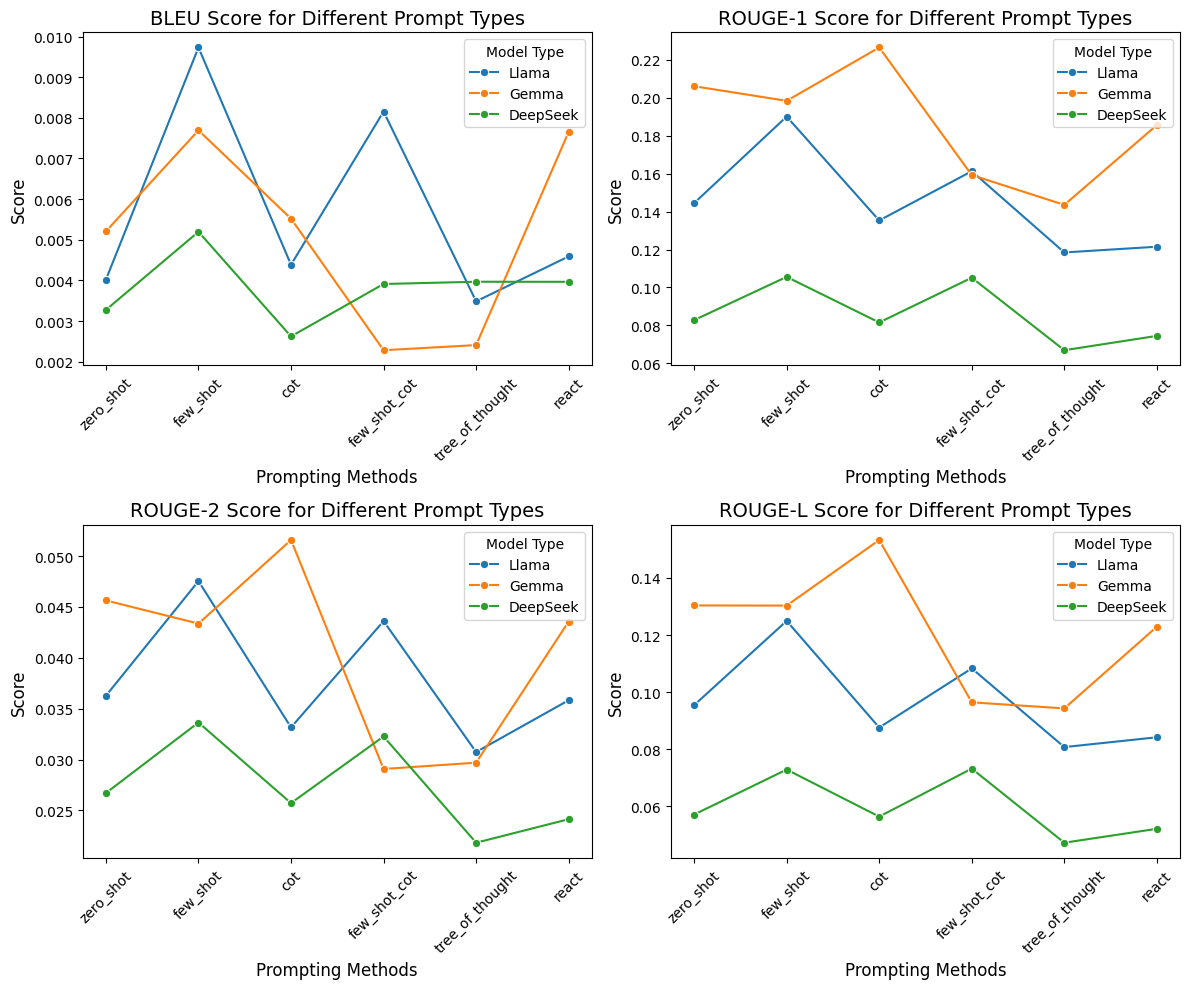

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the CSV file
df = pd.read_csv("model_evaluation_summary.csv")

# Create separate plots for BLEU, ROUGE-1, ROUGE-2, and ROUGE-L
metrics = ['BLEU', 'R1', 'R2', 'RL']
metric_names = ['BLEU Score', 'ROUGE-1 Score', 'ROUGE-2 Score', 'ROUGE-L Score']

# Setting up the figure size for the plots
plt.figure(figsize=(12, 10))

# Loop through each metric to generate a separate plot
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)  # Create a 2x2 grid of subplots
    sns.lineplot(x='Prompting', y=metric, hue='Model Type', data=df, marker='o')
    plt.title(f'{metric_names[i]} for Different Prompt Types', fontsize=14)
    plt.xlabel('Prompting Methods', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


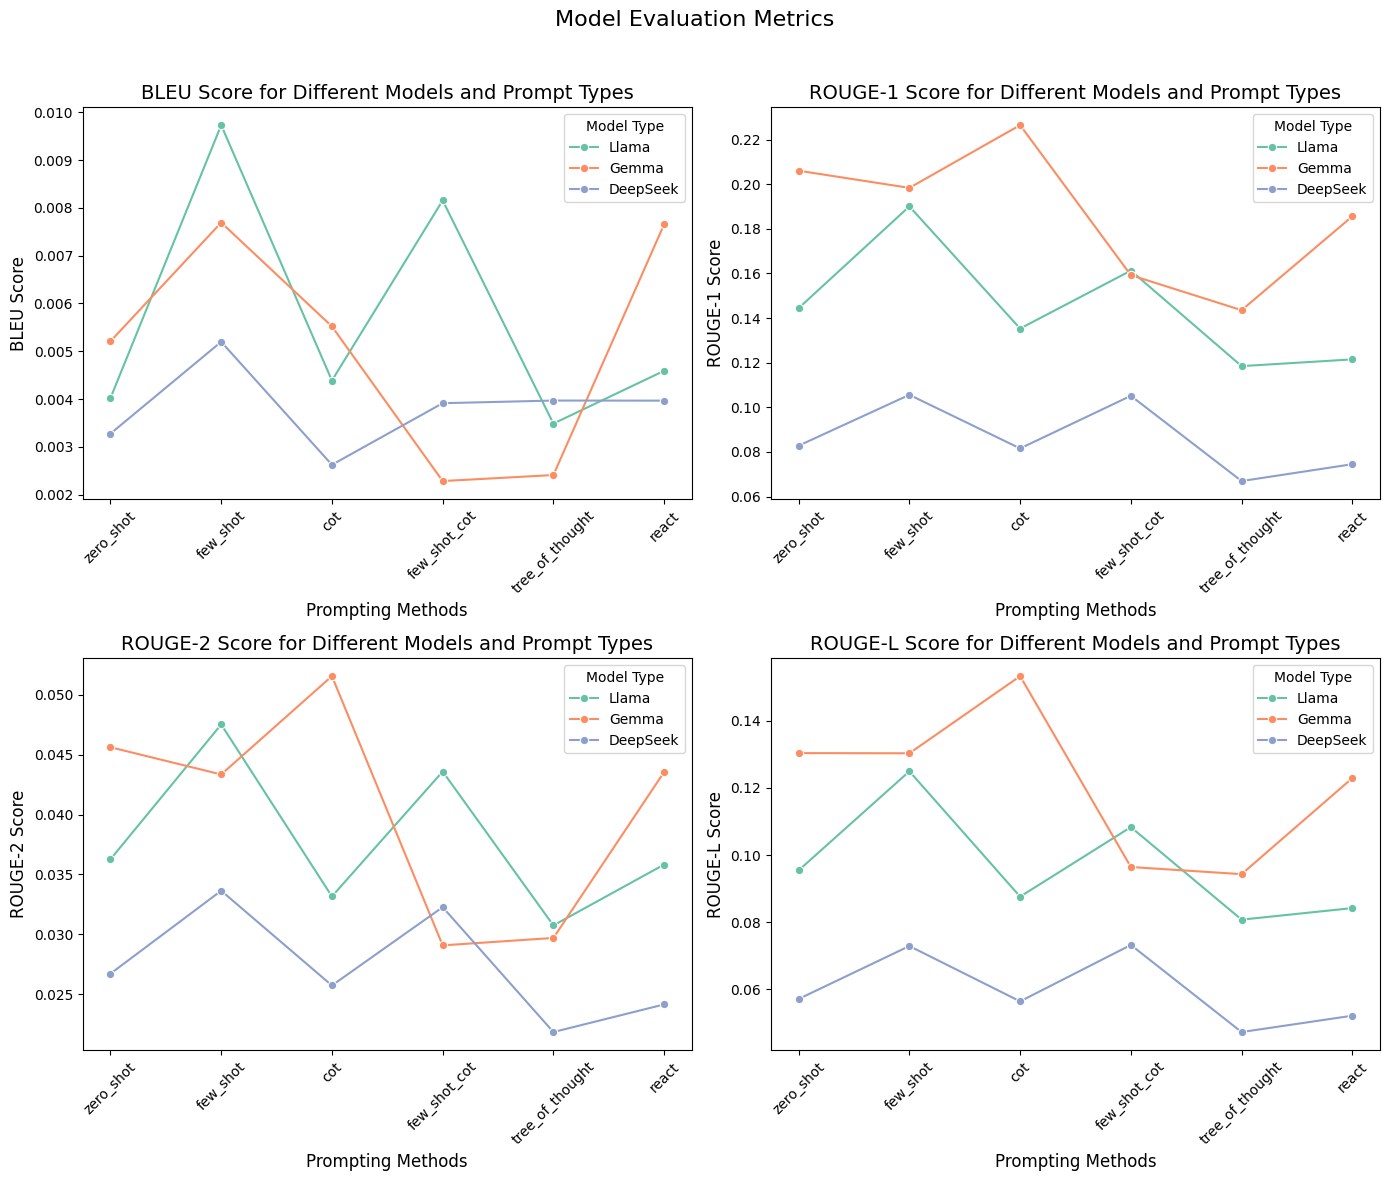

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the CSV file
df = pd.read_csv("model_evaluation_summary.csv")

# Define the metrics for plotting
metrics = ['BLEU', 'R1', 'R2', 'RL']
metric_names = ['BLEU Score', 'ROUGE-1 Score', 'ROUGE-2 Score', 'ROUGE-L Score']

# Set up a color palette for better visualization
palette = sns.color_palette("Set2", n_colors=3)

# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Model Evaluation Metrics', fontsize=16)

# Loop through each metric and create a plot
for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]  # Get the correct subplot (2x2 grid)
    sns.lineplot(x='Prompting', y=metric, hue='Model Type', data=df, marker='o', palette=palette, ax=ax)

    ax.set_title(f'{metric_names[i]} for Different Models and Prompt Types', fontsize=14)
    ax.set_xlabel('Prompting Methods', fontsize=12)
    ax.set_ylabel(f'{metric_names[i]}', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Model Type')

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
